<a href="https://colab.research.google.com/github/mrreyesm/SECOM/blob/main/SECOM__3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECOM: Data Preparation & Modelling

# Setting Environment

## Libraries

In [ ]:
#Global Variables
test_size = .2
perc_missing_values = 55
variance_threshold = 0.995
#Importing Librarys 
# For system related operations
import sys
#For the creation of dataframes and manipulating data
import pandas as pd
from pandas.api.types import is_numeric_dtype
from tabulate import tabulate
# For numerical processing
import numpy as np
# For statistical analysis
import statistics
# For data visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (25,16)
import seaborn as sns
# Stats
from scipy.stats import shapiro
# Iterable tools
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
# For creating models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
!{sys.executable} -m pip install boruta
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.metrics import roc_curve, f1_score,recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Master functions

In [ ]:
# Create function that describes each column
def descriptive_statistics(df):
  #Creates empty target dataframe
  col_names = ["FEATURE", "COUNT", "SUM",  "MEAN", "MIN", "Q1", "MEDIAN",
             "Q3", "MAX", "VARIANCE", "STANDARD_DEV", "UNIQUE_VALUES",
             "MISSING_VALUES", "PERCENTAGE_NA", "OUTLIERS_3S", "PERCENTAGE_O3S",
             "NORM_STD"]
  descriptive_df = pd.DataFrame(columns=col_names)
  # Only for numeric values
  df = df.select_dtypes(include=['int64','float64'])
  # Iterates through each column
  for col, col_name in enumerate(df.columns):
    num_values = df[col_name].count()
    sum = df[col_name].sum()
    # Central tendency
    mean = df[col_name].mean()
    min = df[col_name].min()
    q1 = df[col_name].quantile(0.25)
    median = df[col_name].quantile(0.50)
    q3 = df[col_name].quantile(0.75)
    max = df[col_name].max()
    # Volatility
    var = df[col_name].var()
    std = df[col_name].std()
    unique = df[col_name].nunique()
    missing = df[col_name].isnull().sum()
    percentage_na = df[col_name].isnull().sum() * 100 / len(df[col_name])
    # Outlier identification with zscore
    zscores = (df[col_name]-mean)/std
    zscores = zscores.to_frame()
    zoutliers = zscores.query(f"{col_name} > 3 or {col_name} < -3")
    outliers = zoutliers[col_name].count()
    perc_out = (outliers/num_values)*100
    # Min - Max normalization
    temp = (df[col_name] - min)/ (max - min)
    std_norm_values = temp.std()
    # Creates a list wirh all the values and concatenates it to target df
    desc = [col_name, num_values, sum,  mean, min, q1, median, q3,
           max, var, std, unique, missing, percentage_na, outliers,
           perc_out, std_norm_values]
    df_length = len(descriptive_df)
    descriptive_df.loc[df_length] = desc
  return descriptive_df

In [ ]:
# Create function that counts columns with above certain % of NAs
def show_features_many_nulls(df, percentage):
    features_nulls = []
    for col in df.columns:
        percentage_nulls = 100 * (df[col].isna().sum() / len(df[col]))
        if (percentage_nulls > percentage) and (col != 'TIMESTAMP' or col != 'STATUS'):
          features_nulls.append(col)
    print(f"Features with more than {percentage}% of missing values: {len(features_nulls)}")

In [ ]:
#functions to treat outliers
def outlier_replacement(data):
  copy_train_df = data.copy()
  df = data.copy()
  for col in df.columns:
      mean = df[col].mean()
      std_dev = df[col].std(axis=0)
      copy_train_df[col] = np.where(df[col] > (mean + 3*std_dev), 1, np.where(df[col] < (mean - 3*std_dev), 1, 0))                            
      df[col] = np.where(df[col] > (mean + 3*std_dev) , (mean + 3*std_dev), np.where(df[col] < (mean - 3*std_dev) , (mean - 3*std_dev), df[col]))  
  print("TOTAL OF VALUES: ", (copy_train_df.isnull().sum().sum() + copy_train_df.notnull().sum().sum()),
        "\nTOTAL OF OUTLIERS: ", copy_train_df.sum().sum(),
        "\nPERCENTAGE OF OUTLIERS REPLACED: ", (copy_train_df.sum().sum()/(copy_train_df.isnull().sum().sum() + copy_train_df.notnull().sum().sum()))*100, "%"  )
  return df

In [ ]:
#function to apply kNN imputation
def knn_imputation(data):
  scaler = MinMaxScaler(feature_range=(-1,1))
  df = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
  print("PERCENTAGE OF MISSING VALUES:",
        round((df.isnull().sum().sum()/(df.isnull().sum().sum() 
        + df.notnull().sum().sum()))*100, 2) , " %")
  imputer = KNNImputer(n_neighbors=5)
  df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
  print("PERCENTAGE OF MISSING VALUES AFTER KNN IMPUTATION:",
        round((df.isnull().sum().sum()/(df.isnull().sum().sum() 
        + df.notnull().sum().sum()))*100, 2) , " %")
  return df

In [ ]:
#function to apply MICE imputation
def mice_imputation(data):
  print("PERCENTAGE OF MISSING VALUES:",
        round((data.isnull().sum().sum()/(data.isnull().sum().sum() 
        + data.notnull().sum().sum()))*100, 2) , " %")
  df = data.copy()
  lr = LinearRegression()
  mice_imputer = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, imputation_order='roman',random_state=42)
  df.iloc[:, :] = mice_imputer.fit_transform(data)
  print("PERCENTAGE OF MISSING VALUES AFTER MICE IMPUTATION:",round((df.isnull().sum().sum()/(df.isnull().sum().sum() 
        + df.notnull().sum().sum()))*100, 2) , " %")
  #scaler = MinMaxScaler(feature_range=(-1,1))
  #df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
  return df

In [ ]:
#funciton to apply boruta feature selection
def boruta_feature_selection(data, target_var):
  data[target_var] = np.where(data[target_var] < 0, -1, 1)
  # define random forest classifier
  forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
  df = data.iloc[: , :-1]
  forest.fit(np.array(df), np.array(data[target_var]))
  # define Boruta feature selection method
  feat_selector = BorutaPy(forest, n_estimators='auto', random_state=42)
  # find all relevant features
  feat_selector.fit(np.array(df), np.array(data[target_var]))
  # zip my names, ranks, and decisions in a single iterable
  feature_ranks = list(zip(df.columns, 
                          feat_selector.ranking_, 
                          feat_selector.support_))
  feature_ranks = pd.DataFrame (feature_ranks, columns = ['FEATURE', 'RANK', 'KEEP'])
  boruta_features = feature_ranks.query("RANK == 1 | RANK == 2 ")
  boruta_features = boruta_features["FEATURE"].unique()
  boruta_features = np.append(boruta_features, target_var)
  df = data[boruta_features]
  print("FEATURES LEFT WITH BORUTA: ",df.shape[1])
  return df

In [ ]:
#function to apply SMOTE balancing
def smote_balancing(data, target_var):
  print("BEFORE BALANCING")
  print(data.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  smote = SMOTE(random_state=42)
  df = data.iloc[: , :-1]
  df_data_sm, df_target_sm = smote.fit_resample(df, data[target_var])
  print("AFTER SMOTE BALANCING")
  df = pd.concat([df_data_sm, df_target_sm], axis=1)
  print(df.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  return df 

In [ ]:
#function to apply ROSE balancing
def rose_balancing(data, target_var):
  print("BEFORE BALANCING")
  print(data.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  ros = RandomOverSampler(random_state=42)
  df = data.iloc[: , :-1]
  print("AFTER ROSE BALANCING")
  df_data_ros, df_target_ros = ros.fit_resample(df, data[target_var])
  df = pd.concat([df_data_ros, df_target_ros], axis=1)
  print(df.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  return df

In [ ]:
#Function to evaluate several models
def data_preparation(X_train, X_test, target_var):
  ##IMPUTATION
  print("\n--------------------IMPUTATION--------------------\n")
  #KNN Imputation
  print("TRAIN SET:")
  X__train__knn = knn_imputation(X_train)
  print("TEST SET:")
  X__test__knn = knn_imputation(X_test)
  #MICE IMPUTATION
  print("\nTRAIN SET:")
  X__train__mice = mice_imputation(X_train)
  print("\nTEST SET:")
  X__test__mice = mice_imputation(X_test)
  #FEATURE SELECTION
  print("\n--------------------FEATURE SELECTION--------------------\n")
  print("\nKNN TRAIN SET:")
  X__train__knn__boruta = boruta_feature_selection(X__train__knn, target_var = target_var)
  X__test__knn__boruta = X__test__knn[X__train__knn__boruta.columns]
  print("KNN BORUTA TRAIN SET SHAPE: ", X__train__knn__boruta.shape)
  print("KNN BORUTA TEST SET SHAPE: ", X__test__knn__boruta.shape)
  print("\nMICE TRAIN SET:")
  X__train__mice__boruta = boruta_feature_selection(X__train__mice, target_var = target_var)
  X__test__mice__boruta = X__test__mice[X__train__mice__boruta.columns]
  print("MICE BORUTA TRAIN SET SHAPE: ", X__train__mice__boruta.shape)
  print("MICE BORUTA TEST SET SHAPE: ", X__test__mice__boruta.shape)
  #BALANCING
  print("\n--------------------BALANCING--------------------\n")
  #SMOTE
  print("\nKNN BORUTA TRAIN SET:")
  X__train__knn__boruta__smote = smote_balancing(X__train__knn__boruta, target_var = target_var)
  print("MICE BORUTA TRAIN SET:")
  X__train__mice__boruta__smote = smote_balancing(X__train__mice__boruta, target_var = target_var)
  #ROSE
  print("KNN BORUTA TRAIN SET:")
  X__train__knn__boruta__rose =  rose_balancing(X__train__knn__boruta, target_var = target_var)
  print("MICE BORUTA TRAIN SET:")
  X__train__mice__boruta__rose = rose_balancing(X__train__mice__boruta, target_var = target_var)

  train_test_dict = {1: ["KNN BORUTA SMOTE",X__train__knn__boruta__smote,X__test__knn__boruta],
                     2: ["MICE BORUTA SMOTE",X__train__mice__boruta__smote,X__test__mice__boruta],
                     3: ["KNN BORUTA ROSE",X__train__knn__boruta__rose,X__test__knn__boruta],
                     4: ["MICE BORUTA ROSE",X__train__mice__boruta__rose,X__test__mice__boruta ]}
  return train_test_dict

In [ ]:
def model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name):
  conf_matrix = confusion_matrix(Y_test, Y_pred)
  TP = conf_matrix[1][1]
  TN = conf_matrix[0][0]
  FP = conf_matrix[0][1]
  FN = conf_matrix[1][0]
  conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
  conf_misclassification = 1- conf_accuracy
  conf_sensitivity = (TP / float(TP + FN))
  conf_specificity = (TN / float(TN + FP))
  conf_precision = (TP / float(TP + FP))
  conf_NPV = (TN / float(TN + FN))
  conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
  accuracyscore = accuracy_score(Y_test, Y_pred)
  recallscore = recall_score(Y_test, Y_pred, average=None)
  precisionscore = precision_score(Y_test, Y_pred, average=None)
  specificity_score = recall_score(Y_test, Y_pred, average=None, pos_label = 0)
  f1score = f1_score(Y_test, Y_pred, average=None)
  roc_auc = roc_auc_score(Y_test, Y_pred)
  print('Accuracy Score: ',accuracyscore)
  print('Recall Score: ',recallscore)
  print('Precision Score: ',precisionscore)
  print('Specificity Score: ',specificity_score)
  print('F1 Score: ',f1score)
  print('ROC AUC: ',roc_auc)
  print('Test of confusion Matrix Scores')
  print('True Positives:', TP)
  print('True Negatives:', TN)
  print('False Positives:', FP)
  print('False Negatives:', FN)
  print('-'*50)
  print(f'Accuracy: {round(conf_accuracy,2)}') 
  print(f'Mis-Classification: {round(conf_misclassification,2)}') 
  print(f'Sensitivity: {round(conf_sensitivity,2)}') 
  print(f'Specificity: {round(conf_specificity,2)}') 
  print(f'Precision: {round(conf_precision,2)}')
  print(f'Negative Predictive Value: {round(conf_NPV,2)}')
  print(f'f_1 Score: {round(conf_f1,2)}')
  print(classification_report(Y_test, Y_pred))
  fpr, tpr, thresholds = roc_curve(Y_test, clf_model.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='(area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('ROC')
  plt.show()
  COMBINATIONS = clf_model_name + ' ' + train_test_name
  model = [COMBINATIONS, TP,  TN,  FP,  FN,  conf_accuracy,
           conf_misclassification, conf_sensitivity, conf_specificity,
           conf_precision,  conf_NPV, conf_f1,  accuracyscore, recallscore,
           precisionscore,   specificity_score,  f1score,  roc_auc]
  df_length = len(models_df)
  models_df.loc[df_length] = model

  return models_df

In [ ]:
def logistic_regression(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'LOGISTIC REGRESSION'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  clf_model = LogisticRegression()
  clf_model.fit(X_train, Y_train)
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
def naive_bayes(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'NAIVE BAYES'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  clf_model = GaussianNB()
  clf_model.fit(X_train, Y_train)
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
#Function for KNN 
def knn_model(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'KNN'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
  clf_model = KNeighborsClassifier(n_neighbors=5)
  clf_model.fit(X_train, Y_train)
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
#Function for SVM
def svm_model(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'SVM'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  #Create a svm Classifier
  clf_model = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', random_state=0, gamma=.01, C=1,probability=True)) # Linear Kernel
  #Train the model using the training sets
  clf_model.fit(X_train, Y_train)
  #Predict the response for test dataset
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
#Function for random forest classifier
def randomForestClassifier_model(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'RANDOM FOREST CLASS'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  #Create a random forest Classifier
  clf_model = RandomForestClassifier(random_state=42)
  #Train the model using the training sets
  clf_model.fit(X_train, Y_train)
  #Predict the response for test dataset
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
#Function for decision tree classifier
def DecisionTreeClassifier_model(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'DECISION TREE CLASS'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  #Create a decision tree Classifier
  clf_model = DecisionTreeClassifier()
  #Train the model using the training sets
  clf_model.fit(X_train, Y_train)
  #Predict the response for test dataset
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
#Logistic regression using Class Weights
def logistic_regression_weighted(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'LOGISTIC REGRESSION WEIGHTED'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  clf_model = LogisticRegression(class_weight={1:2, -1:1})
  clf_model.fit(X_train, Y_train)
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
#Function for random forest classifier with Class weights
def randomForestClassifier_model_weighted(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'RANDOM FOREST CLASS WEIGHTED'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  #Create a random forest Classifier
  clf_model = RandomForestClassifier(random_state=42, class_weight={1:2, -1:1})
  #Train the model using the training sets
  clf_model.fit(X_train, Y_train)
  #Predict the response for test dataset
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
#Function for decision tree classifier 2
def DecisionTreeClassifier_model_weighted(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'DECISION TREE CLASS WEIGHTED'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  #Create a decision tree Classifier
  clf_model = DecisionTreeClassifier(class_weight={1:2, -1:1})
  #Train the model using the training sets
  clf_model.fit(X_train, Y_train)
  #Predict the response for test dataset
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
def modelling(train_test_dict, target_var):
  col_names = ['COMBINATIONS','TruePositives','TrueNegatives',
               'FalsePositives','FalseNegatives','Accuracy','MisClassification',
               'Sensitivity','Specificity','Precision','Negative_Predictive_Value',
               'f_1Score','AccuracyScore','RecallScore','PrecisionScore','SpecificityScore',
               'F1Score','ROCAUC']

  models_df = pd.DataFrame(columns=col_names)

  print("\n--------------------MODELLING--------------------\n")
  #MODELS
  print("n---------------LOGISTIC REGRESSION----------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>LOGISTIC REGRESSION", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = logistic_regression(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var, train_test_name = train_test_dict[train][0])
  print("n---------------LOGISTIC REGRESSION WEIGHTED----------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = logistic_regression_weighted(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var, train_test_name = train_test_dict[train][0])
  print("n-------------K-NEAREST NEIGHBORS-------------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>KNN ", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = knn_model(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var,  train_test_name = train_test_dict[train][0])
  print("n------------SUPPORT VECTOR MACHINE----------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>SVM ", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = svm_model(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var,  train_test_name = train_test_dict[train][0])
  print("n-----------------NAIVE BAYES----------------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>NAIVE BAYES ", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = naive_bayes(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var,  train_test_name = train_test_dict[train][0])
  print("n-----------------DECISION TREE--------------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>DECISION TREE CLASSIFIER ", train_test_dict[train][0],"<<<<<<<<<<<<<\n",)
    models_df = DecisionTreeClassifier_model(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var,  train_test_name = train_test_dict[train][0])
  print("n-----------------DECISION TREE 222222--------------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>DECISION TREE CLASSIFIER WEIGHTED", train_test_dict[train][0],"<<<<<<<<<<<<<\n",)
    models_df = DecisionTreeClassifier_model_weighted(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var,  train_test_name = train_test_dict[train][0])
  print("n-----------RANDOM FOREST CLASSIFIER---------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>RANDOM FOREST CLASSIFIER ", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = randomForestClassifier_model(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var,  train_test_name = train_test_dict[train][0])  
  print("n-----------RANDOM FOREST CLASSIFIER WEIGHTED---------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>RANDOM FOREST CLASSIFIER WEIGHTED", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = randomForestClassifier_model_weighted(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var,  train_test_name = train_test_dict[train][0])
  #Add costs
  type_I_error = 60
  type_II_error = type_I_error * 10
  type_II_error_conservative = type_I_error * 3
  models_df['Cost_per_Error_I'] = models_df.FalsePositives * type_I_error
  models_df['Cost_per_Error_II'] = models_df.FalseNegatives	* type_II_error
  models_df['Total_Error_Cost'] = models_df['Cost_per_Error_I'] + models_df['Cost_per_Error_II']
  models_df['Conservative_Cost_per_Error_II'] = models_df.FalseNegatives	* type_II_error_conservative
  models_df['ConservativeTotal_Error_Cost'] = models_df['Cost_per_Error_I'] + models_df['Conservative_Cost_per_Error_II']
  return models_df

In [ ]:
def logistic_regression_w_gridsearch(X_train, X_test, target_var, train_test_name):
  clf_model_name = 'LOGISTIC REGRESSION'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  clf_model = LogisticRegression()
  clf_model.fit(X_train, Y_train)
  Y_pred = clf_model.predict(X_test)
  parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
  grid_search = GridSearchCV(estimator = clf_model,  
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5,
                            verbose=0)
  grid_search.fit(X_train, Y_train)
  grid = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']].head(10)
  grid["MODEL"] = clf_model_name + ' ' + train_test_name
  print(tabulate(grid, headers='keys', tablefmt='psql'), "\n")

In [ ]:
def logistic_regression_weighted_w_gridsearch(X_train, X_test, target_var, train_test_name):
  clf_model_name = 'LOGISTIC REGRESSION WEIGHTED'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  clf_model = LogisticRegression(class_weight={1:2, -1:1})
  clf_model.fit(X_train, Y_train)
  Y_pred = clf_model.predict(X_test)
  parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
  grid_search = GridSearchCV(estimator = clf_model,  
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5,
                            verbose=0)
  grid_search.fit(X_train, Y_train)
  grid = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']].head(10)
  grid["MODEL"] = clf_model_name + ' ' + train_test_name
  print(tabulate(grid, headers='keys', tablefmt='psql'), "\n")

In [ ]:
#Function for SVM
def svm_model_w_gridsearch(X_train, X_test, target_var, train_test_name):
  clf_model_name = 'SVM'
  scaler = StandardScaler()
# transform data
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  X_train = scaler.fit_transform(X_train) 
  X_test = scaler.fit_transform(X_test) 
  #Create a svm Classifier
  clf_model = SVC(probability=True) # Linear Kernel
  #Train the model using the training sets
  clf_model.fit(X_train, Y_train)
  #Predict the response for test dataset
  Y_pred = clf_model.predict(X_test)


  parameters = [{'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}]
  grid_search = GridSearchCV(estimator = clf_model,  
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5,
                            verbose=0)
  grid_search.fit(X_train, Y_train)
  grid = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']].head(10)
  grid["MODEL"] = clf_model_name + ' ' + train_test_name
  print(tabulate(grid, headers='keys', tablefmt='psql'), "\n")

In [ ]:
def naive_bayes_w_gridsearch(X_train, X_test, target_var, train_test_name):
  clf_model_name = 'NAIVE BAYES'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  clf_model = GaussianNB()
  clf_model.fit(X_train, Y_train)
  Y_pred = clf_model.predict(X_test)

  parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
  grid_search = GridSearchCV(estimator = clf_model,  
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5,
                            verbose=0)
  grid_search.fit(X_train, Y_train)
  grid = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']].head(10)
  grid["MODEL"] = clf_model_name + ' ' + train_test_name
  print(tabulate(grid, headers='keys', tablefmt='psql'), "\n")


In [ ]:
def logistic_regression_mod(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'LOGISTIC REGRESSION'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  clf_model = LogisticRegression(C=10, solver = 'liblinear')
  clf_model.fit(X_train, Y_train)
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
#Logistic regression using Class Weights
def logistic_regression_weighted_mod(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'LOGISTIC REGRESSION WEIGHTED'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  clf_model = LogisticRegression(C=10, solver = 'liblinear', class_weight={1:2, -1:1})
  clf_model.fit(X_train, Y_train)
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
def naive_bayes_mod(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'NAIVE BAYES'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  clf_model = GaussianNB(var_smoothing=2.848035868435799e-05)
  clf_model.fit(X_train, Y_train)
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
#Function for SVM
def svm_model_mod(models_df, X_train, X_test, target_var, train_test_name):
  clf_model_name = 'SVM'
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  #Create a svm Classifier
  clf_model = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', random_state=0, gamma=.01, C=1,probability=True)) # Linear Kernel
  #Train the model using the training sets
  clf_model.fit(X_train, Y_train)
  #Predict the response for test dataset
  Y_pred = clf_model.predict(X_test)
  models_df = model_scores(models_df, Y_test, Y_pred, X_test, clf_model, clf_model_name, train_test_name)
  return models_df

In [ ]:
def modelling_mod(train_test_dict, target_var):
  col_names = ['COMBINATIONS','TruePositives','TrueNegatives',
               'FalsePositives','FalseNegatives','Accuracy','MisClassification',
               'Sensitivity','Specificity','Precision','Negative_Predictive_Value',
               'f_1Score','AccuracyScore','RecallScore','PrecisionScore','SpecificityScore',
               'F1Score','ROCAUC']

  models_df = pd.DataFrame(columns=col_names)

  print("\n--------------------MODELLING--------------------\n")
  #MODELS
  print("n---------------LOGISTIC REGRESSION----------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>LOGISTIC REGRESSION", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = logistic_regression_mod(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var, train_test_name = train_test_dict[train][0])
  print("n---------------LOGISTIC REGRESSION WEIGHTED----------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = logistic_regression_weighted_mod(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var, train_test_name = train_test_dict[train][0])
  print("n------------SUPPORT VECTOR MACHINE----------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>SVM ", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = svm_model_mod(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var,  train_test_name = train_test_dict[train][0])
  print("n-----------------NAIVE BAYES----------------------\n")
  for train in train_test_dict:
    print("\n>>>>>>>>>>>NAIVE BAYES ", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
    models_df = naive_bayes_mod(models_df, train_test_dict[train][1], train_test_dict[train][2], target_var = target_var,  train_test_name = train_test_dict[train][0])
  #Add costs
  type_I_error = 60
  type_II_error = type_I_error * 10
  type_II_error_conservative = type_I_error * 3
  models_df['Cost_per_Error_I'] = models_df.FalsePositives * type_I_error
  models_df['Cost_per_Error_II'] = models_df.FalseNegatives	* type_II_error
  models_df['Total_Error_Cost'] = models_df['Cost_per_Error_I'] + models_df['Cost_per_Error_II']
  models_df['Conservative_Cost_per_Error_II'] = models_df.FalseNegatives	* type_II_error_conservative
  models_df['ConservativeTotal_Error_Cost'] = models_df['Cost_per_Error_I'] + models_df['Conservative_Cost_per_Error_II']
  return models_df

## Loading data

In [ ]:
# Creates a dataframe with the features of the SECOM dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom_features = pd.read_csv(url, sep = ' ', header = None)
# Gives names to the columns according to their position in the dataset
secom_features.columns = ["FEATURE_"+str(col+1) for col in
                          range(0,len(secom_features.columns))]
# Creates a dataframe with the labels of the SECOM dataset and gives a col name
url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secom_labels = pd.read_csv(url, sep = " ", header = None)
secom_labels.columns = ("STATUS", "TIMESTAMP")
# Changes timestamp column to datetime format
secom_labels['TIMESTAMP'] =  pd.to_datetime(secom_labels['TIMESTAMP'])
# Merges both datasets through the index
secom_data = pd.merge(secom_labels, secom_features, left_index=True,
                      right_index=True)
secom_data.shape
print("SECOM DATASET\n")
print("ROWS: ",secom_data.shape[0], "COLUMNS: ",secom_data.shape[1])
Fail = secom_data[secom_data["STATUS"] == 1]
Pass = secom_data[secom_data["STATUS"] == -1]
print( "Fail cases: ", Fail["STATUS"].count(), "Pass cases: ", Pass["STATUS"].count())
print( "Fail cases: ", round(Fail["STATUS"].count()/(Fail["STATUS"].count()+Pass["STATUS"].count())*100,2),
      "%","Pass cases: ", round(Pass["STATUS"].count()/(Fail["STATUS"].count()+Pass["STATUS"].count())*100,2),"%")
# Overall number of missing values in the dataset
print("PERCENTAGE OF MISSING VALUES :",
      round((secom_data.isnull().sum().sum()/(secom_data.isnull().sum().sum() 
      + secom_data.notnull().sum().sum()))*100, 2) , " %")
show_features_many_nulls(secom_data, perc_missing_values)

SECOM DATASET

ROWS:  1567 COLUMNS:  592
Fail cases:  104 Pass cases:  1463
Fail cases:  6.64 % Pass cases:  93.36 %
PERCENTAGE OF MISSING VALUES : 4.52  %
Features with more than 55% of missing values: 24


# Splitting data

In [ ]:
# Subset dataset between fail and pass, split and then concatenate to keep proportion
subset = secom_data.drop(columns = "TIMESTAMP")
# select pass cases
pass_df = subset[subset["STATUS"] == 1]
X_p = pass_df.iloc[:,1:]
y_p = pass_df.loc[:,"STATUS"]
# select fail cases
fail_df = subset[subset["STATUS"] == -1]
X_f = fail_df.iloc[:,1:]
y_f = fail_df.loc[:,"STATUS"]
#Split into test and train dataset 80% 20%
X_train_p,X_test_p,y_train_p,y_test_p = train_test_split(X_p, y_p, test_size=test_size,
                                                         random_state=42)
X_train_f,X_test_f,y_train_f,y_test_f = train_test_split(X_f, y_f, test_size=test_size,
                                                         random_state=42)
#Concatenate results
X_train = pd.concat([X_train_p, X_train_f], axis=0)
X_test = pd.concat([X_test_p, X_test_f], axis=0)
y_train = pd.concat([y_train_p, y_train_f], axis=0)
y_test = pd.concat([y_test_p, y_test_f], axis=0)
#Examine proportions of train dataset
print("----TRAIN DATASET----\n")
X_train = pd.concat([X_train, y_train], axis=1)
print(X_train.shape)
Fail = X_train[X_train["STATUS"] == 1]
Pass = X_train[X_train["STATUS"] == -1]
print( "Fail cases: ", Fail["STATUS"].count(), "Pass cases: ", Pass["STATUS"].count())
print( "Fail cases: ", round(Fail["STATUS"].count()/(Fail["STATUS"].count()+Pass["STATUS"].count())*100,2),
      "%","Pass cases: ", round(Pass["STATUS"].count()/(Fail["STATUS"].count()+Pass["STATUS"].count())*100,2),"%")
# Overall number of missing values in the dataset
print("PERCENTAGE OF MISSING VALUES :",
      round((X_train.isnull().sum().sum()/(X_train.isnull().sum().sum() 
      + X_train.notnull().sum().sum()))*100, 2) , " %")
#Examine proportions of test dataset
print("\n----TEST DATASET----\n")
X_test = pd.concat([X_test, y_test], axis=1)
print(X_test.shape)
Fail = X_test[X_test["STATUS"] == 1]
Pass = X_test[X_test["STATUS"] == -1]
print( "Fail cases: ", Fail["STATUS"].count(), "Pass cases: ", Pass["STATUS"].count())
print( "Fail cases: ", round(Fail["STATUS"].count()/(Fail["STATUS"].count()+Pass["STATUS"].count())*100,2),
      "%","Pass cases: ", round(Pass["STATUS"].count()/(Fail["STATUS"].count()+Pass["STATUS"].count())*100,2),"%")
# Overall number of missing values in the dataset
print("PERCENTAGE OF MISSING VALUES :",
      round((X_test.isnull().sum().sum()/(X_test.isnull().sum().sum() 
      + X_test.notnull().sum().sum()))*100, 2) , " %")
show_features_many_nulls(X_test, perc_missing_values)

----TRAIN DATASET----

(1253, 591)
Fail cases:  83 Pass cases:  1170
Fail cases:  6.62 % Pass cases:  93.38 %
PERCENTAGE OF MISSING VALUES : 4.54  %

----TEST DATASET----

(314, 591)
Fail cases:  21 Pass cases:  293
Fail cases:  6.69 % Pass cases:  93.31 %
PERCENTAGE OF MISSING VALUES : 4.49  %
Features with more than 55% of missing values: 24


#Rough Feature Removal

## High Percentage of missing values

In [ ]:
#Copy the Dataset to easily go back if mistakes are made
X_train_df = X_train.copy()
#This code will remove the features with a High Percentage of missing values (more than x%)
X_train_df_ = X_train_df
print("TOTAL FEATURES: ", len(X_train_df_.columns))
X_train_df = X_train_df.loc[:, X_train_df.isnull().mean() < perc_missing_values/100]
print("FEATURES REMOVED: ", len(X_train_df_.columns)-len(X_train_df.columns),
      f" cols with >{perc_missing_values}% Nulls"
      "\nFEATURES LEFT: ", len(X_train_df.columns))

TOTAL FEATURES:  591
FEATURES REMOVED:  24  cols with >55% Nulls
FEATURES LEFT:  567


## Low Variance

In [ ]:
X_train_dftemp = X_train_df
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_df = pd.DataFrame(scaler.fit_transform(X_train_df), columns = X_train_df.columns)
threshold = variance_threshold
var_threshold = threshold * (1 - threshold)
varThreshold = VarianceThreshold(var_threshold)
varThreshold.fit(X_train_df)
mask = varThreshold.get_support()
low_var_features = X_train_df.loc[:, ~mask].columns
X_train_df.drop(low_var_features, axis=1, inplace=True)
print("TOTAL FEATURES: ", len(X_train_dftemp.columns),
      "\nFEATURES REMOVED: ", len(X_train_dftemp.columns)-len(X_train_df.columns),
      f" featueres with stdev = 0 or whose values are equal in more than {threshold*100}% of the feature",
      "\nFEATURES LEFT: ", len(X_train_df.columns), "\n")

TOTAL FEATURES:  567 
FEATURES REMOVED:  140  featueres with stdev = 0 or whose values are equal in more than 99.5% of the feature 
FEATURES LEFT:  427 



#Starting point

In the following steps we will evaluate the different combinations of data preparation to get to the best combination for a simple model.

Simple feature romoval will already be done:

* Removing features with high percentage of missing values
* Removing features with near 0 variance

We will try different combinations imputations methods, feature selection and balancing and examine the performance of a simple Logistic Regression.

In [ ]:
print("TRAIN SET SHAPE: ", X_train.shape)
print("TEST SET SHAPE: ", X_test.shape)
print("NUMBER OF COLUMNS AFTER ROUGH FEATURE REMOVAL", len(X_train_df.columns))
X__train = X_train[X_train_df.columns]
X__test = X_test[X_train_df.columns]
print("TRAIN SET SHAPE: ", X__train.shape)
print("TEST SET SHAPE: ", X__test.shape)
print("\nTRAIN SET:")
X__train = outlier_replacement(X__train)
print("\nTEST SET:")
X__test = outlier_replacement(X__test)

TRAIN SET SHAPE:  (1253, 591)
TEST SET SHAPE:  (314, 591)
NUMBER OF COLUMNS AFTER ROUGH FEATURE REMOVAL 427
TRAIN SET SHAPE:  (1253, 427)
TEST SET SHAPE:  (314, 427)

TRAIN SET:
TOTAL OF VALUES:  535031 
TOTAL OF OUTLIERS:  4973 
PERCENTAGE OF OUTLIERS REPLACED:  0.9294788526272308 %

TEST SET:
TOTAL OF VALUES:  134078 
TOTAL OF OUTLIERS:  1271 
PERCENTAGE OF OUTLIERS REPLACED:  0.9479556675964738 %


#Data preparation

In [ ]:
train_test_dict = data_preparation(X__train, X__test, target_var = "STATUS")


--------------------IMPUTATION--------------------

TRAIN SET:
PERCENTAGE OF MISSING VALUES: 2.09  %
PERCENTAGE OF MISSING VALUES AFTER KNN IMPUTATION: 0.0  %
TEST SET:
PERCENTAGE OF MISSING VALUES: 2.09  %
PERCENTAGE OF MISSING VALUES AFTER KNN IMPUTATION: 0.0  %

TRAIN SET:
PERCENTAGE OF MISSING VALUES: 2.09  %
PERCENTAGE OF MISSING VALUES AFTER MICE IMPUTATION: 0.0  %

TEST SET:
PERCENTAGE OF MISSING VALUES: 2.09  %
PERCENTAGE OF MISSING VALUES AFTER MICE IMPUTATION: 0.0  %

--------------------FEATURE SELECTION--------------------


KNN TRAIN SET:
FEATURES LEFT WITH BORUTA:  19
KNN BORUTA TRAIN SET SHAPE:  (1253, 19)
KNN BORUTA TEST SET SHAPE:  (314, 19)

MICE TRAIN SET:
FEATURES LEFT WITH BORUTA:  17
MICE BORUTA TRAIN SET SHAPE:  (1253, 17)
MICE BORUTA TEST SET SHAPE:  (314, 17)

--------------------BALANCING--------------------


KNN BORUTA TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER SMOTE BALANCING
   STATUS  count
0      -1   1170
1    

#Modelling


--------------------MODELLING--------------------

n---------------LOGISTIC REGRESSION----------------


>>>>>>>>>>>LOGISTIC REGRESSION KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.8057324840764332
Recall Score:  [0.82593857 0.52380952]
Precision Score:  [0.96031746 0.17741935]
Specificity Score:  [0.82593857 0.52380952]
F1 Score:  [0.88807339 0.26506024]
ROC AUC:  0.6748740451812124
Test of confusion Matrix Scores
True Positives: 11
True Negatives: 242
False Positives: 51
False Negatives: 10
--------------------------------------------------
Accuracy: 0.81
Mis-Classification: 0.19
Sensitivity: 0.52
Specificity: 0.83
Precision: 0.18
Negative Predictive Value: 0.96
f_1 Score: 0.27
              precision    recall  f1-score   support

          -1       0.96      0.83      0.89       293
           1       0.18      0.52      0.27        21

    accuracy                           0.81       314
   macro avg       0.57      0.67      0.58       314
weighted avg       0.91      0.8

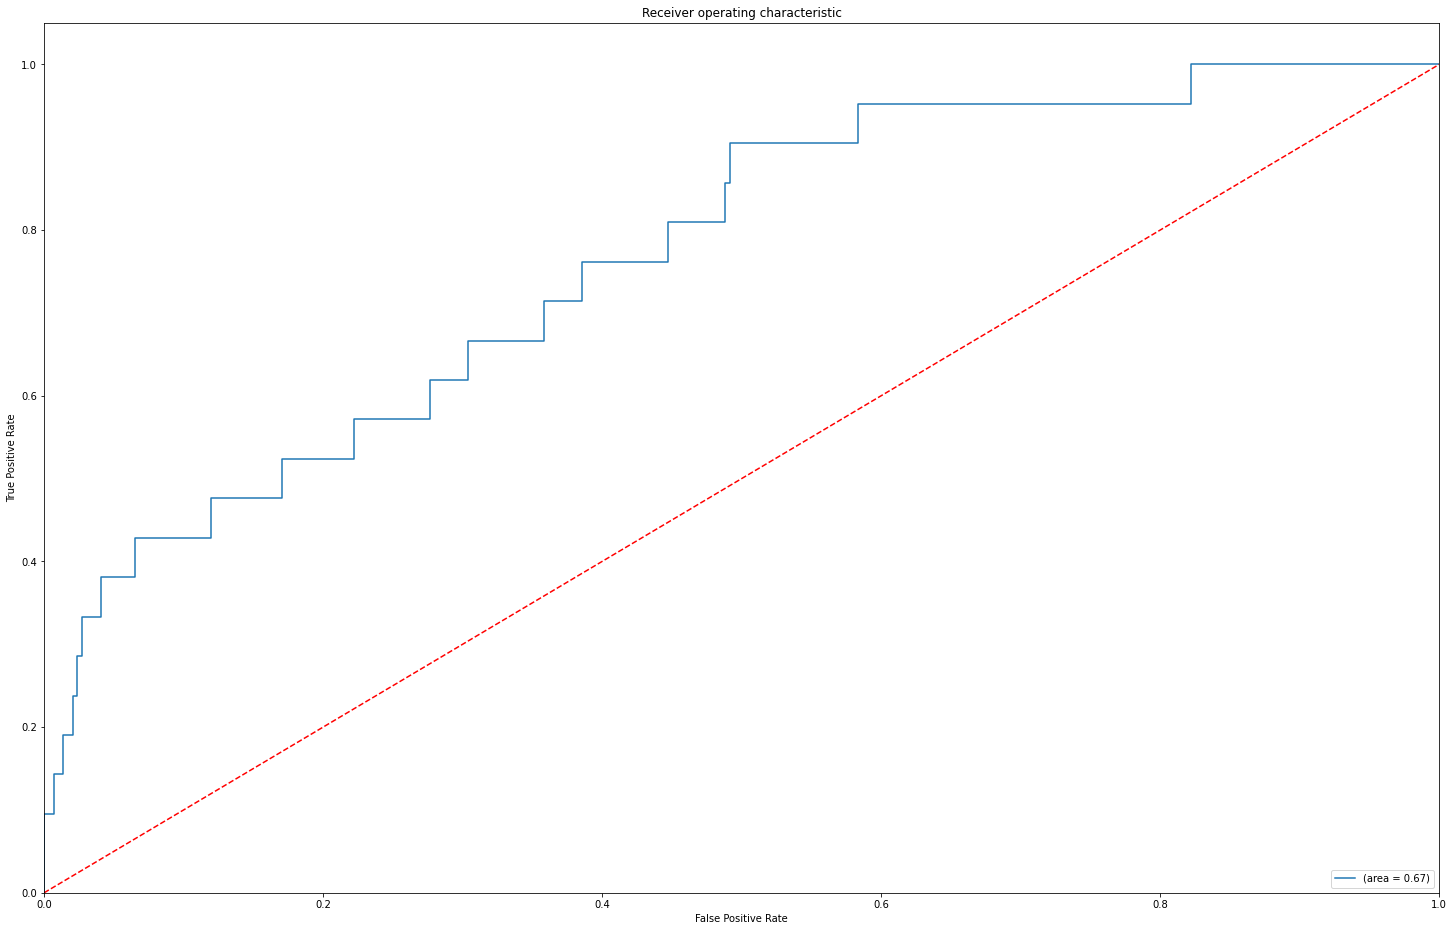


>>>>>>>>>>>LOGISTIC REGRESSION MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.6337579617834395
Recall Score:  [0.6552901  0.33333333]
Precision Score:  [0.93203883 0.06481481]
Specificity Score:  [0.6552901  0.33333333]
F1 Score:  [0.76953908 0.10852713]
ROC AUC:  0.49431171786120587
Test of confusion Matrix Scores
True Positives: 7
True Negatives: 192
False Positives: 101
False Negatives: 14
--------------------------------------------------
Accuracy: 0.63
Mis-Classification: 0.37
Sensitivity: 0.33
Specificity: 0.66
Precision: 0.06
Negative Predictive Value: 0.93
f_1 Score: 0.11
              precision    recall  f1-score   support

          -1       0.93      0.66      0.77       293
           1       0.06      0.33      0.11        21

    accuracy                           0.63       314
   macro avg       0.50      0.49      0.44       314
weighted avg       0.87      0.63      0.73       314



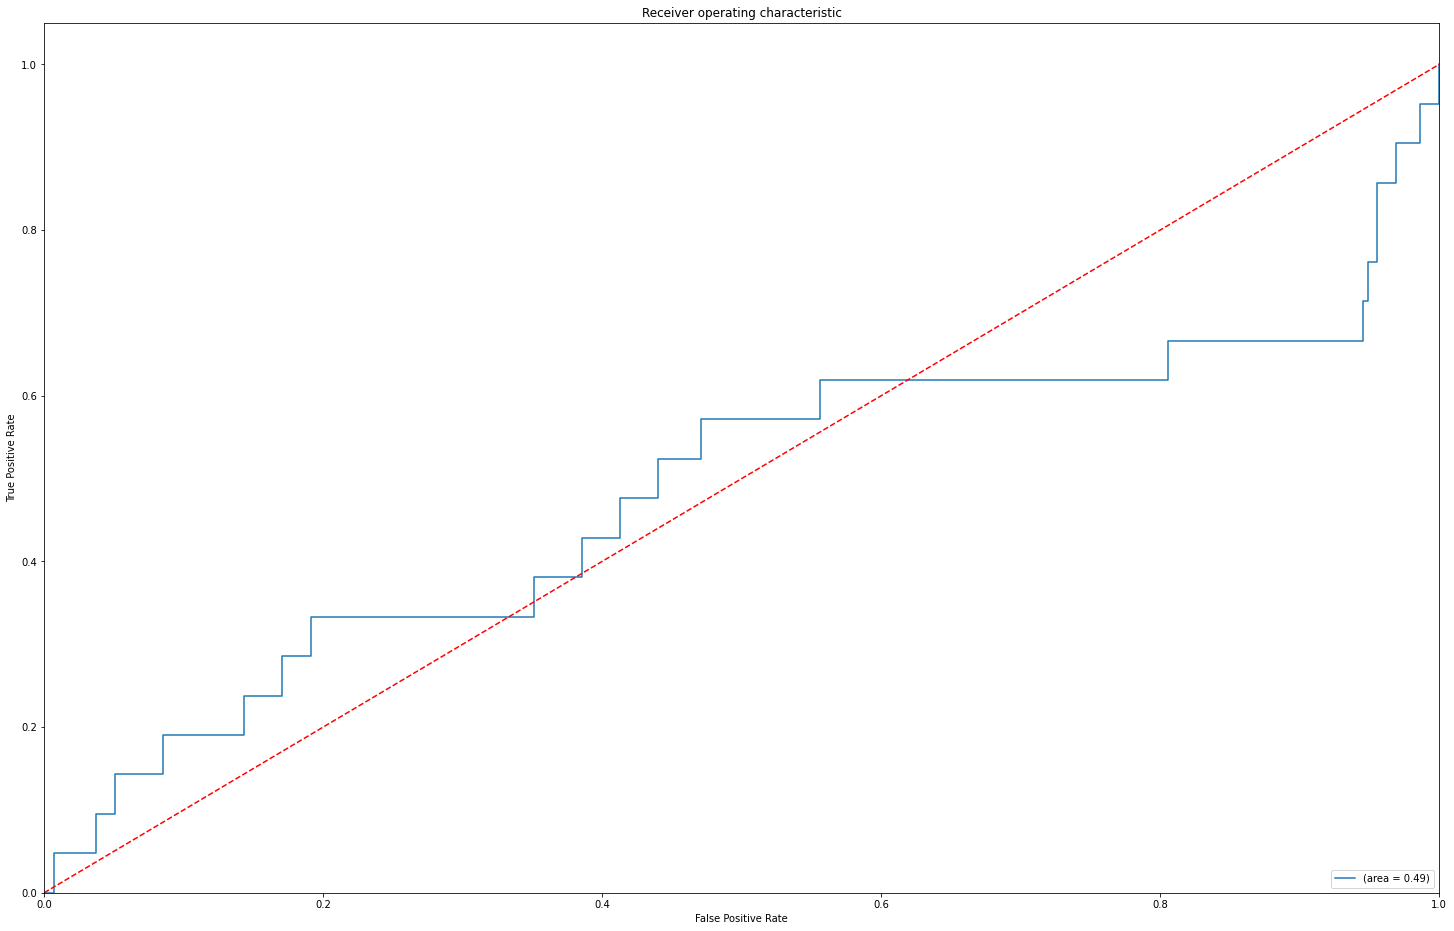


>>>>>>>>>>>LOGISTIC REGRESSION KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.7961783439490446
Recall Score:  [0.81911263 0.47619048]
Precision Score:  [0.9561753  0.15873016]
Specificity Score:  [0.81911263 0.47619048]
F1 Score:  [0.88235294 0.23809524]
ROC AUC:  0.6476515520884121
Test of confusion Matrix Scores
True Positives: 10
True Negatives: 240
False Positives: 53
False Negatives: 11
--------------------------------------------------
Accuracy: 0.8
Mis-Classification: 0.2
Sensitivity: 0.48
Specificity: 0.82
Precision: 0.16
Negative Predictive Value: 0.96
f_1 Score: 0.24
              precision    recall  f1-score   support

          -1       0.96      0.82      0.88       293
           1       0.16      0.48      0.24        21

    accuracy                           0.80       314
   macro avg       0.56      0.65      0.56       314
weighted avg       0.90      0.80      0.84       314



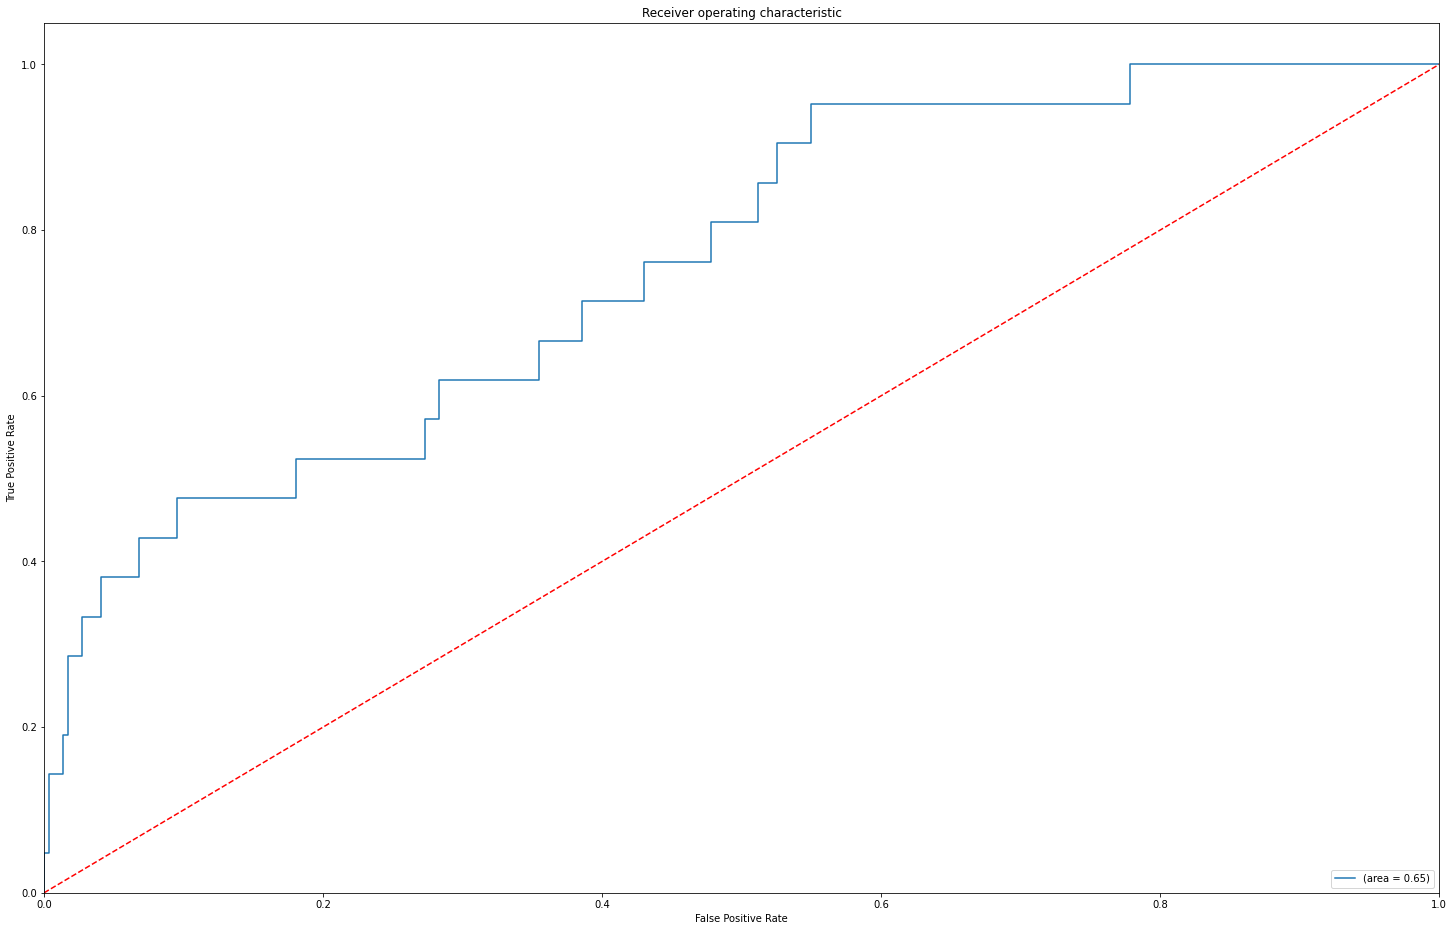


>>>>>>>>>>>LOGISTIC REGRESSION MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.7165605095541401
Recall Score:  [0.73720137 0.42857143]
Precision Score:  [0.94736842 0.10465116]
Specificity Score:  [0.73720137 0.42857143]
F1 Score:  [0.82917466 0.1682243 ]
ROC AUC:  0.582886396879571
Test of confusion Matrix Scores
True Positives: 9
True Negatives: 216
False Positives: 77
False Negatives: 12
--------------------------------------------------
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.43
Specificity: 0.74
Precision: 0.1
Negative Predictive Value: 0.95
f_1 Score: 0.17
              precision    recall  f1-score   support

          -1       0.95      0.74      0.83       293
           1       0.10      0.43      0.17        21

    accuracy                           0.72       314
   macro avg       0.53      0.58      0.50       314
weighted avg       0.89      0.72      0.78       314



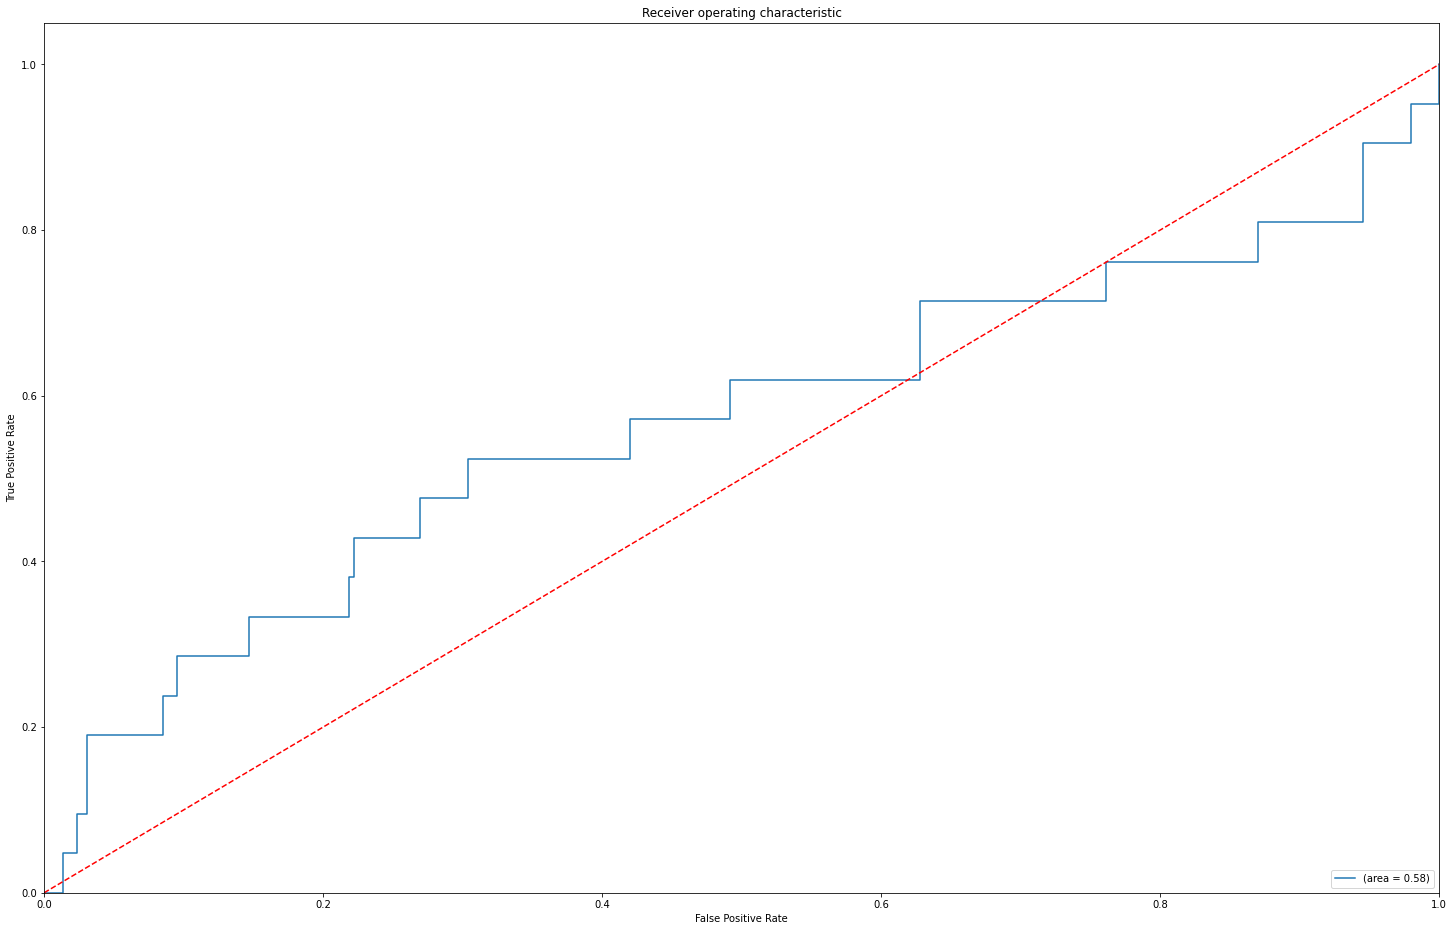

n---------------LOGISTIC REGRESSION WEIGHTED----------------


>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.678343949044586
Recall Score:  [0.67918089 0.66666667]
Precision Score:  [0.96601942 0.12962963]
Specificity Score:  [0.67918089 0.66666667]
F1 Score:  [0.79759519 0.21705426]
ROC AUC:  0.67292377701934
Test of confusion Matrix Scores
True Positives: 14
True Negatives: 199
False Positives: 94
False Negatives: 7
--------------------------------------------------
Accuracy: 0.68
Mis-Classification: 0.32
Sensitivity: 0.67
Specificity: 0.68
Precision: 0.13
Negative Predictive Value: 0.97
f_1 Score: 0.22
              precision    recall  f1-score   support

          -1       0.97      0.68      0.80       293
           1       0.13      0.67      0.22        21

    accuracy                           0.68       314
   macro avg       0.55      0.67      0.51       314
weighted avg       0.91      0.68      0.76       314



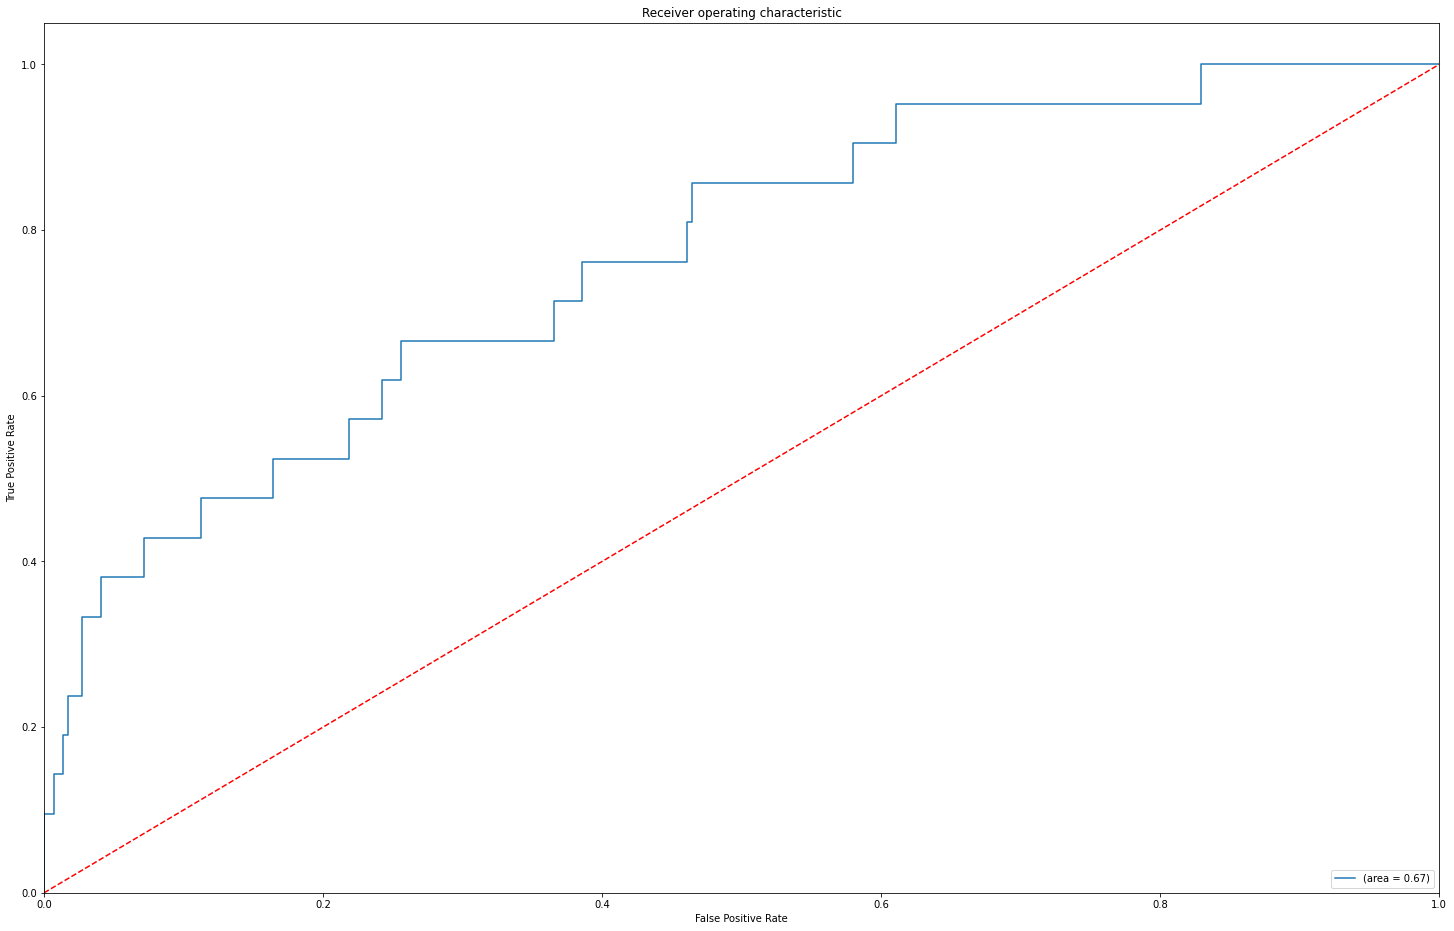


>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.4872611464968153
Recall Score:  [0.48122867 0.57142857]
Precision Score:  [0.94       0.07317073]
Specificity Score:  [0.48122867 0.57142857]
F1 Score:  [0.63656885 0.12972973]
ROC AUC:  0.5263286201852755
Test of confusion Matrix Scores
True Positives: 12
True Negatives: 141
False Positives: 152
False Negatives: 9
--------------------------------------------------
Accuracy: 0.49
Mis-Classification: 0.51
Sensitivity: 0.57
Specificity: 0.48
Precision: 0.07
Negative Predictive Value: 0.94
f_1 Score: 0.13
              precision    recall  f1-score   support

          -1       0.94      0.48      0.64       293
           1       0.07      0.57      0.13        21

    accuracy                           0.49       314
   macro avg       0.51      0.53      0.38       314
weighted avg       0.88      0.49      0.60       314



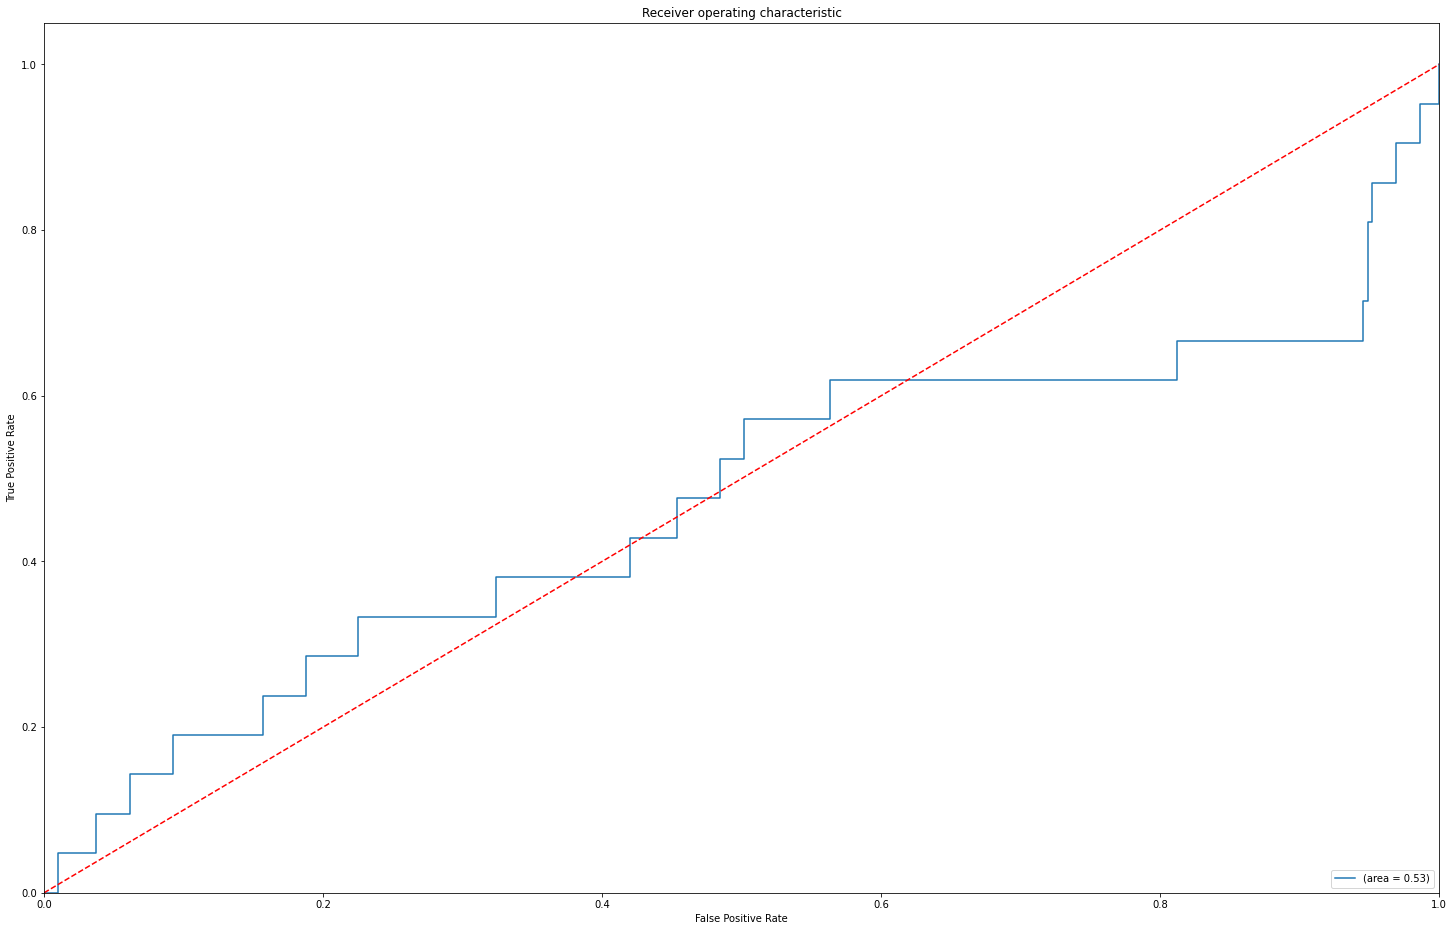


>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.678343949044586
Recall Score:  [0.67918089 0.66666667]
Precision Score:  [0.96601942 0.12962963]
Specificity Score:  [0.67918089 0.66666667]
F1 Score:  [0.79759519 0.21705426]
ROC AUC:  0.67292377701934
Test of confusion Matrix Scores
True Positives: 14
True Negatives: 199
False Positives: 94
False Negatives: 7
--------------------------------------------------
Accuracy: 0.68
Mis-Classification: 0.32
Sensitivity: 0.67
Specificity: 0.68
Precision: 0.13
Negative Predictive Value: 0.97
f_1 Score: 0.22
              precision    recall  f1-score   support

          -1       0.97      0.68      0.80       293
           1       0.13      0.67      0.22        21

    accuracy                           0.68       314
   macro avg       0.55      0.67      0.51       314
weighted avg       0.91      0.68      0.76       314



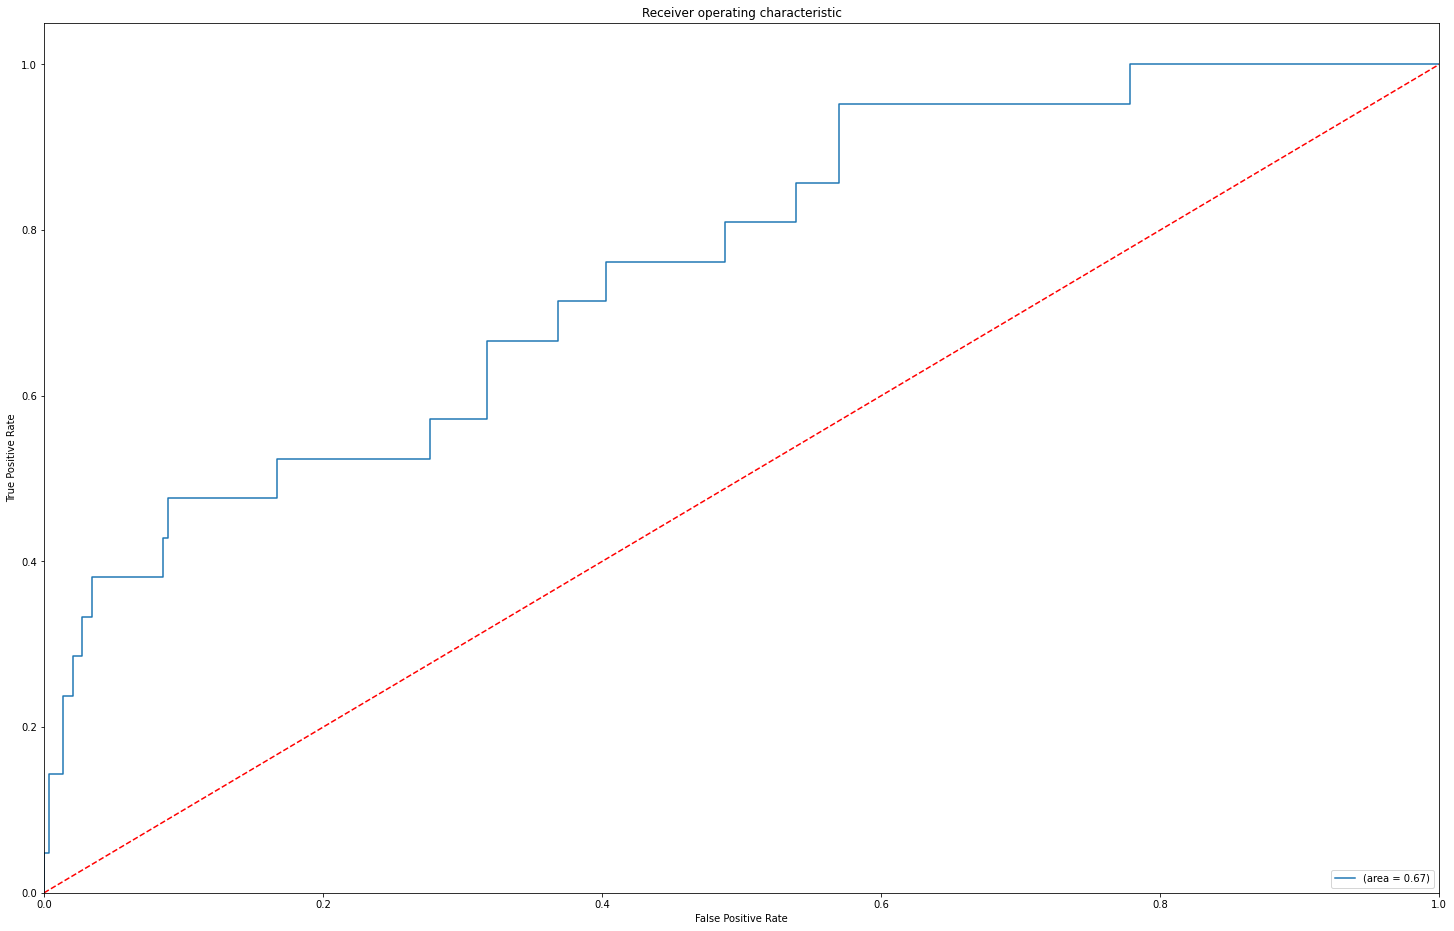


>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.4554140127388535
Recall Score:  [0.44368601 0.61904762]
Precision Score:  [0.94202899 0.07386364]
Specificity Score:  [0.44368601 0.61904762]
F1 Score:  [0.60324826 0.1319797 ]
ROC AUC:  0.5313668129367789
Test of confusion Matrix Scores
True Positives: 13
True Negatives: 130
False Positives: 163
False Negatives: 8
--------------------------------------------------
Accuracy: 0.46
Mis-Classification: 0.54
Sensitivity: 0.62
Specificity: 0.44
Precision: 0.07
Negative Predictive Value: 0.94
f_1 Score: 0.13
              precision    recall  f1-score   support

          -1       0.94      0.44      0.60       293
           1       0.07      0.62      0.13        21

    accuracy                           0.46       314
   macro avg       0.51      0.53      0.37       314
weighted avg       0.88      0.46      0.57       314



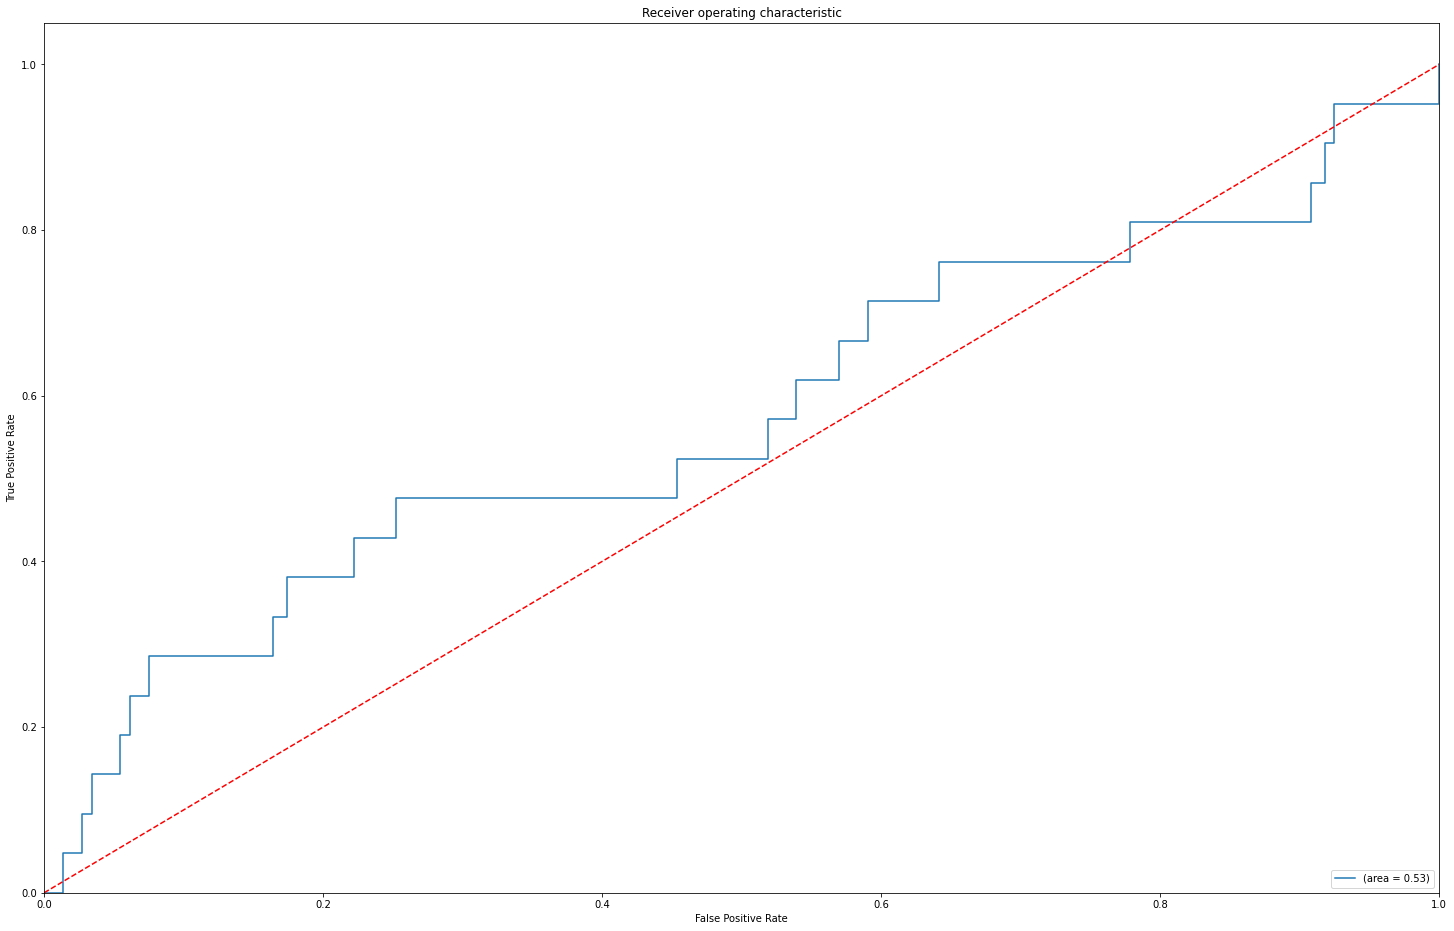

n-------------K-NEAREST NEIGHBORS-------------------


>>>>>>>>>>>KNN  KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.7707006369426752
Recall Score:  [0.79522184 0.42857143]
Precision Score:  [0.95102041 0.13043478]
Specificity Score:  [0.79522184 0.42857143]
F1 Score:  [0.866171 0.2     ]
ROC AUC:  0.6118966357874208
Test of confusion Matrix Scores
True Positives: 9
True Negatives: 233
False Positives: 60
False Negatives: 12
--------------------------------------------------
Accuracy: 0.77
Mis-Classification: 0.23
Sensitivity: 0.43
Specificity: 0.8
Precision: 0.13
Negative Predictive Value: 0.95
f_1 Score: 0.2
              precision    recall  f1-score   support

          -1       0.95      0.80      0.87       293
           1       0.13      0.43      0.20        21

    accuracy                           0.77       314
   macro avg       0.54      0.61      0.53       314
weighted avg       0.90      0.77      0.82       314



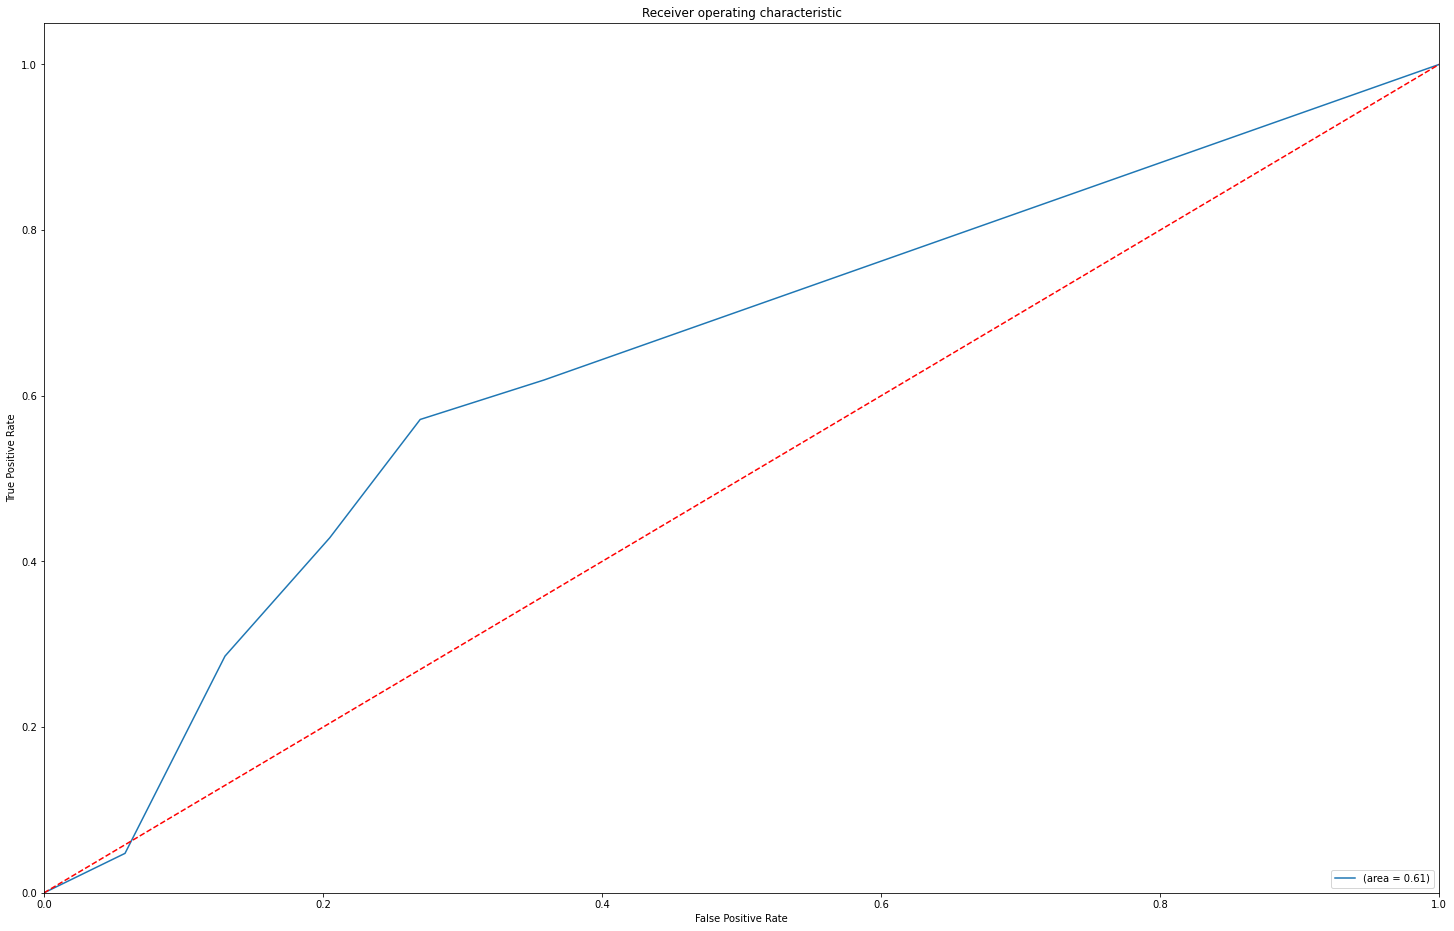


>>>>>>>>>>>KNN  MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.7643312101910829
Recall Score:  [0.79522184 0.33333333]
Precision Score:  [0.94331984 0.10447761]
Specificity Score:  [0.79522184 0.33333333]
F1 Score:  [0.86296296 0.15909091]
ROC AUC:  0.5642775881683731
Test of confusion Matrix Scores
True Positives: 7
True Negatives: 233
False Positives: 60
False Negatives: 14
--------------------------------------------------
Accuracy: 0.76
Mis-Classification: 0.24
Sensitivity: 0.33
Specificity: 0.8
Precision: 0.1
Negative Predictive Value: 0.94
f_1 Score: 0.16
              precision    recall  f1-score   support

          -1       0.94      0.80      0.86       293
           1       0.10      0.33      0.16        21

    accuracy                           0.76       314
   macro avg       0.52      0.56      0.51       314
weighted avg       0.89      0.76      0.82       314



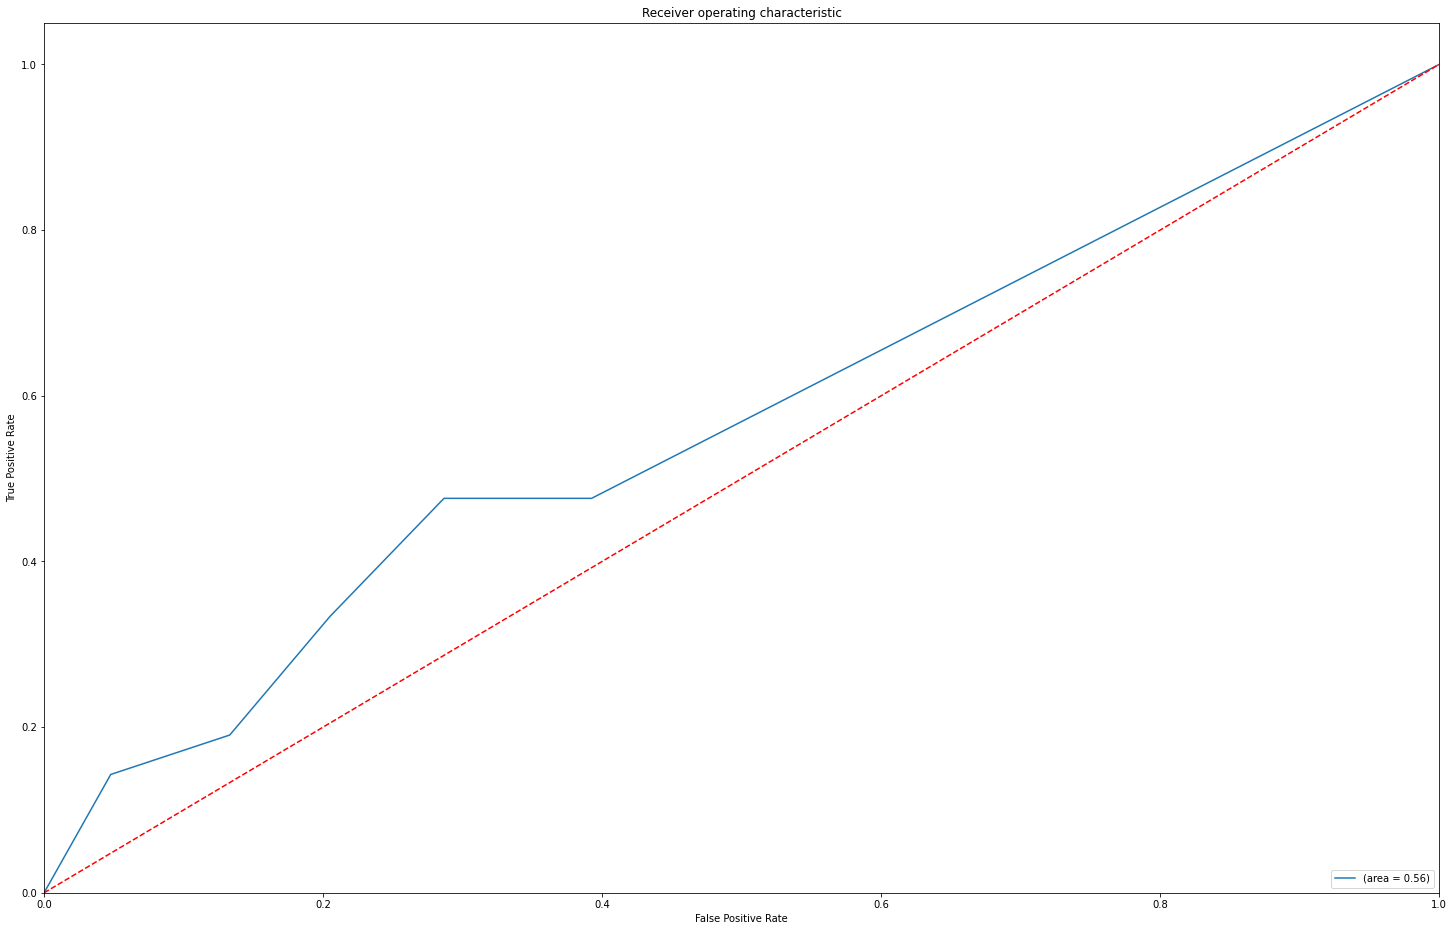


>>>>>>>>>>>KNN  KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.802547770700637
Recall Score:  [0.84300341 0.23809524]
Precision Score:  [0.9391635  0.09803922]
Specificity Score:  [0.84300341 0.23809524]
F1 Score:  [0.88848921 0.13888889]
ROC AUC:  0.5405493255322606
Test of confusion Matrix Scores
True Positives: 5
True Negatives: 247
False Positives: 46
False Negatives: 16
--------------------------------------------------
Accuracy: 0.8
Mis-Classification: 0.2
Sensitivity: 0.24
Specificity: 0.84
Precision: 0.1
Negative Predictive Value: 0.94
f_1 Score: 0.14
              precision    recall  f1-score   support

          -1       0.94      0.84      0.89       293
           1       0.10      0.24      0.14        21

    accuracy                           0.80       314
   macro avg       0.52      0.54      0.51       314
weighted avg       0.88      0.80      0.84       314



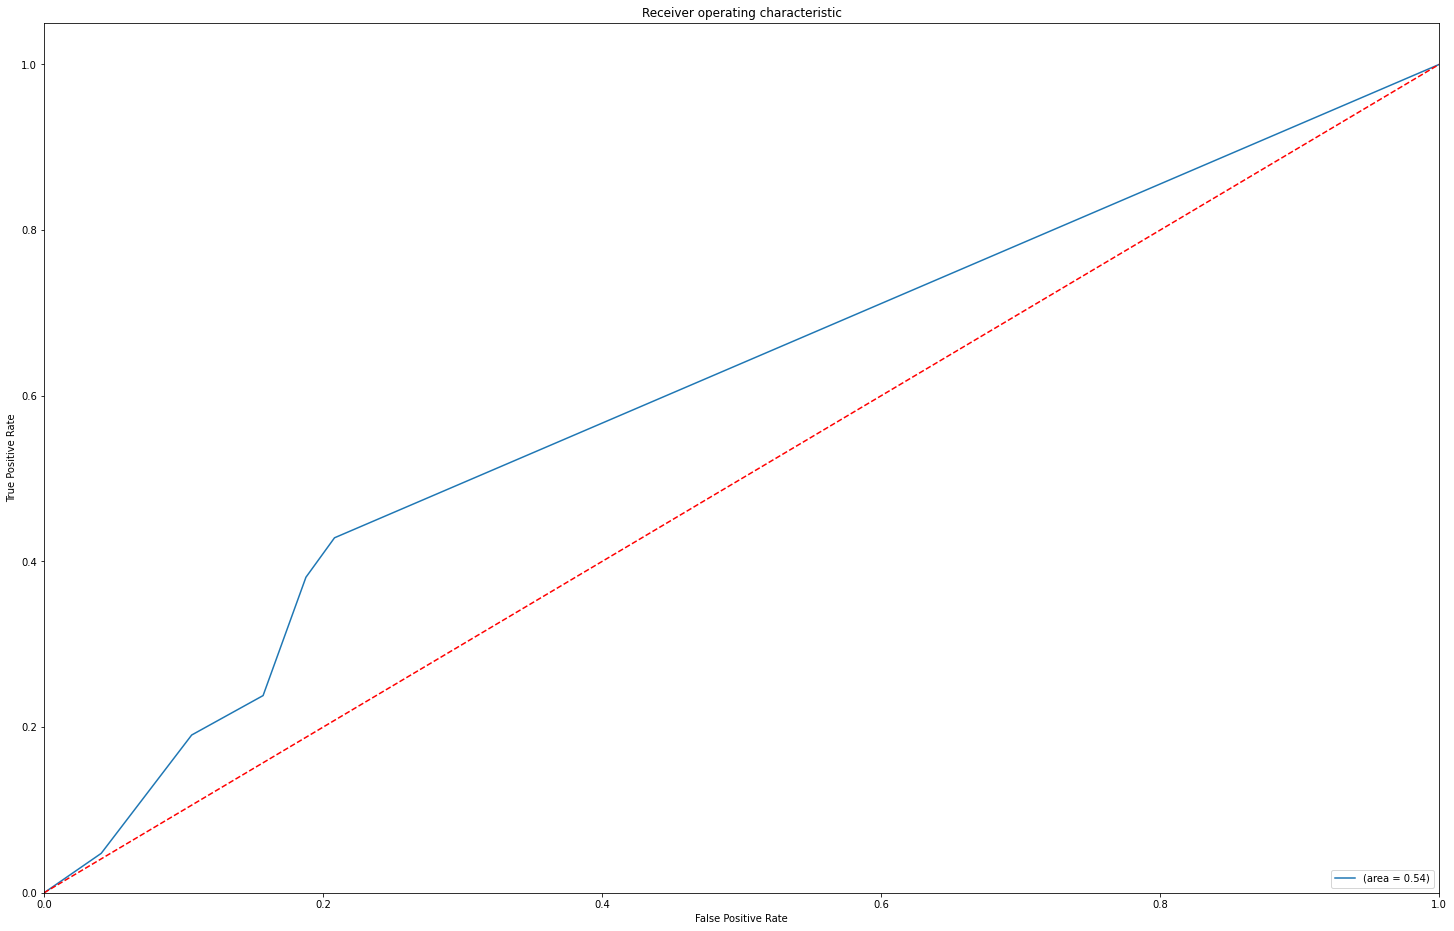


>>>>>>>>>>>KNN  MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.8184713375796179
Recall Score:  [0.85665529 0.28571429]
Precision Score:  [0.94360902 0.125     ]
Specificity Score:  [0.85665529 0.28571429]
F1 Score:  [0.8980322  0.17391304]
ROC AUC:  0.5711847879083373
Test of confusion Matrix Scores
True Positives: 6
True Negatives: 251
False Positives: 42
False Negatives: 15
--------------------------------------------------
Accuracy: 0.82
Mis-Classification: 0.18
Sensitivity: 0.29
Specificity: 0.86
Precision: 0.12
Negative Predictive Value: 0.94
f_1 Score: 0.17
              precision    recall  f1-score   support

          -1       0.94      0.86      0.90       293
           1       0.12      0.29      0.17        21

    accuracy                           0.82       314
   macro avg       0.53      0.57      0.54       314
weighted avg       0.89      0.82      0.85       314



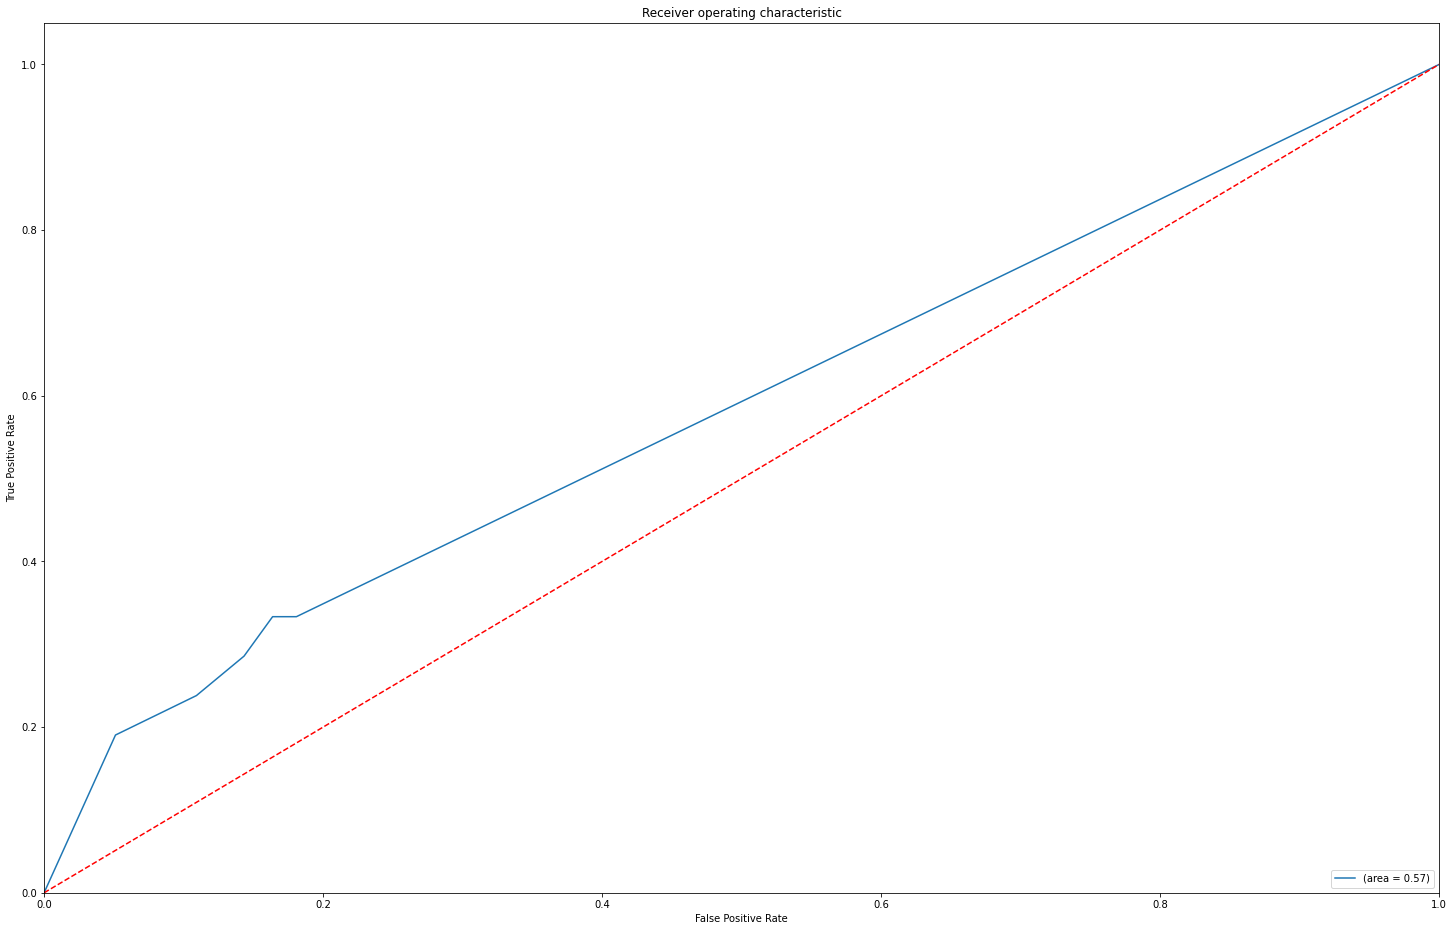

n------------SUPPORT VECTOR MACHINE----------------


>>>>>>>>>>>SVM  KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.8821656050955414
Recall Score:  [0.92491468 0.28571429]
Precision Score:  [0.94755245 0.21428571]
Specificity Score:  [0.92491468 0.28571429]
F1 Score:  [0.93609672 0.24489796]
ROC AUC:  0.6053144807411018
Test of confusion Matrix Scores
True Positives: 6
True Negatives: 271
False Positives: 22
False Negatives: 15
--------------------------------------------------
Accuracy: 0.88
Mis-Classification: 0.12
Sensitivity: 0.29
Specificity: 0.92
Precision: 0.21
Negative Predictive Value: 0.95
f_1 Score: 0.24
              precision    recall  f1-score   support

          -1       0.95      0.92      0.94       293
           1       0.21      0.29      0.24        21

    accuracy                           0.88       314
   macro avg       0.58      0.61      0.59       314
weighted avg       0.90      0.88      0.89       314



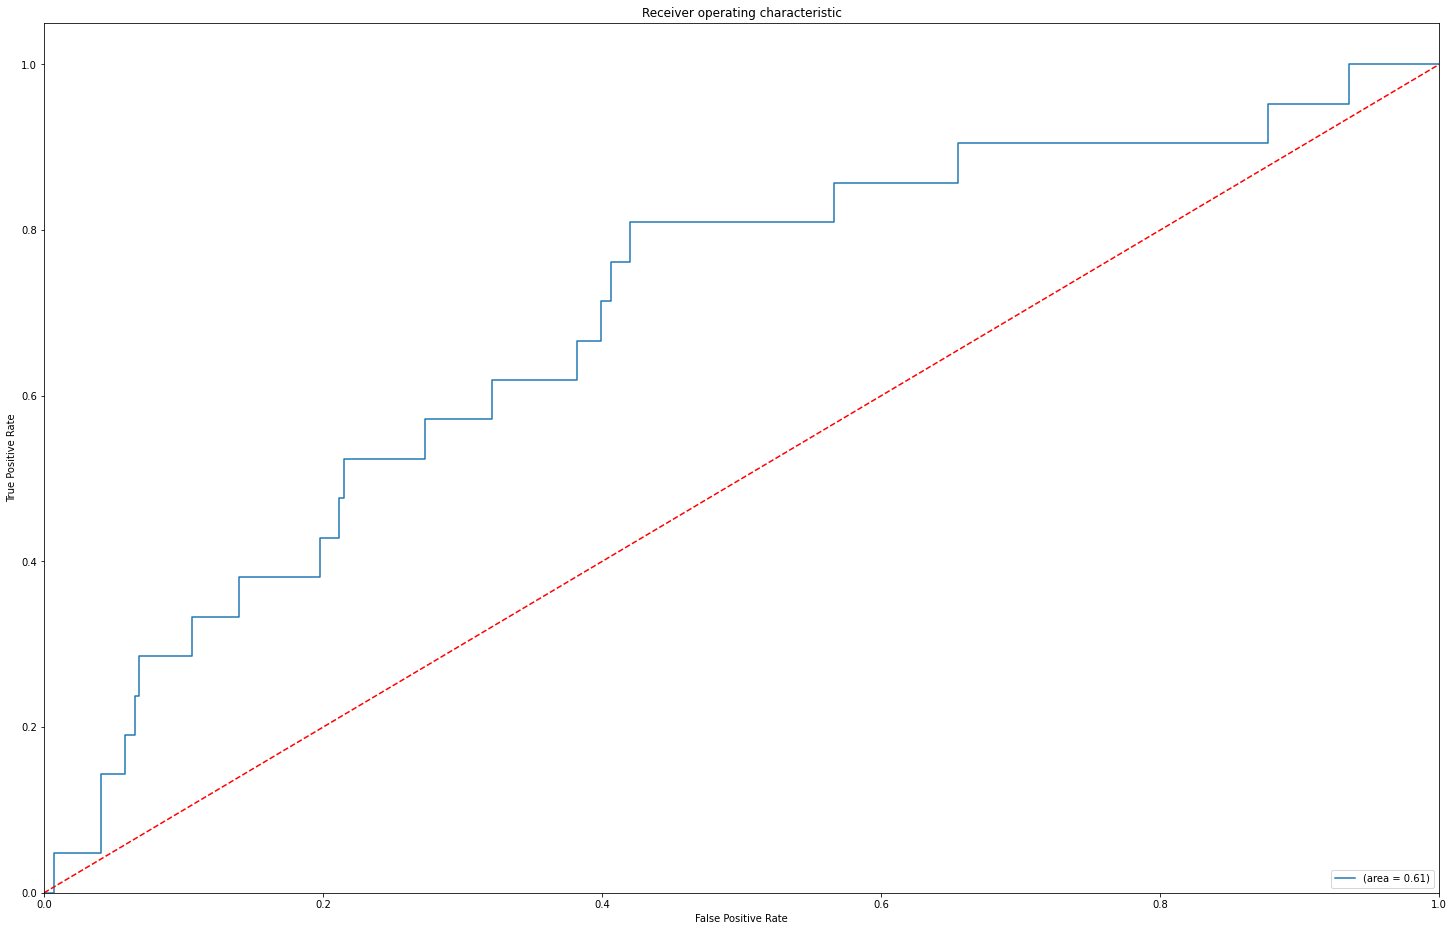


>>>>>>>>>>>SVM  MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.7993630573248408
Recall Score:  [0.83276451 0.33333333]
Precision Score:  [0.94573643 0.125     ]
Specificity Score:  [0.83276451 0.33333333]
F1 Score:  [0.88566243 0.18181818]
ROC AUC:  0.5830489192263936
Test of confusion Matrix Scores
True Positives: 7
True Negatives: 244
False Positives: 49
False Negatives: 14
--------------------------------------------------
Accuracy: 0.8
Mis-Classification: 0.2
Sensitivity: 0.33
Specificity: 0.83
Precision: 0.12
Negative Predictive Value: 0.95
f_1 Score: 0.18
              precision    recall  f1-score   support

          -1       0.95      0.83      0.89       293
           1       0.12      0.33      0.18        21

    accuracy                           0.80       314
   macro avg       0.54      0.58      0.53       314
weighted avg       0.89      0.80      0.84       314



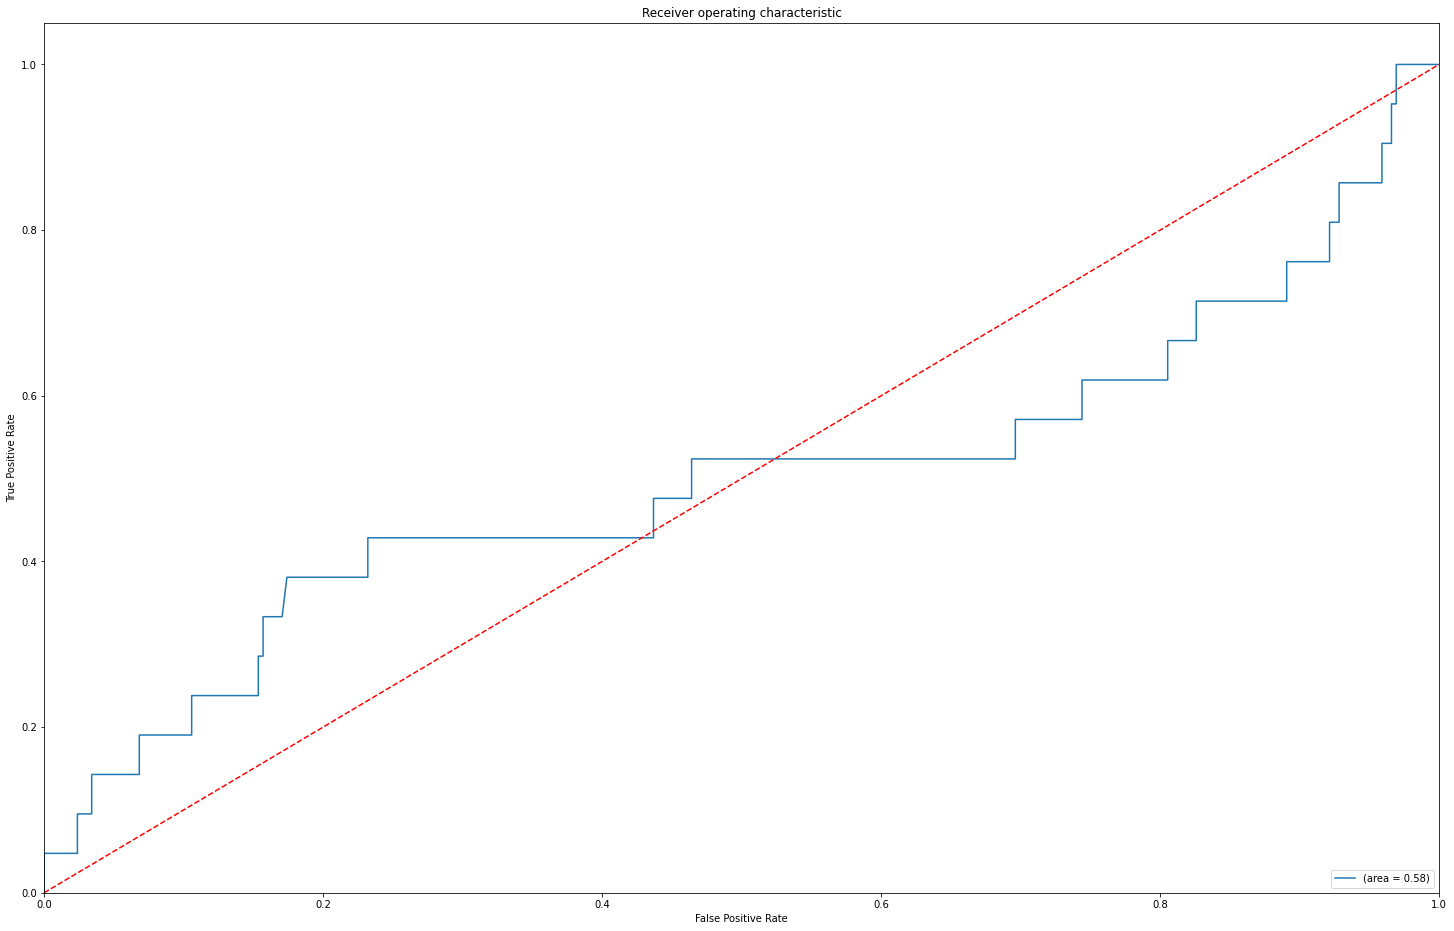


>>>>>>>>>>>SVM  KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.8312101910828026
Recall Score:  [0.86348123 0.38095238]
Precision Score:  [0.95112782 0.16666667]
Specificity Score:  [0.86348123 0.38095238]
F1 Score:  [0.90518784 0.23188406]
ROC AUC:  0.6222168048106614
Test of confusion Matrix Scores
True Positives: 8
True Negatives: 253
False Positives: 40
False Negatives: 13
--------------------------------------------------
Accuracy: 0.83
Mis-Classification: 0.17
Sensitivity: 0.38
Specificity: 0.86
Precision: 0.17
Negative Predictive Value: 0.95
f_1 Score: 0.23
              precision    recall  f1-score   support

          -1       0.95      0.86      0.91       293
           1       0.17      0.38      0.23        21

    accuracy                           0.83       314
   macro avg       0.56      0.62      0.57       314
weighted avg       0.90      0.83      0.86       314



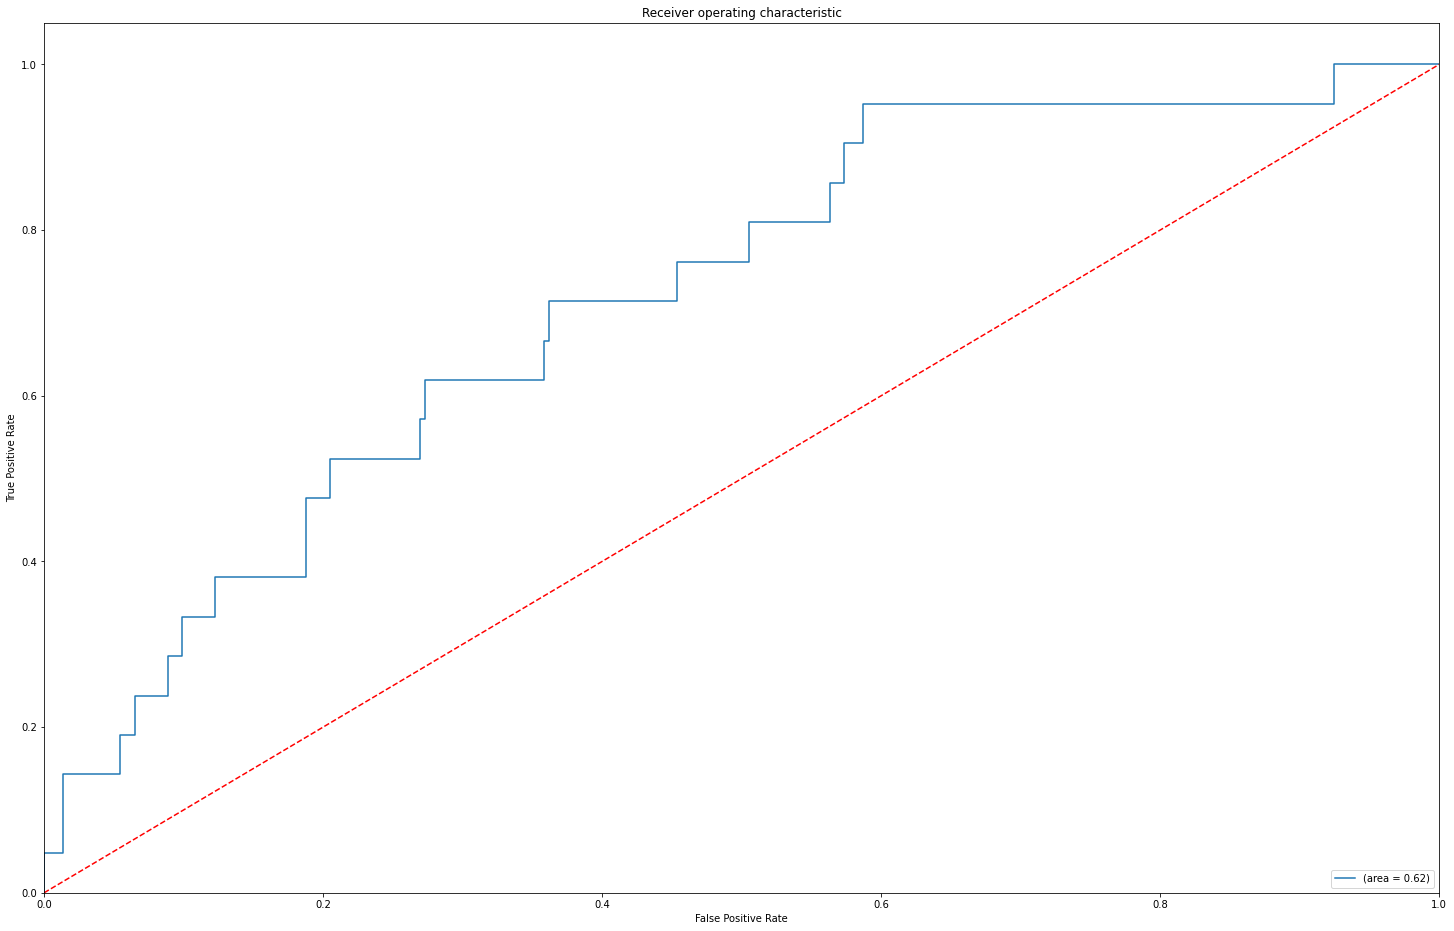


>>>>>>>>>>>SVM  MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.7929936305732485
Recall Score:  [0.82593857 0.33333333]
Precision Score:  [0.9453125  0.12068966]
Specificity Score:  [0.82593857 0.33333333]
F1 Score:  [0.88160291 0.17721519]
ROC AUC:  0.5796359499431171
Test of confusion Matrix Scores
True Positives: 7
True Negatives: 242
False Positives: 51
False Negatives: 14
--------------------------------------------------
Accuracy: 0.79
Mis-Classification: 0.21
Sensitivity: 0.33
Specificity: 0.83
Precision: 0.12
Negative Predictive Value: 0.95
f_1 Score: 0.18
              precision    recall  f1-score   support

          -1       0.95      0.83      0.88       293
           1       0.12      0.33      0.18        21

    accuracy                           0.79       314
   macro avg       0.53      0.58      0.53       314
weighted avg       0.89      0.79      0.83       314



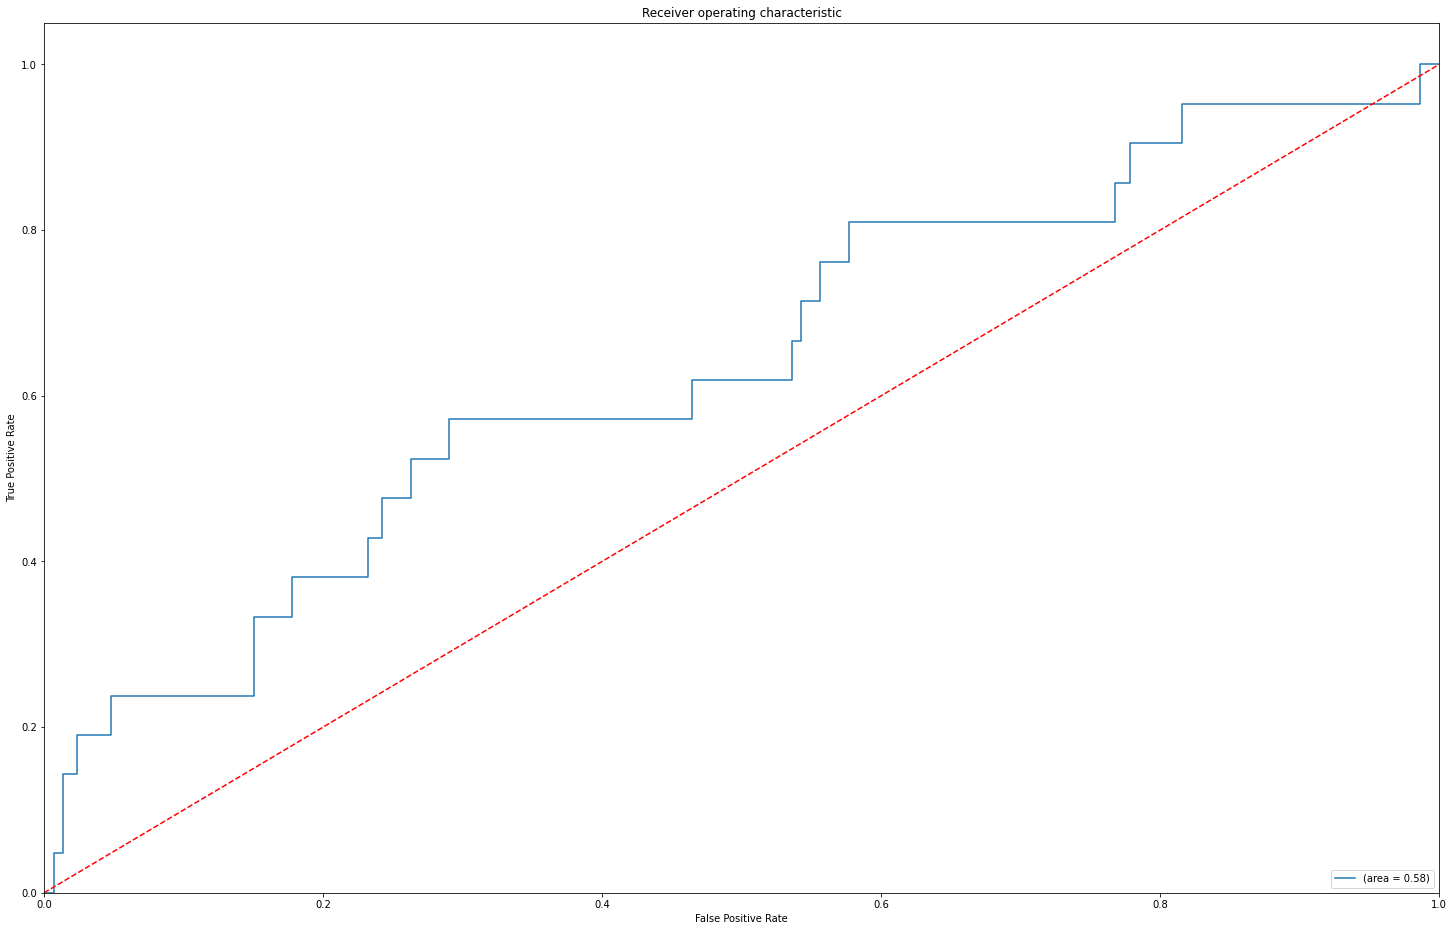

n-----------------NAIVE BAYES----------------------


>>>>>>>>>>>NAIVE BAYES  KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.7707006369426752
Recall Score:  [0.79863481 0.38095238]
Precision Score:  [0.94736842 0.11940299]
Specificity Score:  [0.79863481 0.38095238]
F1 Score:  [0.86666667 0.18181818]
ROC AUC:  0.5897935966195351
Test of confusion Matrix Scores
True Positives: 8
True Negatives: 234
False Positives: 59
False Negatives: 13
--------------------------------------------------
Accuracy: 0.77
Mis-Classification: 0.23
Sensitivity: 0.38
Specificity: 0.8
Precision: 0.12
Negative Predictive Value: 0.95
f_1 Score: 0.18
              precision    recall  f1-score   support

          -1       0.95      0.80      0.87       293
           1       0.12      0.38      0.18        21

    accuracy                           0.77       314
   macro avg       0.53      0.59      0.52       314
weighted avg       0.89      0.77      0.82       314



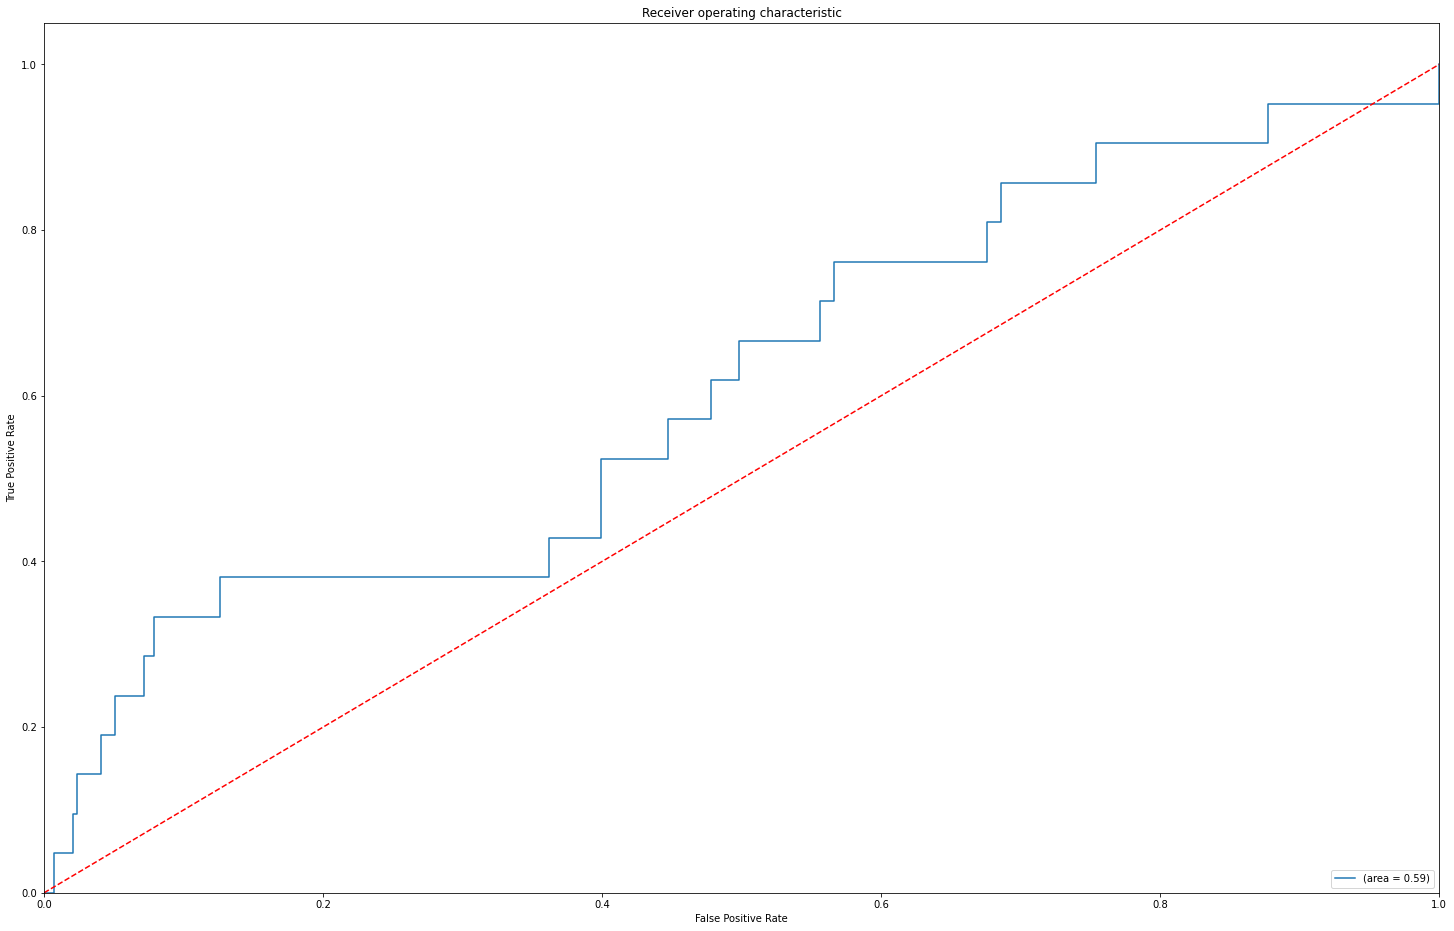


>>>>>>>>>>>NAIVE BAYES  MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.7197452229299363
Recall Score:  [0.74744027 0.33333333]
Precision Score:  [0.93991416 0.08641975]
Specificity Score:  [0.74744027 0.33333333]
F1 Score:  [0.83269962 0.1372549 ]
ROC AUC:  0.540386803185438
Test of confusion Matrix Scores
True Positives: 7
True Negatives: 219
False Positives: 74
False Negatives: 14
--------------------------------------------------
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.33
Specificity: 0.75
Precision: 0.09
Negative Predictive Value: 0.94
f_1 Score: 0.14
              precision    recall  f1-score   support

          -1       0.94      0.75      0.83       293
           1       0.09      0.33      0.14        21

    accuracy                           0.72       314
   macro avg       0.51      0.54      0.48       314
weighted avg       0.88      0.72      0.79       314



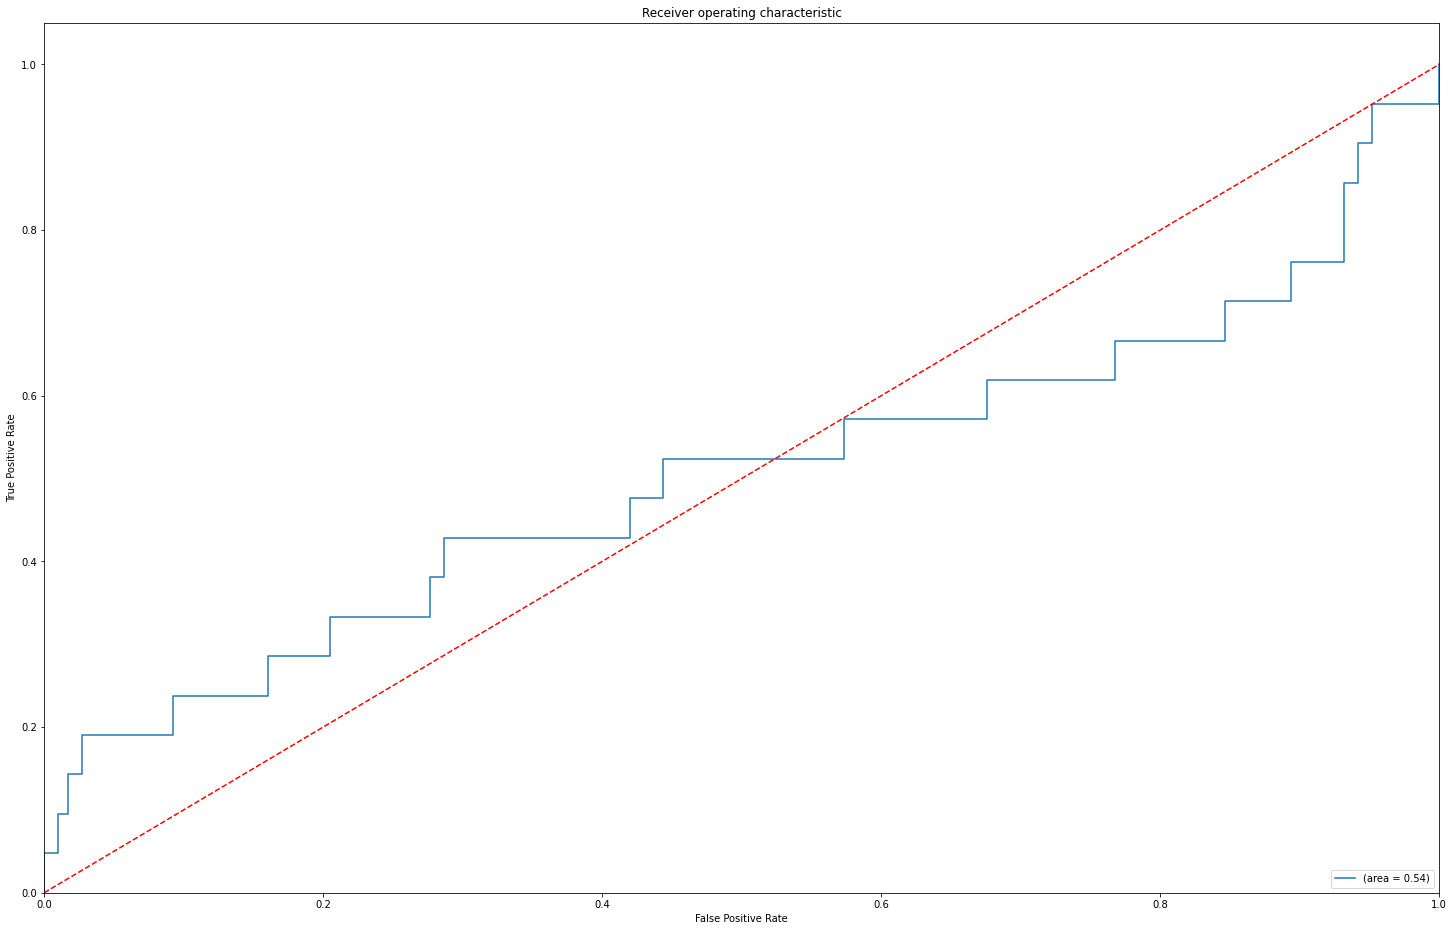


>>>>>>>>>>>NAIVE BAYES  KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.7165605095541401
Recall Score:  [0.7337884  0.47619048]
Precision Score:  [0.95132743 0.11363636]
Specificity Score:  [0.7337884  0.47619048]
F1 Score:  [0.82851638 0.18348624]
ROC AUC:  0.6049894360474566
Test of confusion Matrix Scores
True Positives: 10
True Negatives: 215
False Positives: 78
False Negatives: 11
--------------------------------------------------
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.48
Specificity: 0.73
Precision: 0.11
Negative Predictive Value: 0.95
f_1 Score: 0.18
              precision    recall  f1-score   support

          -1       0.95      0.73      0.83       293
           1       0.11      0.48      0.18        21

    accuracy                           0.72       314
   macro avg       0.53      0.60      0.51       314
weighted avg       0.90      0.72      0.79       314



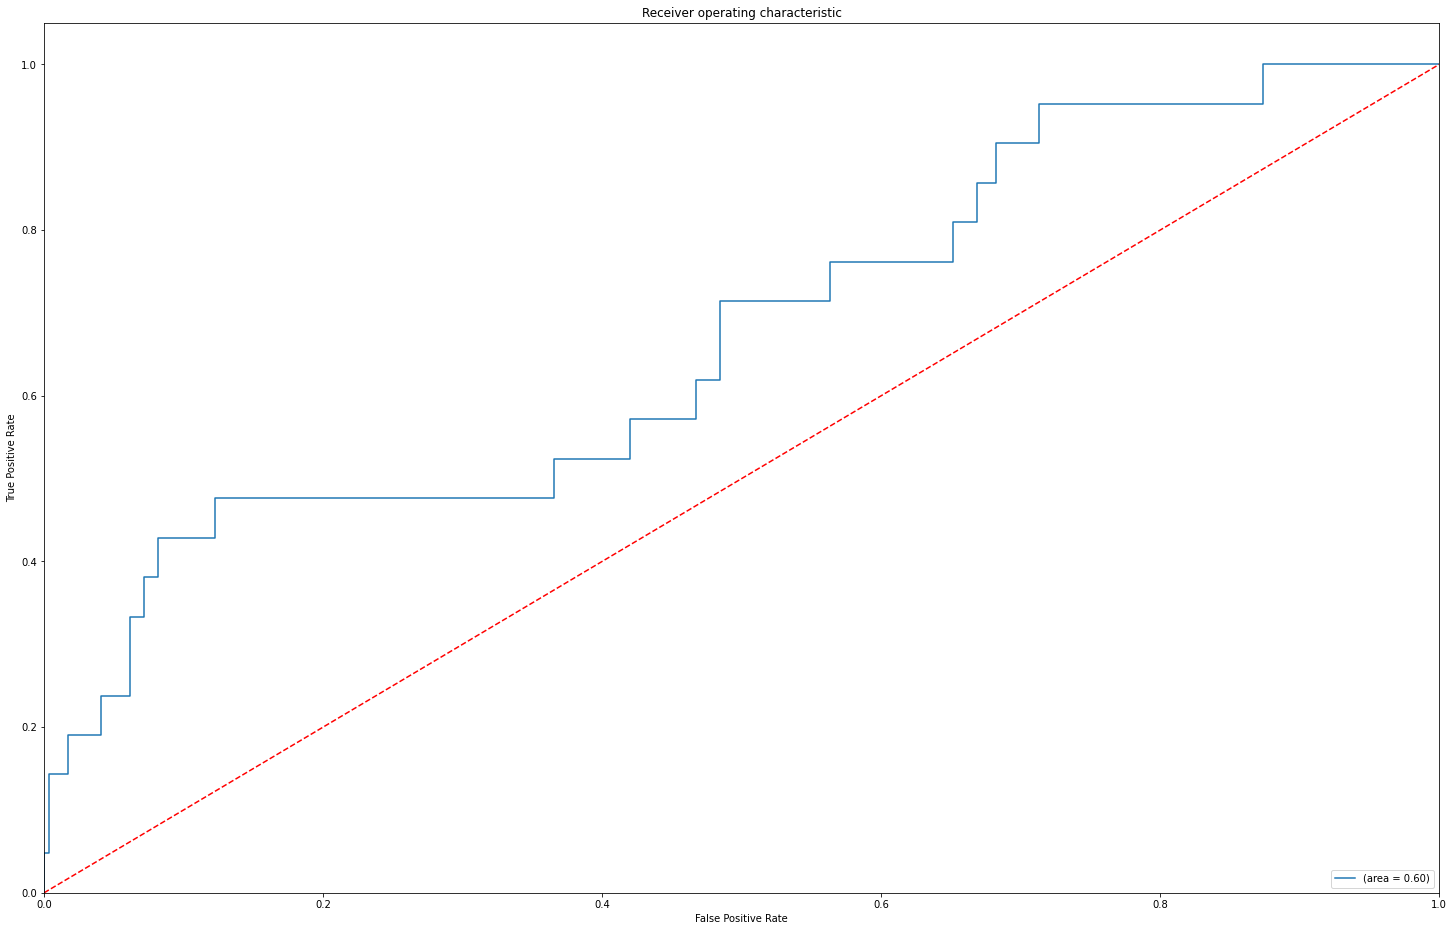


>>>>>>>>>>>NAIVE BAYES  MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.5191082802547771
Recall Score:  [0.49488055 0.85714286]
Precision Score:  [0.97972973 0.10843373]
Specificity Score:  [0.49488055 0.85714286]
F1 Score:  [0.65759637 0.19251337]
ROC AUC:  0.6760117016089713
Test of confusion Matrix Scores
True Positives: 18
True Negatives: 145
False Positives: 148
False Negatives: 3
--------------------------------------------------
Accuracy: 0.52
Mis-Classification: 0.48
Sensitivity: 0.86
Specificity: 0.49
Precision: 0.11
Negative Predictive Value: 0.98
f_1 Score: 0.19
              precision    recall  f1-score   support

          -1       0.98      0.49      0.66       293
           1       0.11      0.86      0.19        21

    accuracy                           0.52       314
   macro avg       0.54      0.68      0.43       314
weighted avg       0.92      0.52      0.63       314



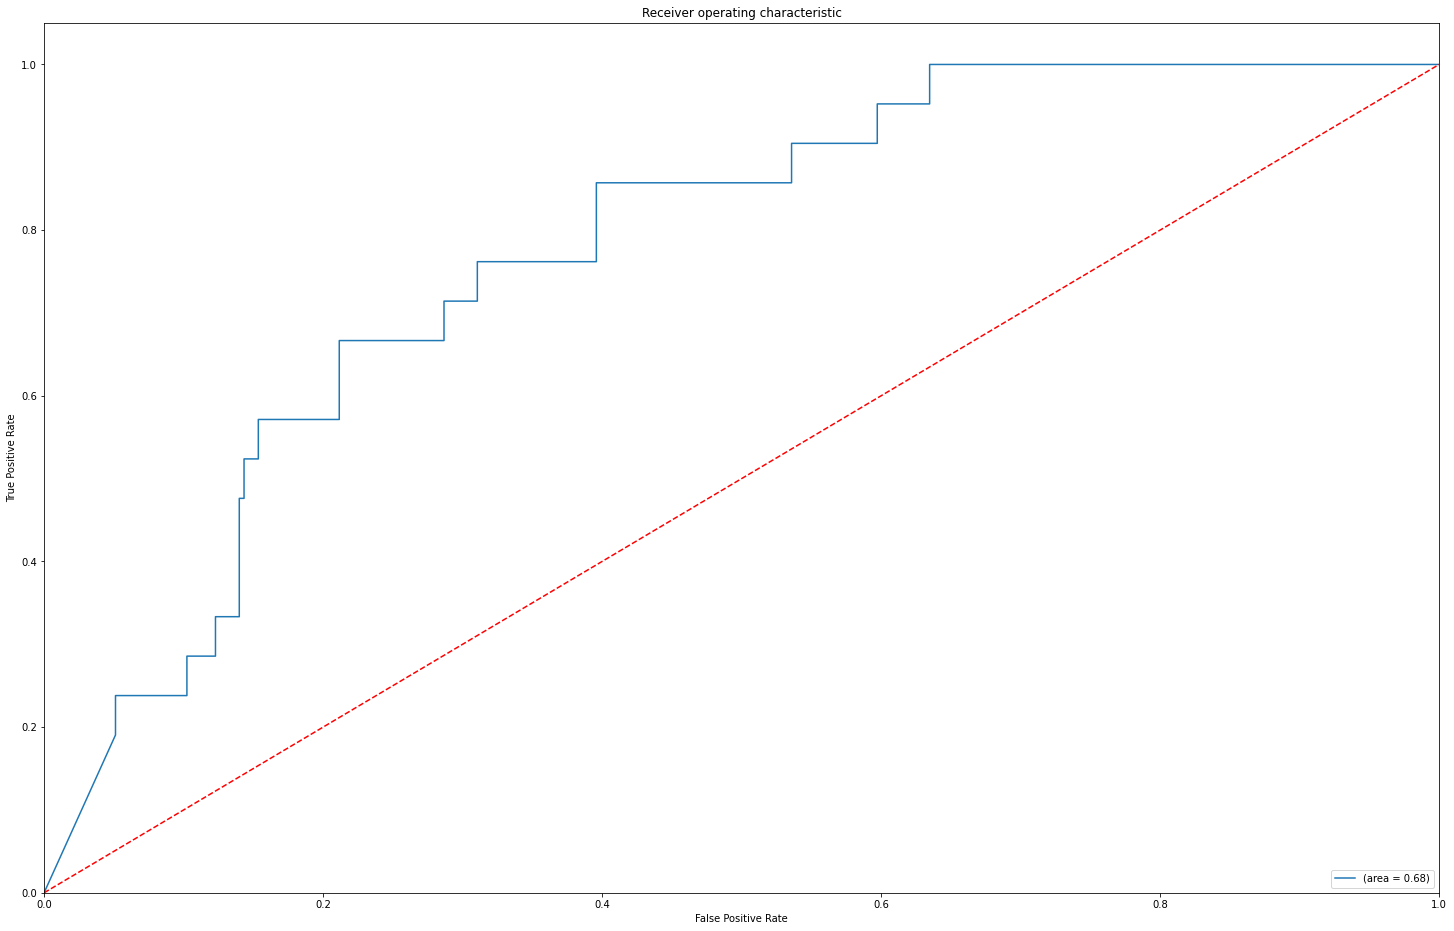

n-----------------DECISION TREE--------------------


>>>>>>>>>>>DECISION TREE CLASSIFIER  KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.8280254777070064
Recall Score:  [0.87372014 0.19047619]
Precision Score:  [0.93772894 0.09756098]
Specificity Score:  [0.87372014 0.19047619]
F1 Score:  [0.90459364 0.12903226]
ROC AUC:  0.5320981634974808
Test of confusion Matrix Scores
True Positives: 4
True Negatives: 256
False Positives: 37
False Negatives: 17
--------------------------------------------------
Accuracy: 0.83
Mis-Classification: 0.17
Sensitivity: 0.19
Specificity: 0.87
Precision: 0.1
Negative Predictive Value: 0.94
f_1 Score: 0.13
              precision    recall  f1-score   support

          -1       0.94      0.87      0.90       293
           1       0.10      0.19      0.13        21

    accuracy                           0.83       314
   macro avg       0.52      0.53      0.52       314
weighted avg       0.88      0.83      0.85       314



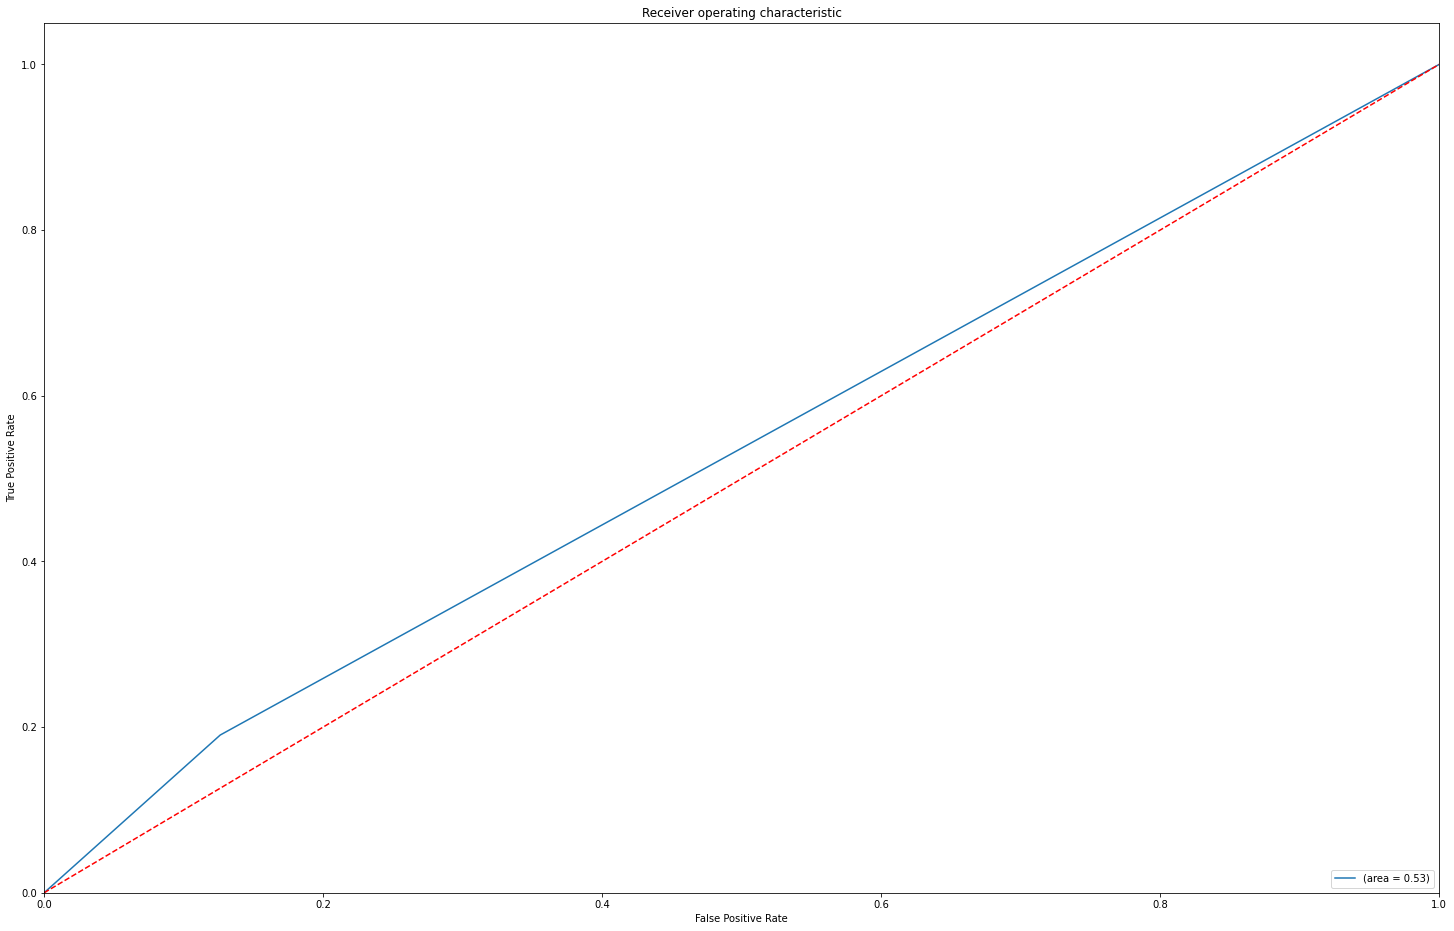


>>>>>>>>>>>DECISION TREE CLASSIFIER  MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.8407643312101911
Recall Score:  [0.88395904 0.23809524]
Precision Score:  [0.94181818 0.12820513]
Specificity Score:  [0.88395904 0.23809524]
F1 Score:  [0.91197183 0.16666667]
ROC AUC:  0.5610271412319194
Test of confusion Matrix Scores
True Positives: 5
True Negatives: 259
False Positives: 34
False Negatives: 16
--------------------------------------------------
Accuracy: 0.84
Mis-Classification: 0.16
Sensitivity: 0.24
Specificity: 0.88
Precision: 0.13
Negative Predictive Value: 0.94
f_1 Score: 0.17
              precision    recall  f1-score   support

          -1       0.94      0.88      0.91       293
           1       0.13      0.24      0.17        21

    accuracy                           0.84       314
   macro avg       0.54      0.56      0.54       314
weighted avg       0.89      0.84      0.86       314



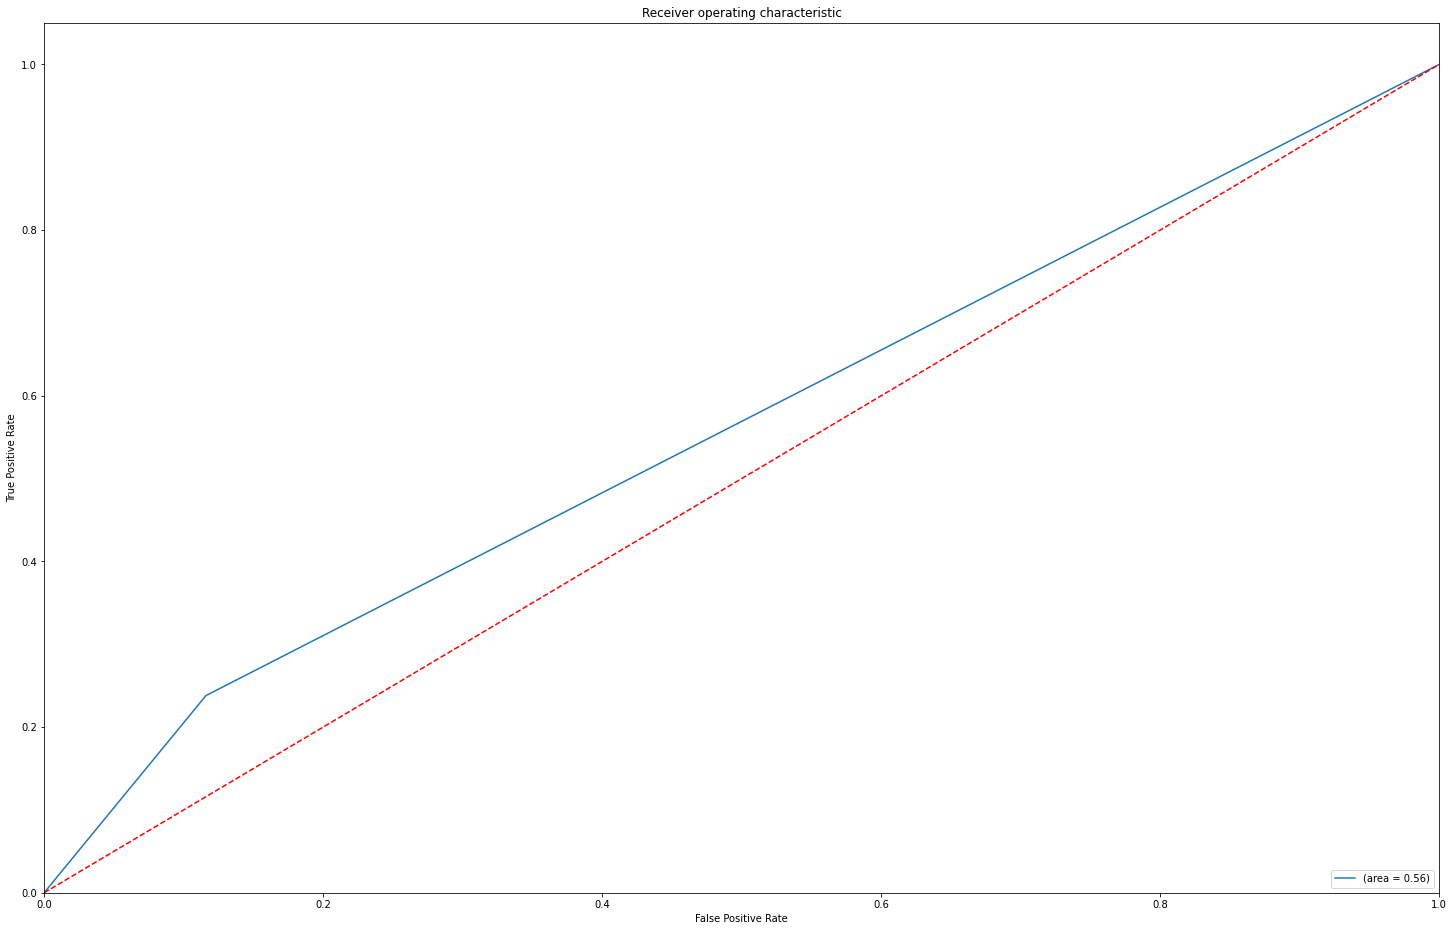


>>>>>>>>>>>DECISION TREE CLASSIFIER  KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.9076433121019108
Recall Score:  [0.96245734 0.14285714]
Precision Score:  [0.94       0.21428571]
Specificity Score:  [0.96245734 0.14285714]
F1 Score:  [0.95109612 0.17142857]
ROC AUC:  0.5526572403705509
Test of confusion Matrix Scores
True Positives: 3
True Negatives: 282
False Positives: 11
False Negatives: 18
--------------------------------------------------
Accuracy: 0.91
Mis-Classification: 0.09
Sensitivity: 0.14
Specificity: 0.96
Precision: 0.21
Negative Predictive Value: 0.94
f_1 Score: 0.17
              precision    recall  f1-score   support

          -1       0.94      0.96      0.95       293
           1       0.21      0.14      0.17        21

    accuracy                           0.91       314
   macro avg       0.58      0.55      0.56       314
weighted avg       0.89      0.91      0.90       314



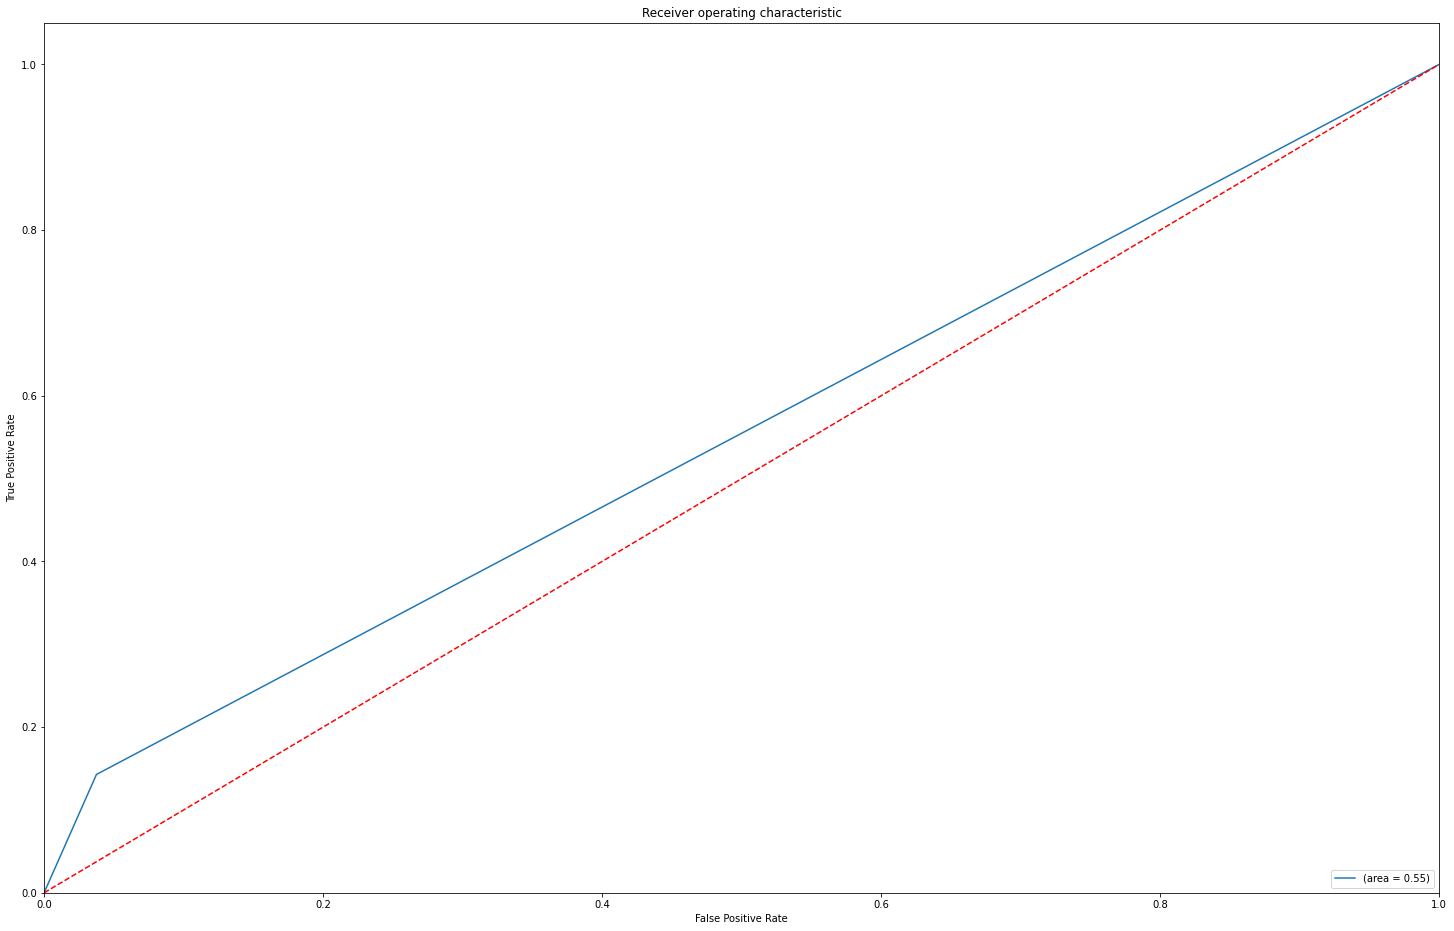


>>>>>>>>>>>DECISION TREE CLASSIFIER  MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.8662420382165605
Recall Score:  [0.91467577 0.19047619]
Precision Score:  [0.94035088 0.13793103]
Specificity Score:  [0.91467577 0.19047619]
F1 Score:  [0.92733564 0.16      ]
ROC AUC:  0.5525759791971396
Test of confusion Matrix Scores
True Positives: 4
True Negatives: 268
False Positives: 25
False Negatives: 17
--------------------------------------------------
Accuracy: 0.87
Mis-Classification: 0.13
Sensitivity: 0.19
Specificity: 0.91
Precision: 0.14
Negative Predictive Value: 0.94
f_1 Score: 0.16
              precision    recall  f1-score   support

          -1       0.94      0.91      0.93       293
           1       0.14      0.19      0.16        21

    accuracy                           0.87       314
   macro avg       0.54      0.55      0.54       314
weighted avg       0.89      0.87      0.88       314



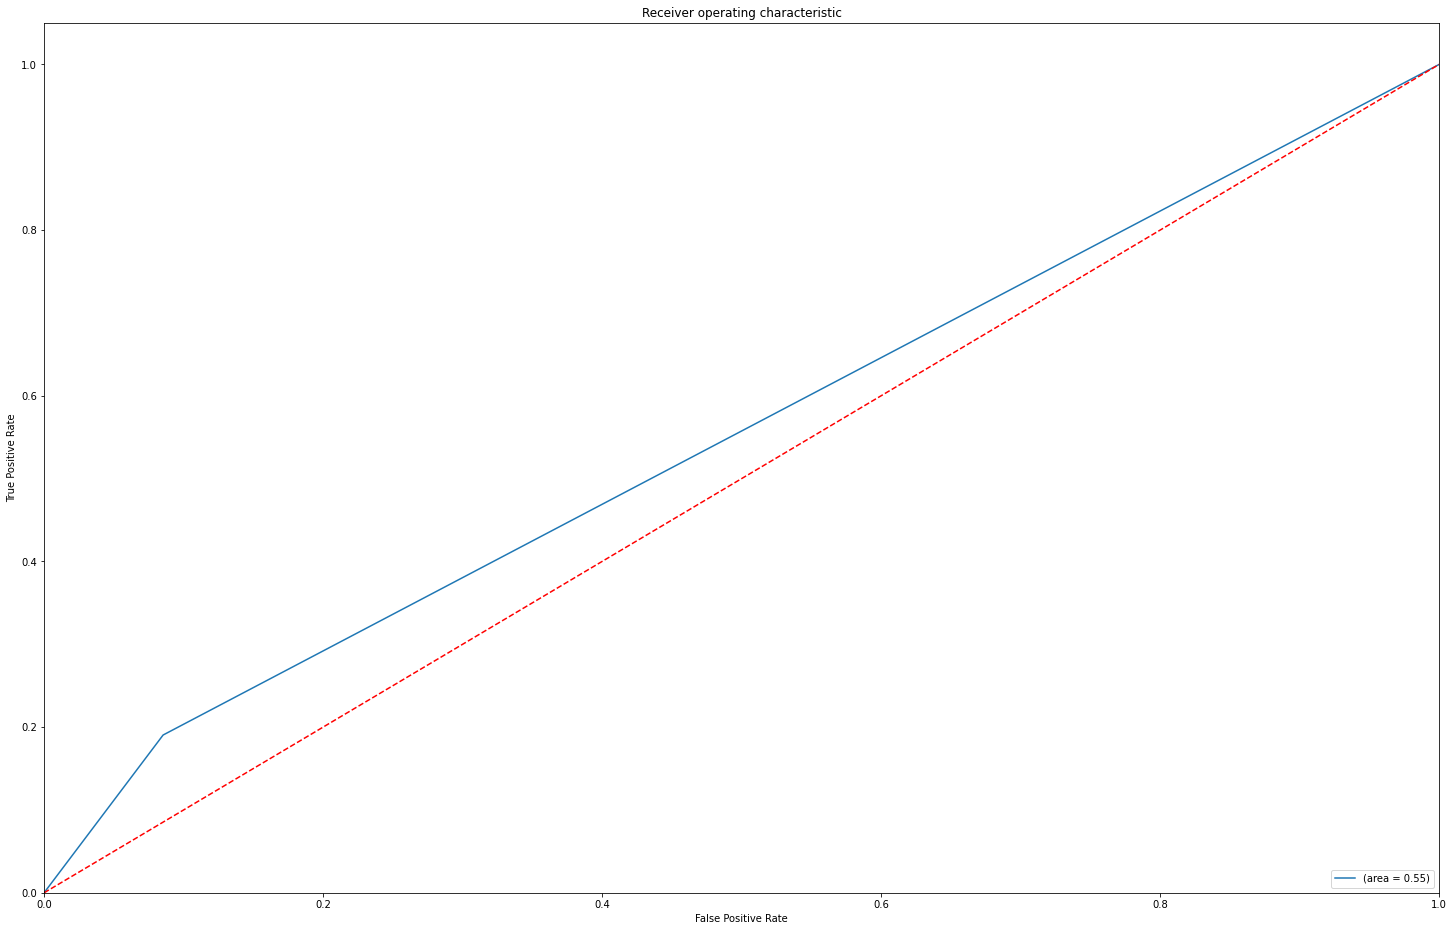

n-----------------DECISION TREE 222222--------------------


>>>>>>>>>>>DECISION TREE CLASSIFIER WEIGHTED KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.8343949044585988
Recall Score:  [0.89078498 0.04761905]
Precision Score:  [0.92882562 0.03030303]
Specificity Score:  [0.89078498 0.04761905]
F1 Score:  [0.90940767 0.03703704]
ROC AUC:  0.46920201527710065
Test of confusion Matrix Scores
True Positives: 1
True Negatives: 261
False Positives: 32
False Negatives: 20
--------------------------------------------------
Accuracy: 0.83
Mis-Classification: 0.17
Sensitivity: 0.05
Specificity: 0.89
Precision: 0.03
Negative Predictive Value: 0.93
f_1 Score: 0.04
              precision    recall  f1-score   support

          -1       0.93      0.89      0.91       293
           1       0.03      0.05      0.04        21

    accuracy                           0.83       314
   macro avg       0.48      0.47      0.47       314
weighted avg       0.87      0.83      0.85       314



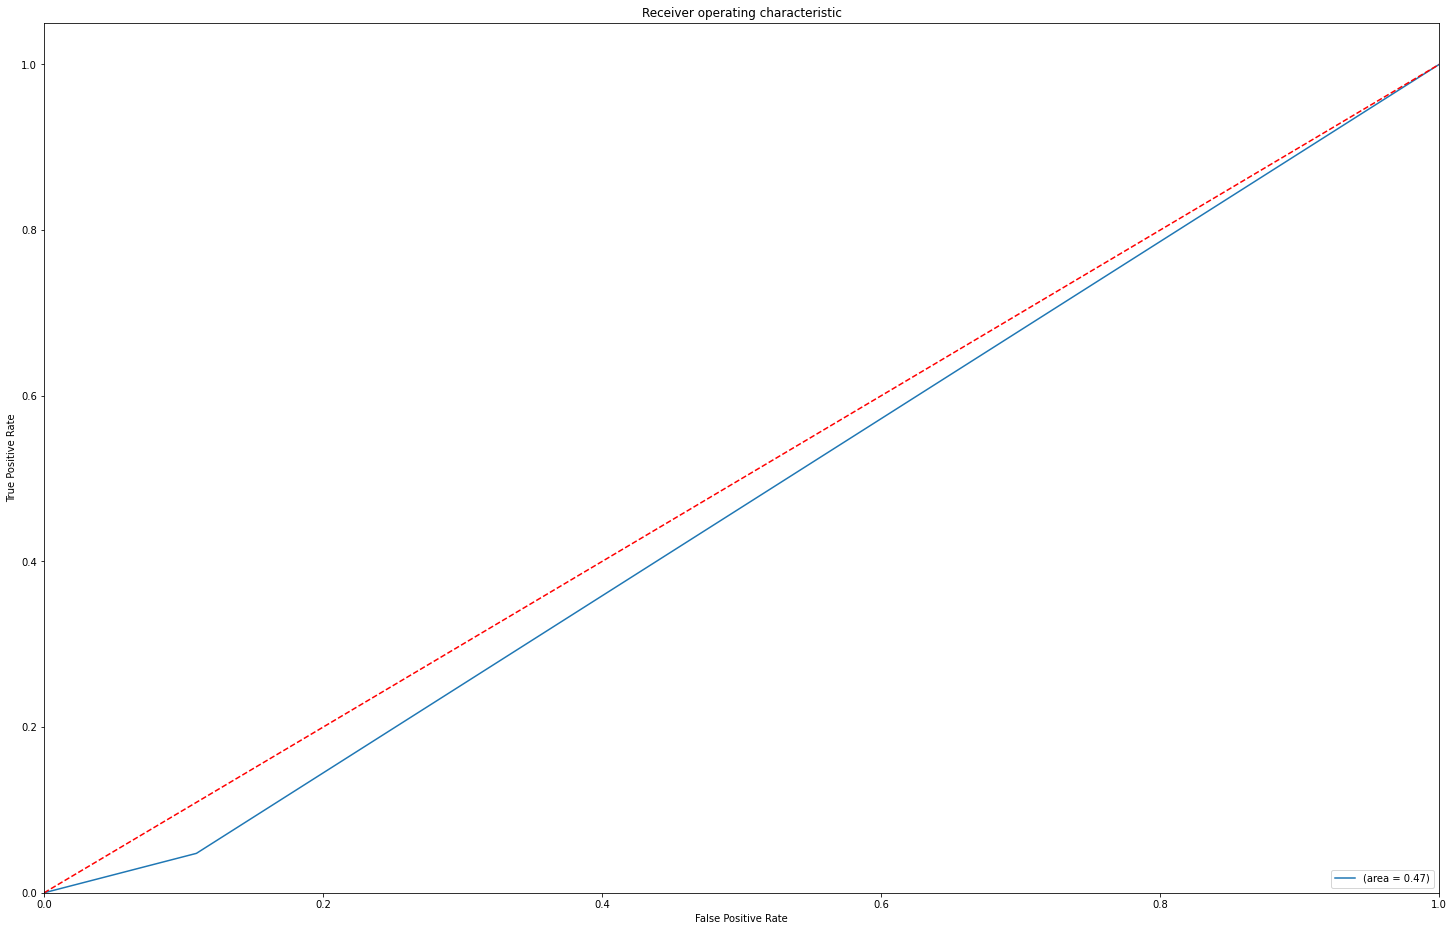


>>>>>>>>>>>DECISION TREE CLASSIFIER WEIGHTED MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.8471337579617835
Recall Score:  [0.88054608 0.38095238]
Precision Score:  [0.95202952 0.18604651]
Specificity Score:  [0.88054608 0.38095238]
F1 Score:  [0.91489362 0.25      ]
ROC AUC:  0.6307492280188526
Test of confusion Matrix Scores
True Positives: 8
True Negatives: 258
False Positives: 35
False Negatives: 13
--------------------------------------------------
Accuracy: 0.85
Mis-Classification: 0.15
Sensitivity: 0.38
Specificity: 0.88
Precision: 0.19
Negative Predictive Value: 0.95
f_1 Score: 0.25
              precision    recall  f1-score   support

          -1       0.95      0.88      0.91       293
           1       0.19      0.38      0.25        21

    accuracy                           0.85       314
   macro avg       0.57      0.63      0.58       314
weighted avg       0.90      0.85      0.87       314



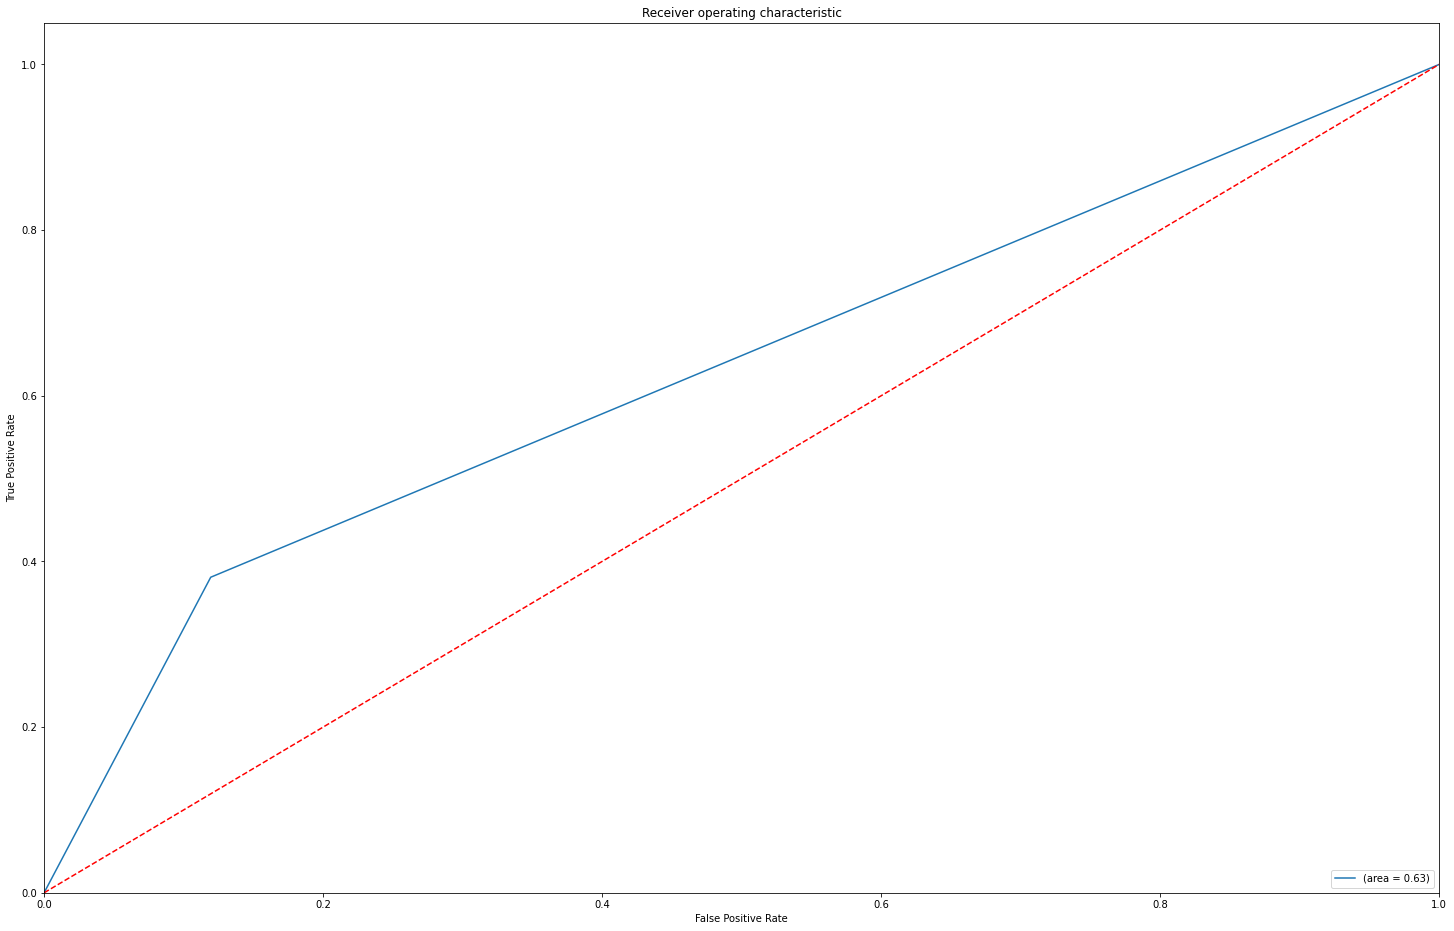


>>>>>>>>>>>DECISION TREE CLASSIFIER WEIGHTED KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.9363057324840764
Recall Score:  [1.         0.04761905]
Precision Score:  [0.93610224 1.        ]
Specificity Score:  [1.         0.04761905]
F1 Score:  [0.9669967  0.09090909]
ROC AUC:  0.5238095238095238
Test of confusion Matrix Scores
True Positives: 1
True Negatives: 293
False Positives: 0
False Negatives: 20
--------------------------------------------------
Accuracy: 0.94
Mis-Classification: 0.06
Sensitivity: 0.05
Specificity: 1.0
Precision: 1.0
Negative Predictive Value: 0.94
f_1 Score: 0.09
              precision    recall  f1-score   support

          -1       0.94      1.00      0.97       293
           1       1.00      0.05      0.09        21

    accuracy                           0.94       314
   macro avg       0.97      0.52      0.53       314
weighted avg       0.94      0.94      0.91       314



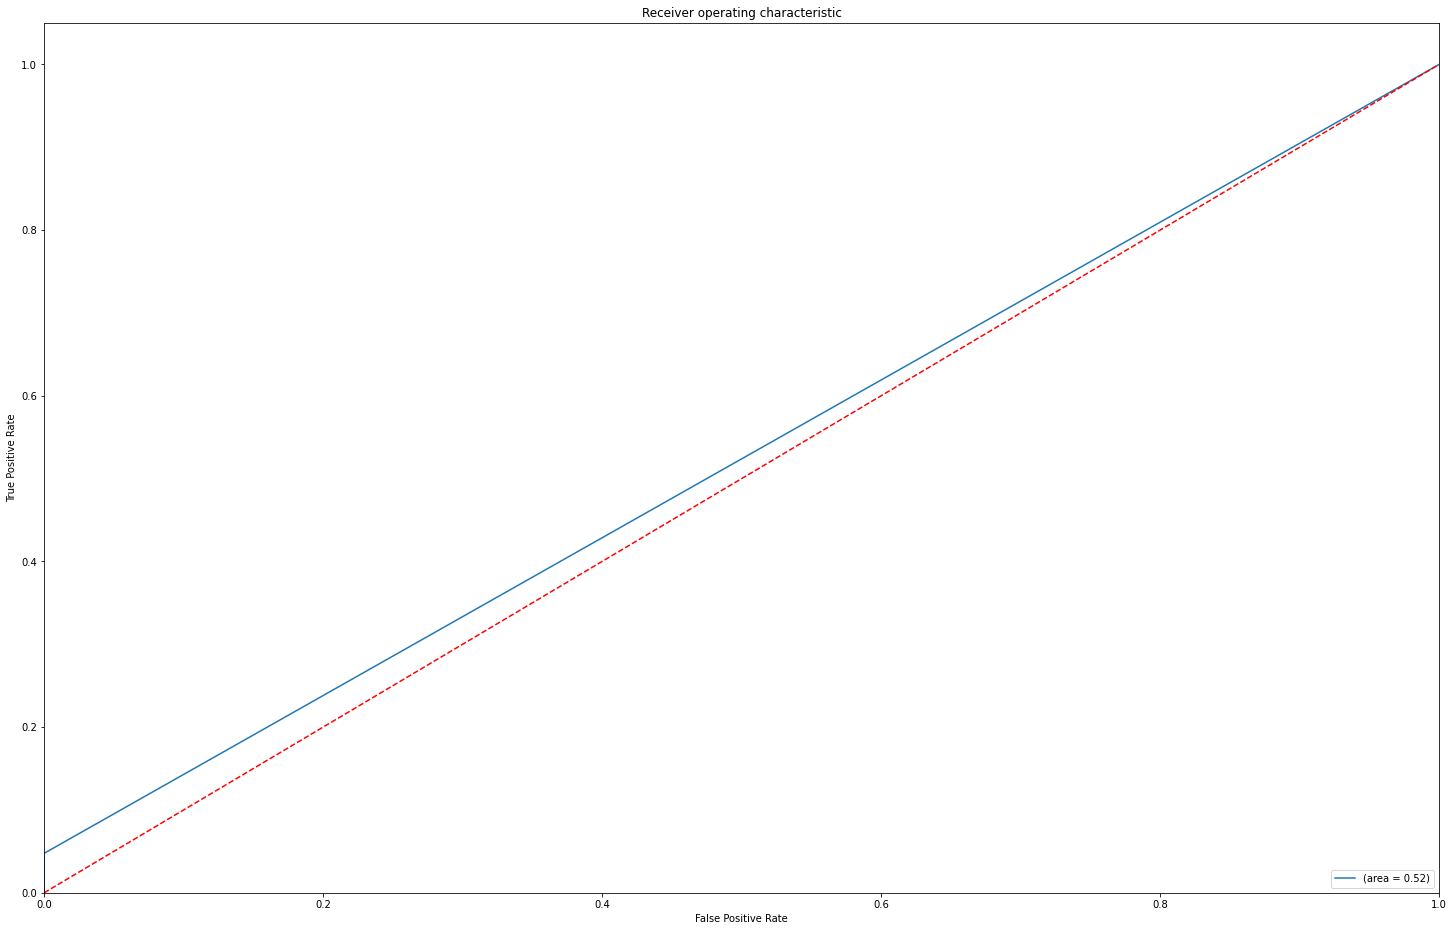


>>>>>>>>>>>DECISION TREE CLASSIFIER WEIGHTED MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.8885350318471338
Recall Score:  [0.94880546 0.04761905]
Precision Score:  [0.93288591 0.0625    ]
Specificity Score:  [0.94880546 0.04761905]
F1 Score:  [0.94077834 0.05405405]
ROC AUC:  0.49821225418495046
Test of confusion Matrix Scores
True Positives: 1
True Negatives: 278
False Positives: 15
False Negatives: 20
--------------------------------------------------
Accuracy: 0.89
Mis-Classification: 0.11
Sensitivity: 0.05
Specificity: 0.95
Precision: 0.06
Negative Predictive Value: 0.93
f_1 Score: 0.05
              precision    recall  f1-score   support

          -1       0.93      0.95      0.94       293
           1       0.06      0.05      0.05        21

    accuracy                           0.89       314
   macro avg       0.50      0.50      0.50       314
weighted avg       0.87      0.89      0.88       314



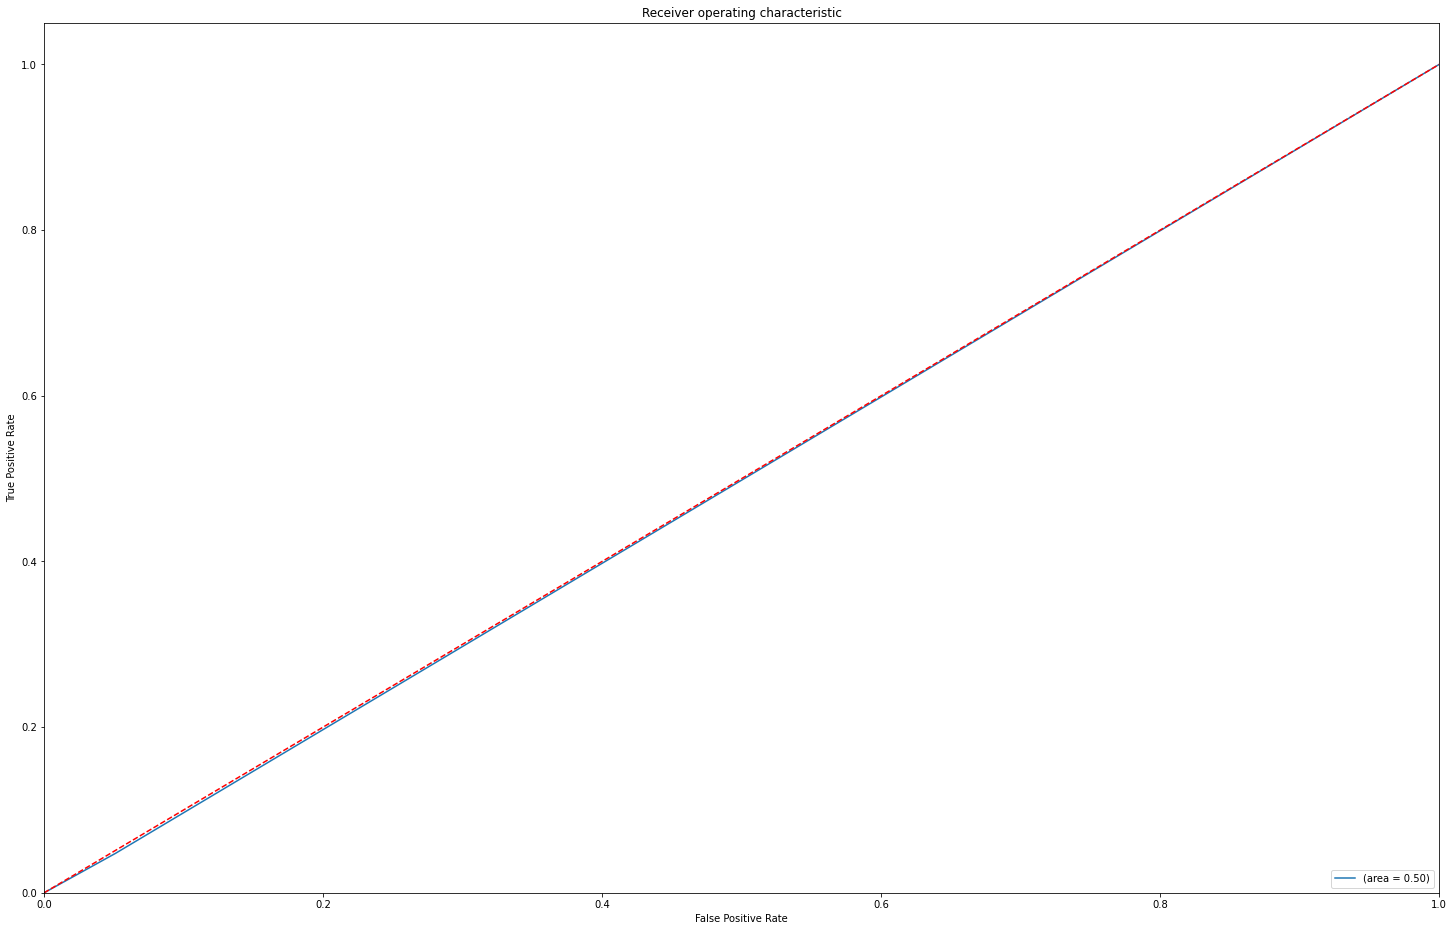

n-----------RANDOM FOREST CLASSIFIER---------------


>>>>>>>>>>>RANDOM FOREST CLASSIFIER  KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.9299363057324841
Recall Score:  [0.99658703 0.        ]
Precision Score:  [0.93290735 0.        ]
Specificity Score:  [0.99658703 0.        ]
F1 Score:  [0.96369637 0.        ]
ROC AUC:  0.49829351535836175
Test of confusion Matrix Scores
True Positives: 0
True Negatives: 292
False Positives: 1
False Negatives: 21
--------------------------------------------------
Accuracy: 0.93
Mis-Classification: 0.07
Sensitivity: 0.0
Specificity: 1.0
Precision: 0.0
Negative Predictive Value: 0.93
f_1 Score: nan
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314



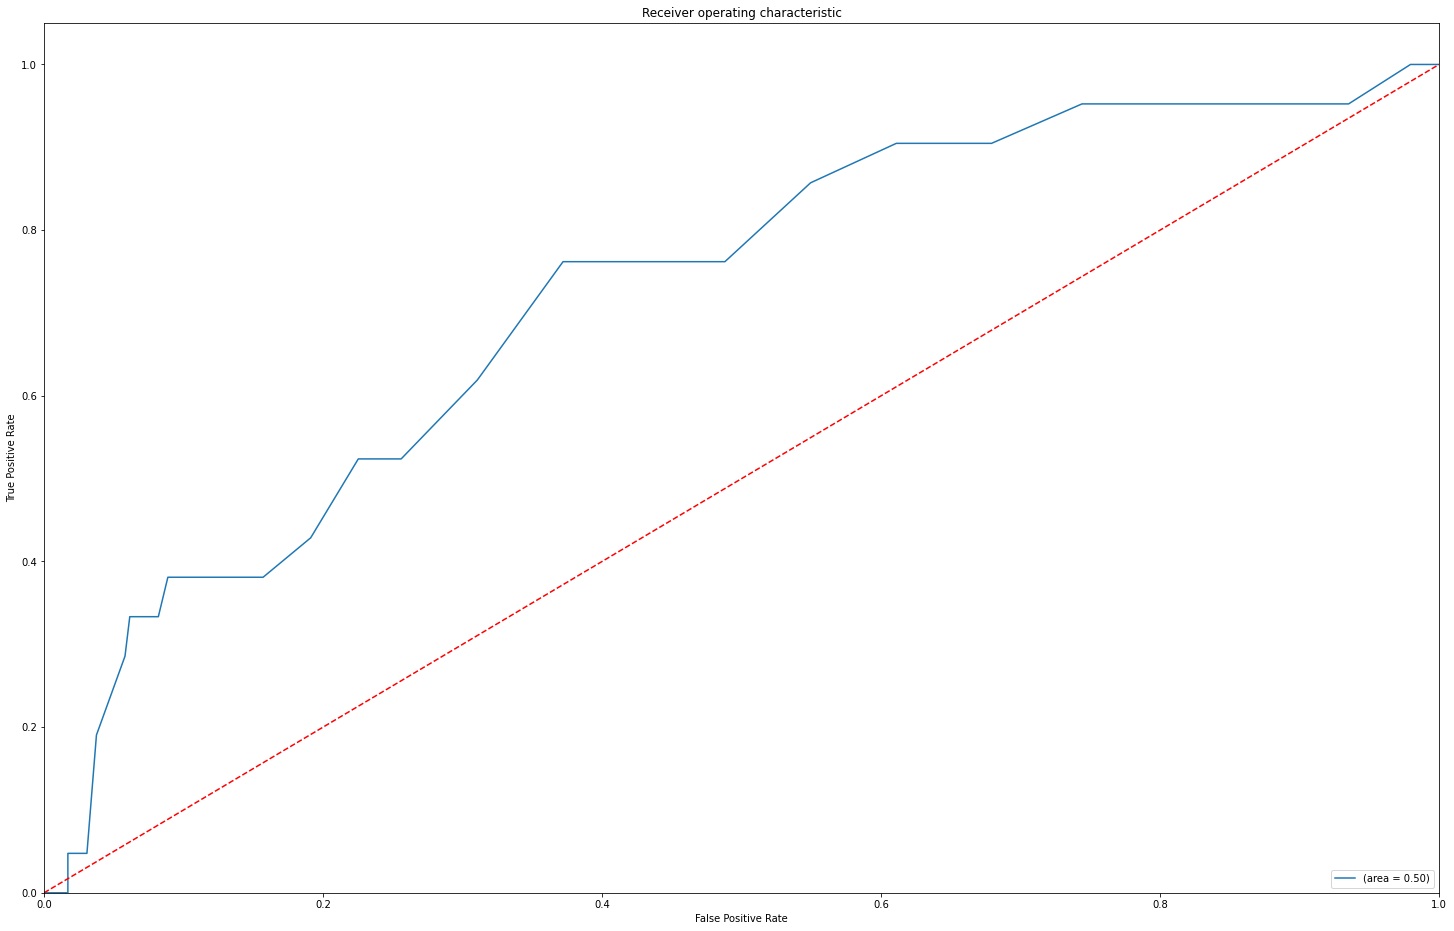


>>>>>>>>>>>RANDOM FOREST CLASSIFIER  MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.8885350318471338
Recall Score:  [0.93515358 0.23809524]
Precision Score:  [0.94482759 0.20833333]
Specificity Score:  [0.93515358 0.23809524]
F1 Score:  [0.93996569 0.22222222]
ROC AUC:  0.5866244108564928
Test of confusion Matrix Scores
True Positives: 5
True Negatives: 274
False Positives: 19
False Negatives: 16
--------------------------------------------------
Accuracy: 0.89
Mis-Classification: 0.11
Sensitivity: 0.24
Specificity: 0.94
Precision: 0.21
Negative Predictive Value: 0.94
f_1 Score: 0.22
              precision    recall  f1-score   support

          -1       0.94      0.94      0.94       293
           1       0.21      0.24      0.22        21

    accuracy                           0.89       314
   macro avg       0.58      0.59      0.58       314
weighted avg       0.90      0.89      0.89       314



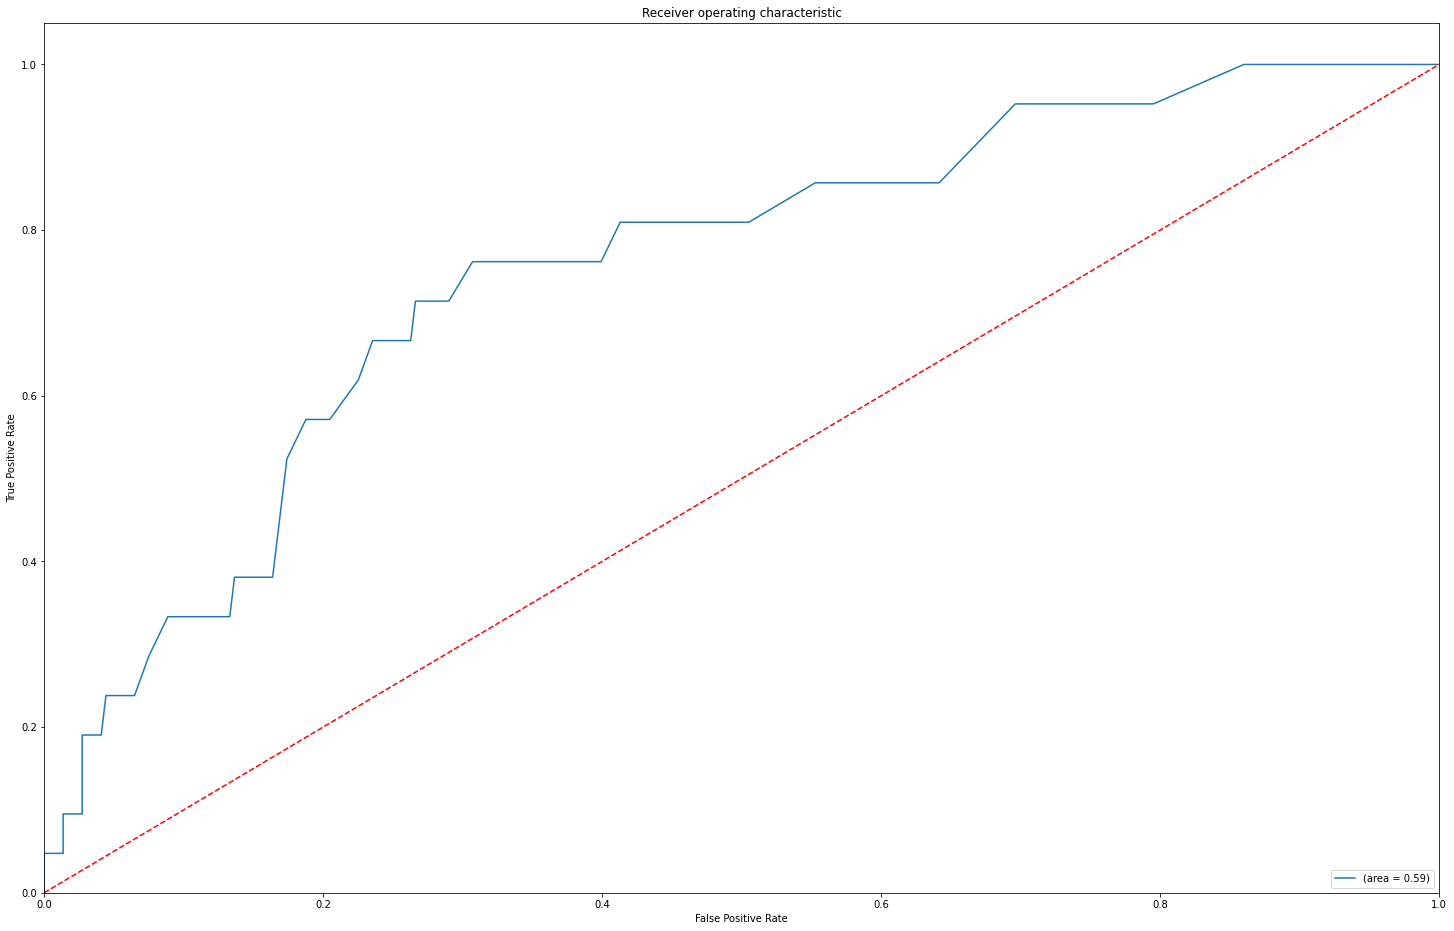


>>>>>>>>>>>RANDOM FOREST CLASSIFIER  KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.9331210191082803
Recall Score:  [1. 0.]
Precision Score:  [0.93312102 0.        ]
Specificity Score:  [1. 0.]
F1 Score:  [0.96540362 0.        ]
ROC AUC:  0.5
Test of confusion Matrix Scores
True Positives: 0
True Negatives: 293
False Positives: 0
False Negatives: 21
--------------------------------------------------
Accuracy: 0.93
Mis-Classification: 0.07
Sensitivity: 0.0
Specificity: 1.0
Precision: nan
Negative Predictive Value: 0.93
f_1 Score: nan
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314



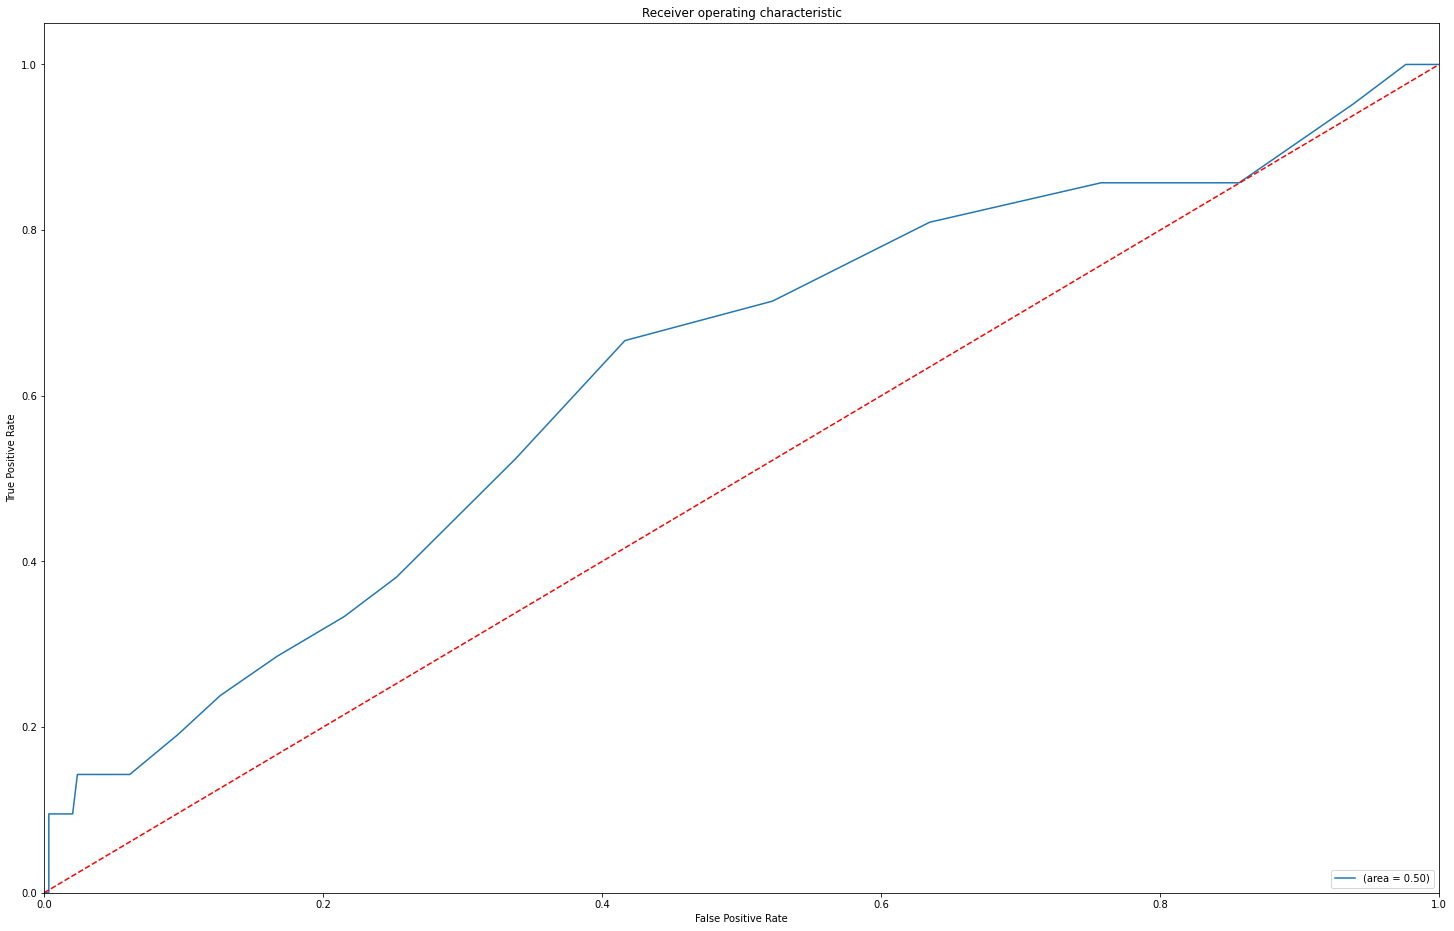


>>>>>>>>>>>RANDOM FOREST CLASSIFIER  MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.9140127388535032
Recall Score:  [0.97269625 0.0952381 ]
Precision Score:  [0.9375 0.2   ]
Specificity Score:  [0.97269625 0.0952381 ]
F1 Score:  [0.95477387 0.12903226]
ROC AUC:  0.5339671704859419
Test of confusion Matrix Scores
True Positives: 2
True Negatives: 285
False Positives: 8
False Negatives: 19
--------------------------------------------------
Accuracy: 0.91
Mis-Classification: 0.09
Sensitivity: 0.1
Specificity: 0.97
Precision: 0.2
Negative Predictive Value: 0.94
f_1 Score: 0.13
              precision    recall  f1-score   support

          -1       0.94      0.97      0.95       293
           1       0.20      0.10      0.13        21

    accuracy                           0.91       314
   macro avg       0.57      0.53      0.54       314
weighted avg       0.89      0.91      0.90       314



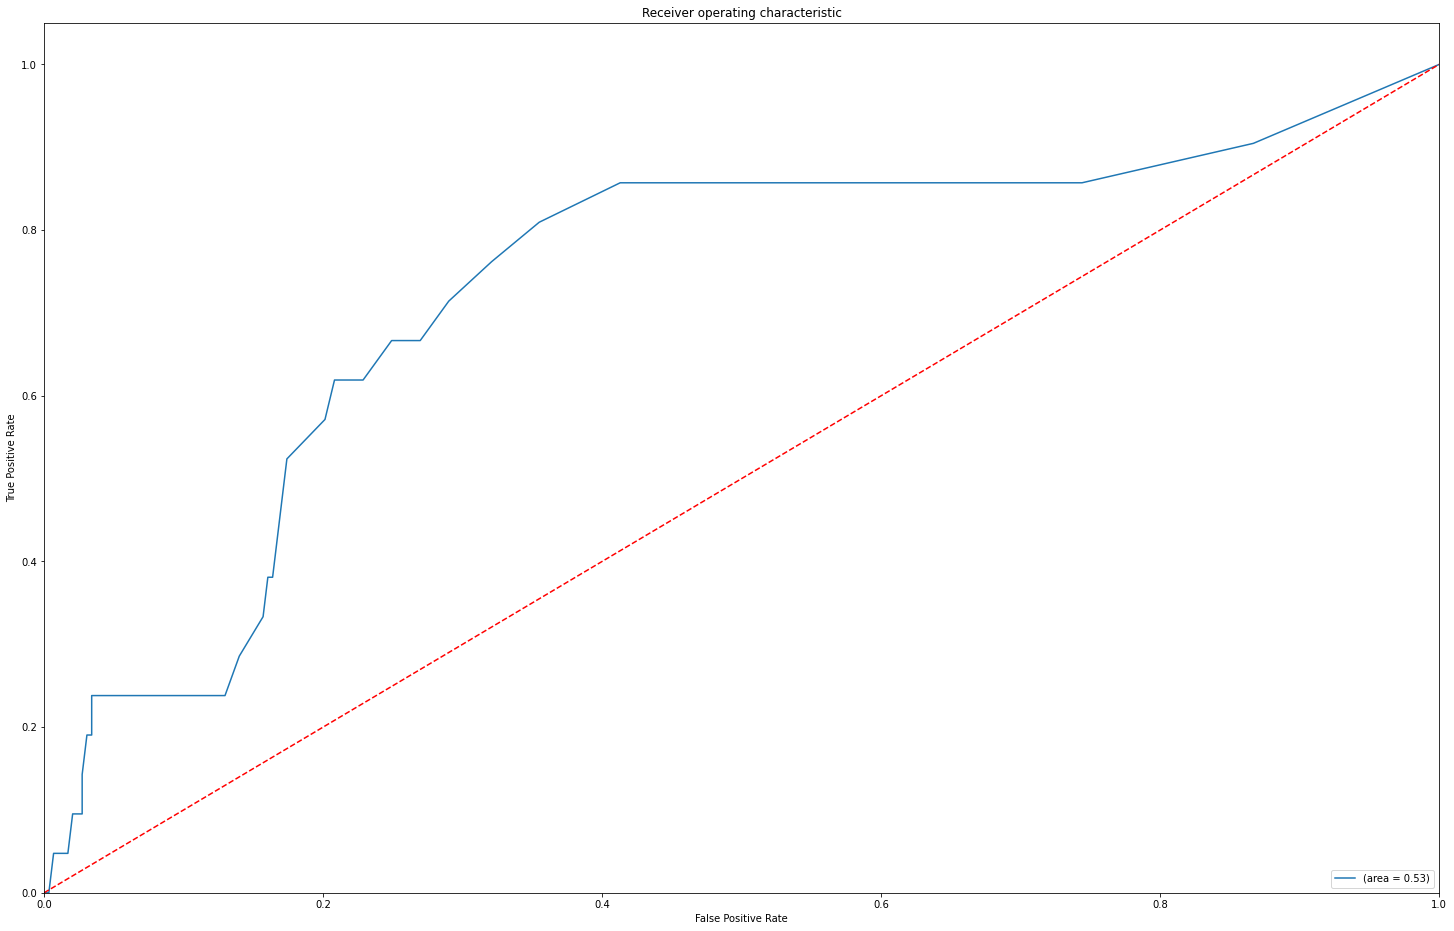

n-----------RANDOM FOREST CLASSIFIER WEIGHTED---------------


>>>>>>>>>>>RANDOM FOREST CLASSIFIER WEIGHTED KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.9267515923566879
Recall Score:  [0.99317406 0.        ]
Precision Score:  [0.93269231 0.        ]
Specificity Score:  [0.99317406 0.        ]
F1 Score:  [0.96198347 0.        ]
ROC AUC:  0.49658703071672355
Test of confusion Matrix Scores
True Positives: 0
True Negatives: 291
False Positives: 2
False Negatives: 21
--------------------------------------------------
Accuracy: 0.93
Mis-Classification: 0.07
Sensitivity: 0.0
Specificity: 0.99
Precision: 0.0
Negative Predictive Value: 0.93
f_1 Score: nan
              precision    recall  f1-score   support

          -1       0.93      0.99      0.96       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314



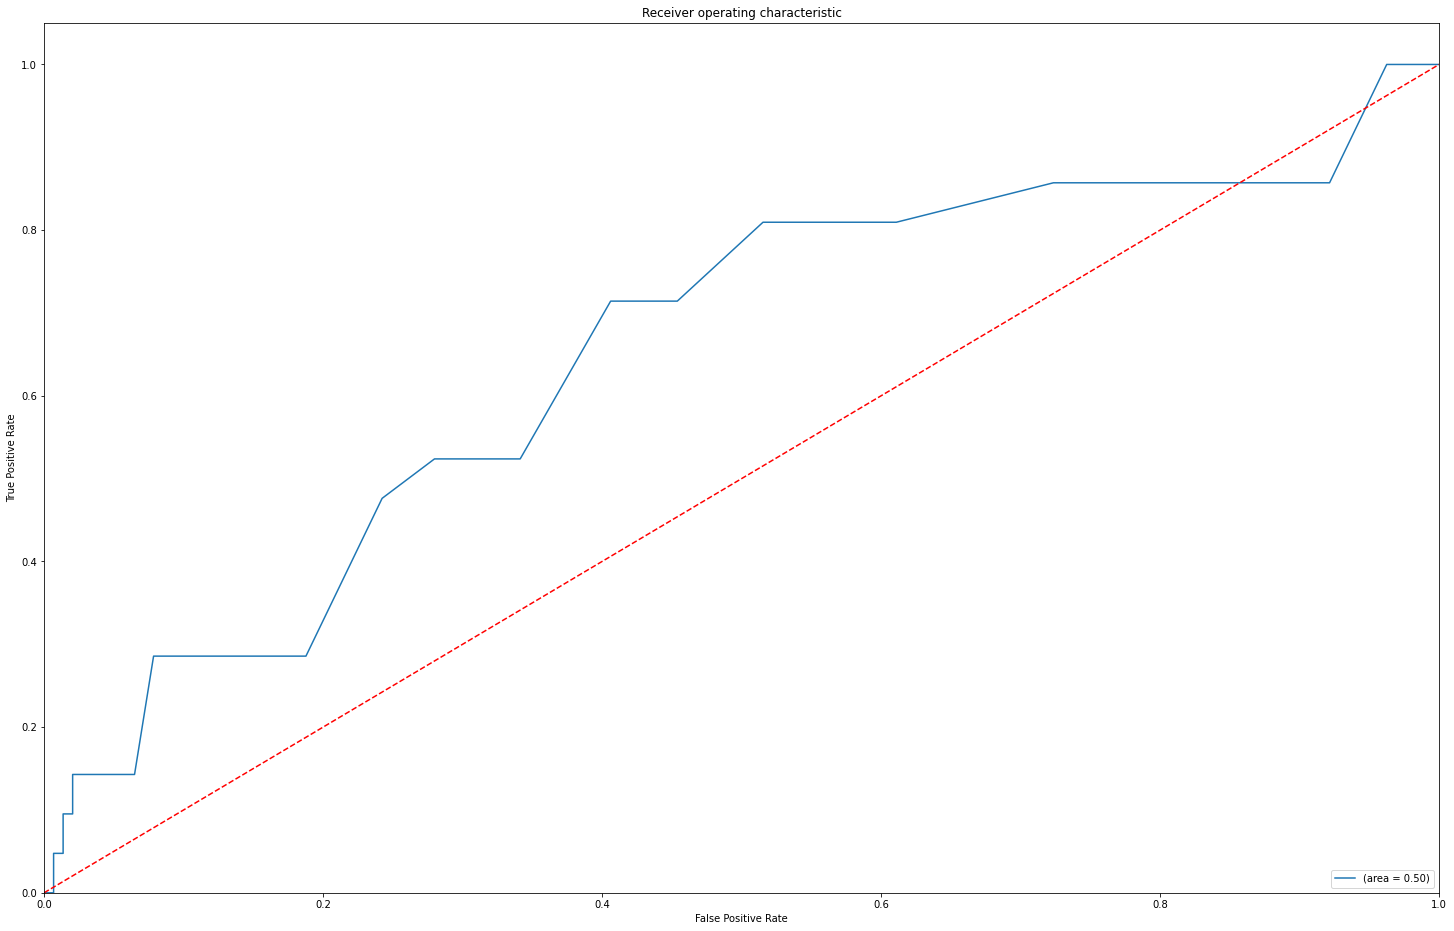


>>>>>>>>>>>RANDOM FOREST CLASSIFIER WEIGHTED MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.8980891719745223
Recall Score:  [0.94880546 0.19047619]
Precision Score:  [0.94237288 0.21052632]
Specificity Score:  [0.94880546 0.19047619]
F1 Score:  [0.94557823 0.2       ]
ROC AUC:  0.5696408256135218
Test of confusion Matrix Scores
True Positives: 4
True Negatives: 278
False Positives: 15
False Negatives: 17
--------------------------------------------------
Accuracy: 0.9
Mis-Classification: 0.1
Sensitivity: 0.19
Specificity: 0.95
Precision: 0.21
Negative Predictive Value: 0.94
f_1 Score: 0.2
              precision    recall  f1-score   support

          -1       0.94      0.95      0.95       293
           1       0.21      0.19      0.20        21

    accuracy                           0.90       314
   macro avg       0.58      0.57      0.57       314
weighted avg       0.89      0.90      0.90       314



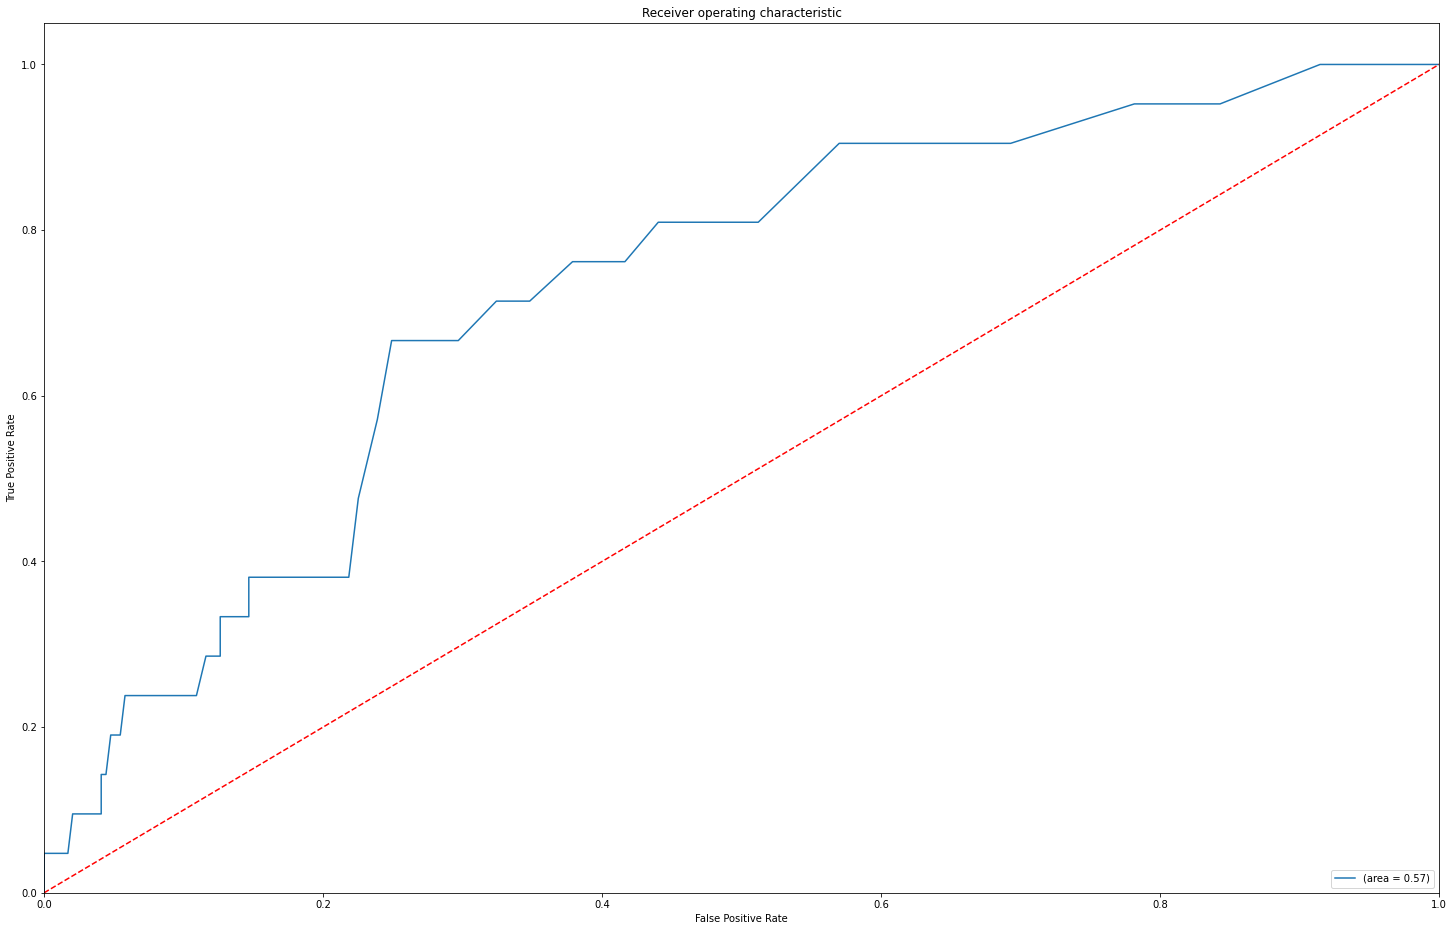


>>>>>>>>>>>RANDOM FOREST CLASSIFIER WEIGHTED KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.9331210191082803
Recall Score:  [1. 0.]
Precision Score:  [0.93312102 0.        ]
Specificity Score:  [1. 0.]
F1 Score:  [0.96540362 0.        ]
ROC AUC:  0.5
Test of confusion Matrix Scores
True Positives: 0
True Negatives: 293
False Positives: 0
False Negatives: 21
--------------------------------------------------
Accuracy: 0.93
Mis-Classification: 0.07
Sensitivity: 0.0
Specificity: 1.0
Precision: nan
Negative Predictive Value: 0.93
f_1 Score: nan
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314



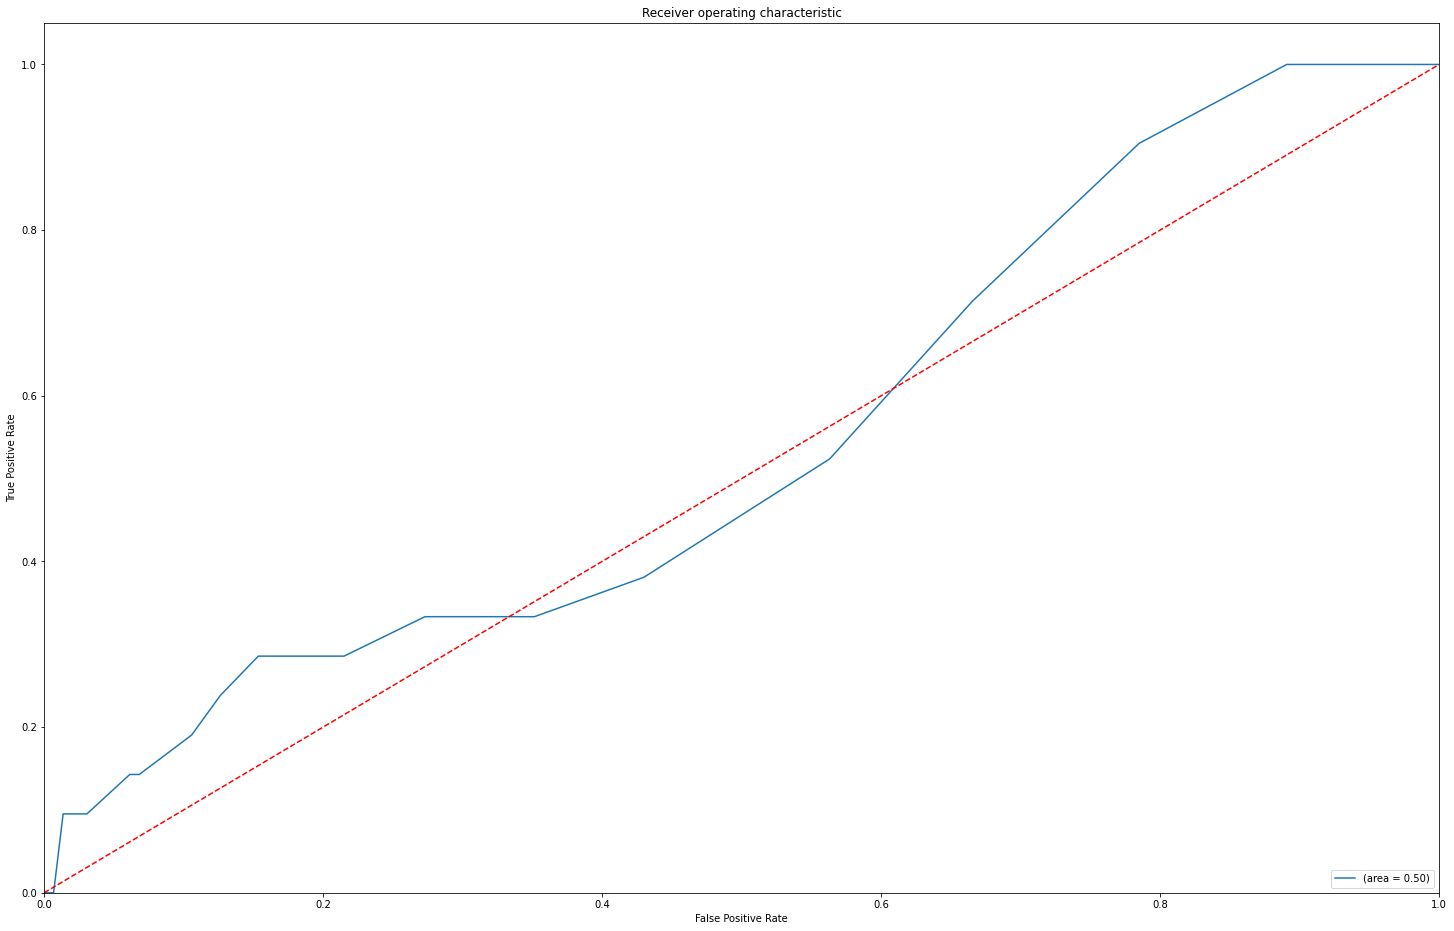


>>>>>>>>>>>RANDOM FOREST CLASSIFIER WEIGHTED MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.910828025477707
Recall Score:  [0.97269625 0.04761905]
Precision Score:  [0.93442623 0.11111111]
Specificity Score:  [0.97269625 0.04761905]
F1 Score:  [0.95317726 0.06666667]
ROC AUC:  0.510157646676418
Test of confusion Matrix Scores
True Positives: 1
True Negatives: 285
False Positives: 8
False Negatives: 20
--------------------------------------------------
Accuracy: 0.91
Mis-Classification: 0.09
Sensitivity: 0.05
Specificity: 0.97
Precision: 0.11
Negative Predictive Value: 0.93
f_1 Score: 0.07
              precision    recall  f1-score   support

          -1       0.93      0.97      0.95       293
           1       0.11      0.05      0.07        21

    accuracy                           0.91       314
   macro avg       0.52      0.51      0.51       314
weighted avg       0.88      0.91      0.89       314



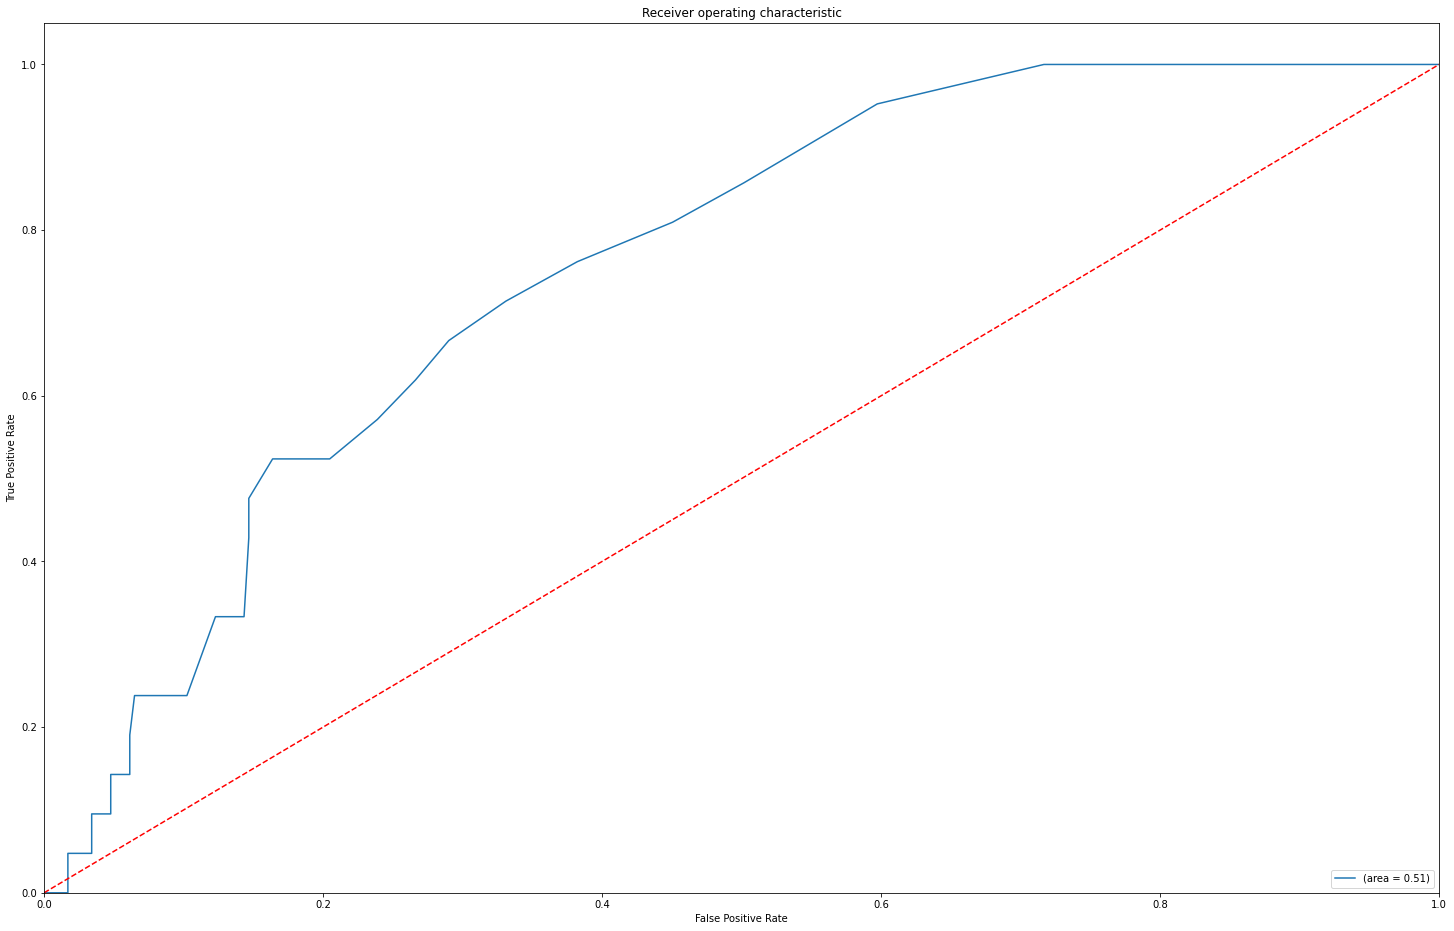

In [ ]:
models_df = modelling(train_test_dict, target_var = "STATUS")

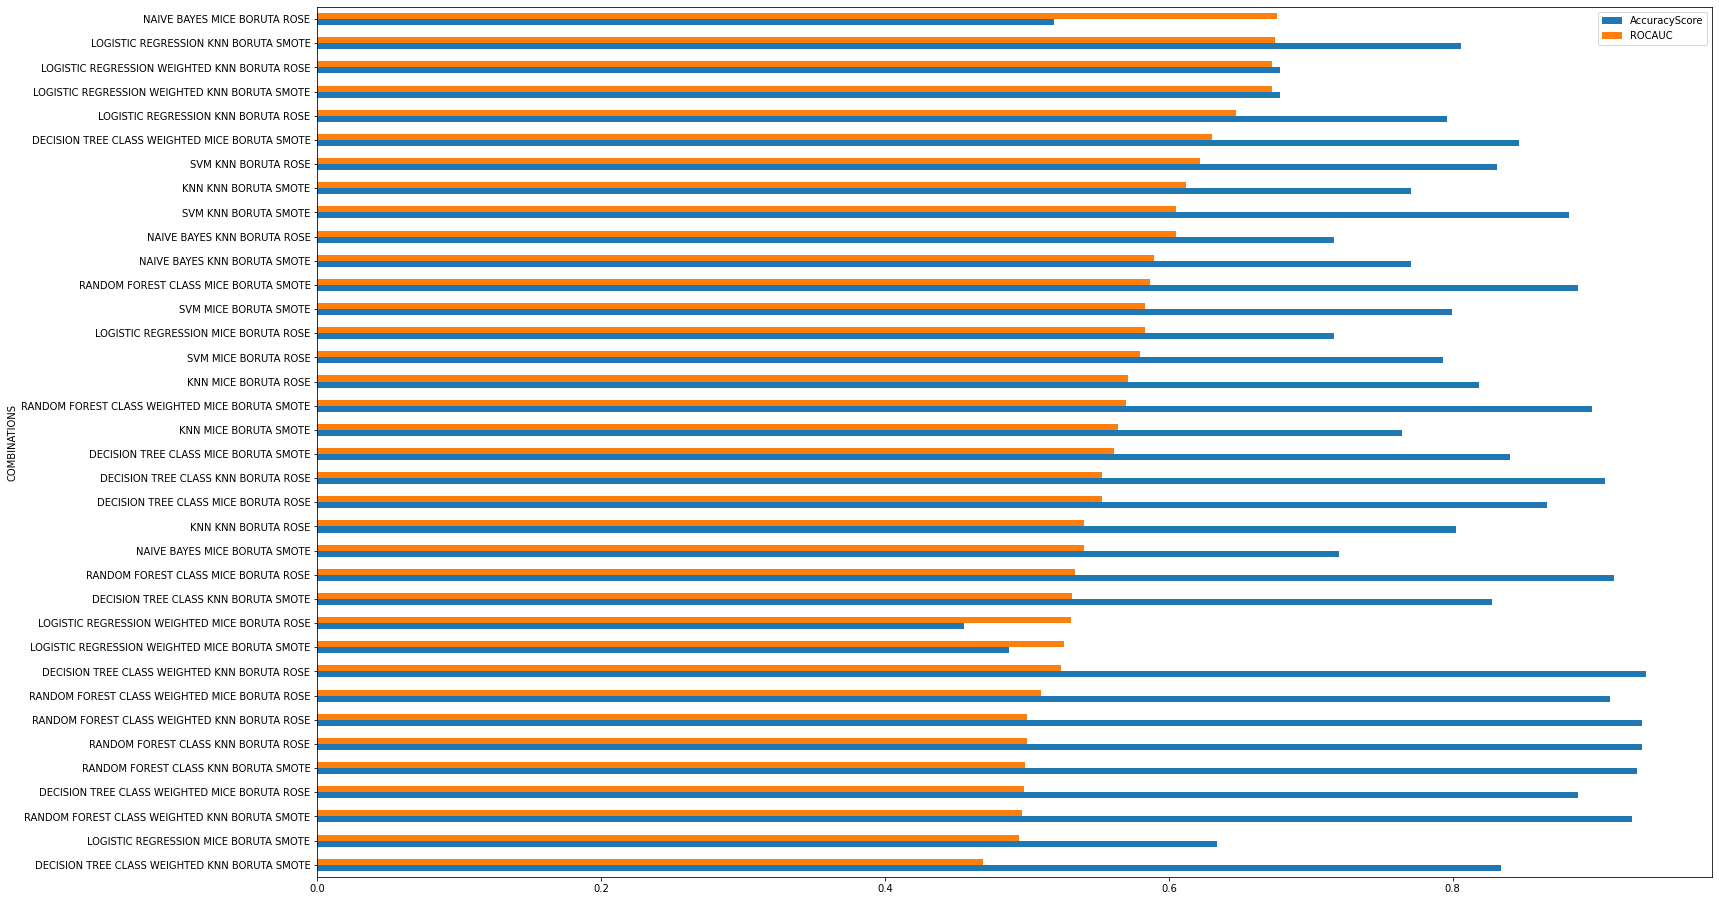

In [ ]:
models_df.sort_values(by=["ROCAUC","AccuracyScore"], ascending = True).plot(x="COMBINATIONS", y=["AccuracyScore","ROCAUC"], kind="barh")

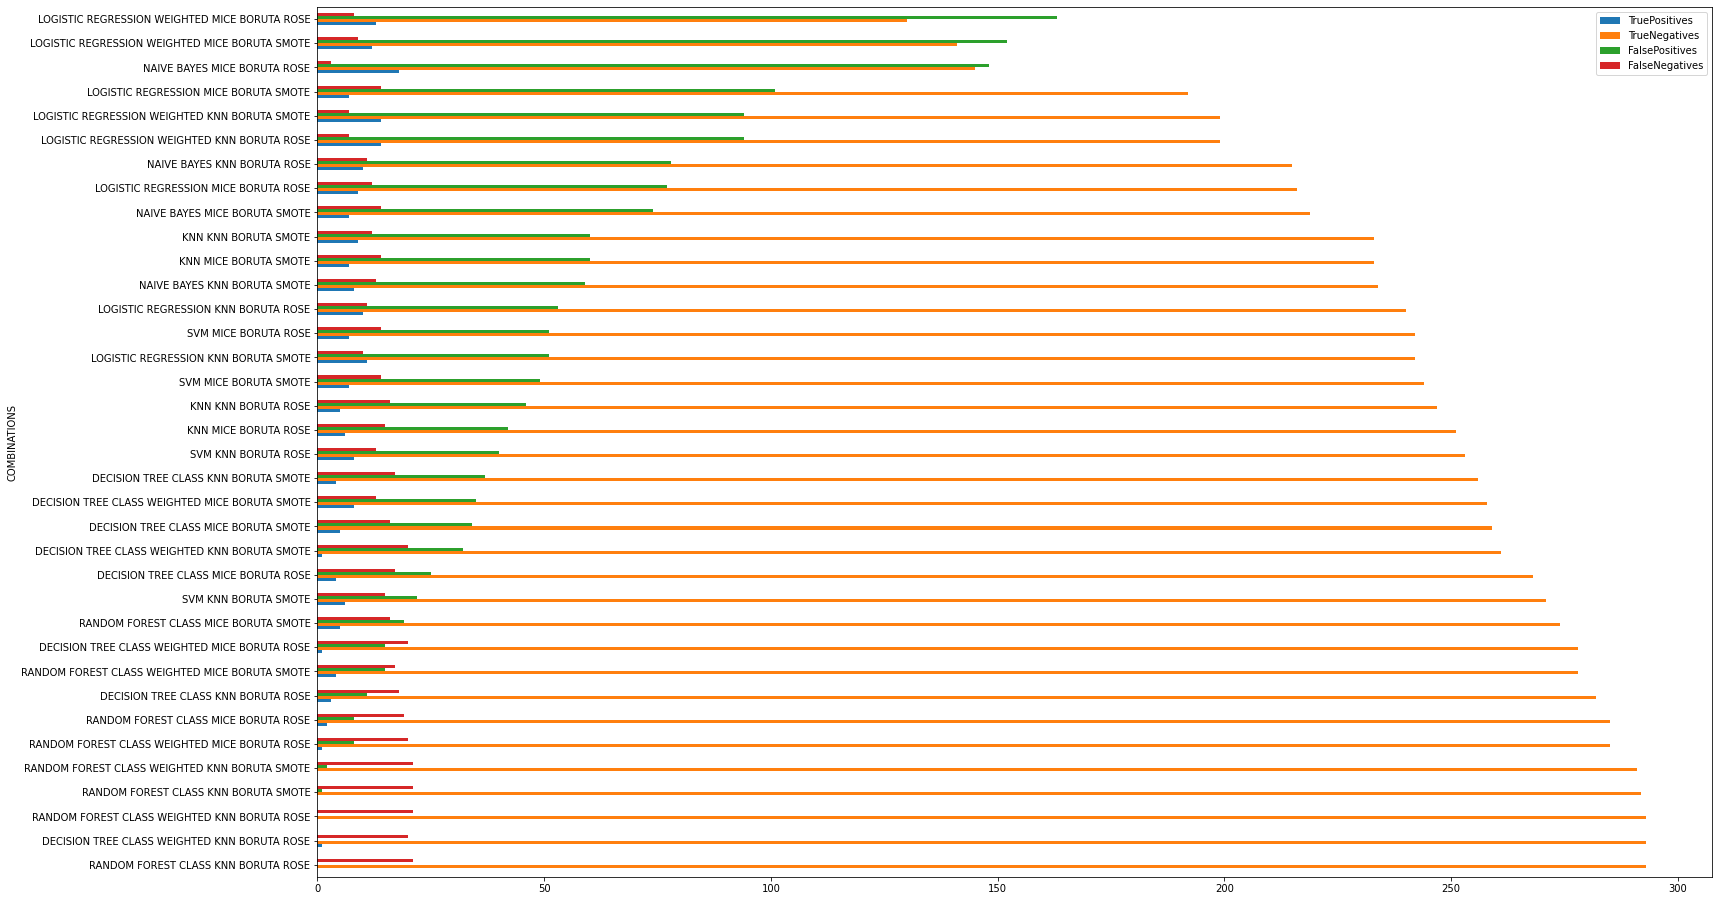

In [ ]:
models_df.sort_values(by="FalsePositives", ascending = True).plot(x="COMBINATIONS", y=["TruePositives",	"TrueNegatives",	"FalsePositives"	,"FalseNegatives"], kind="barh", )

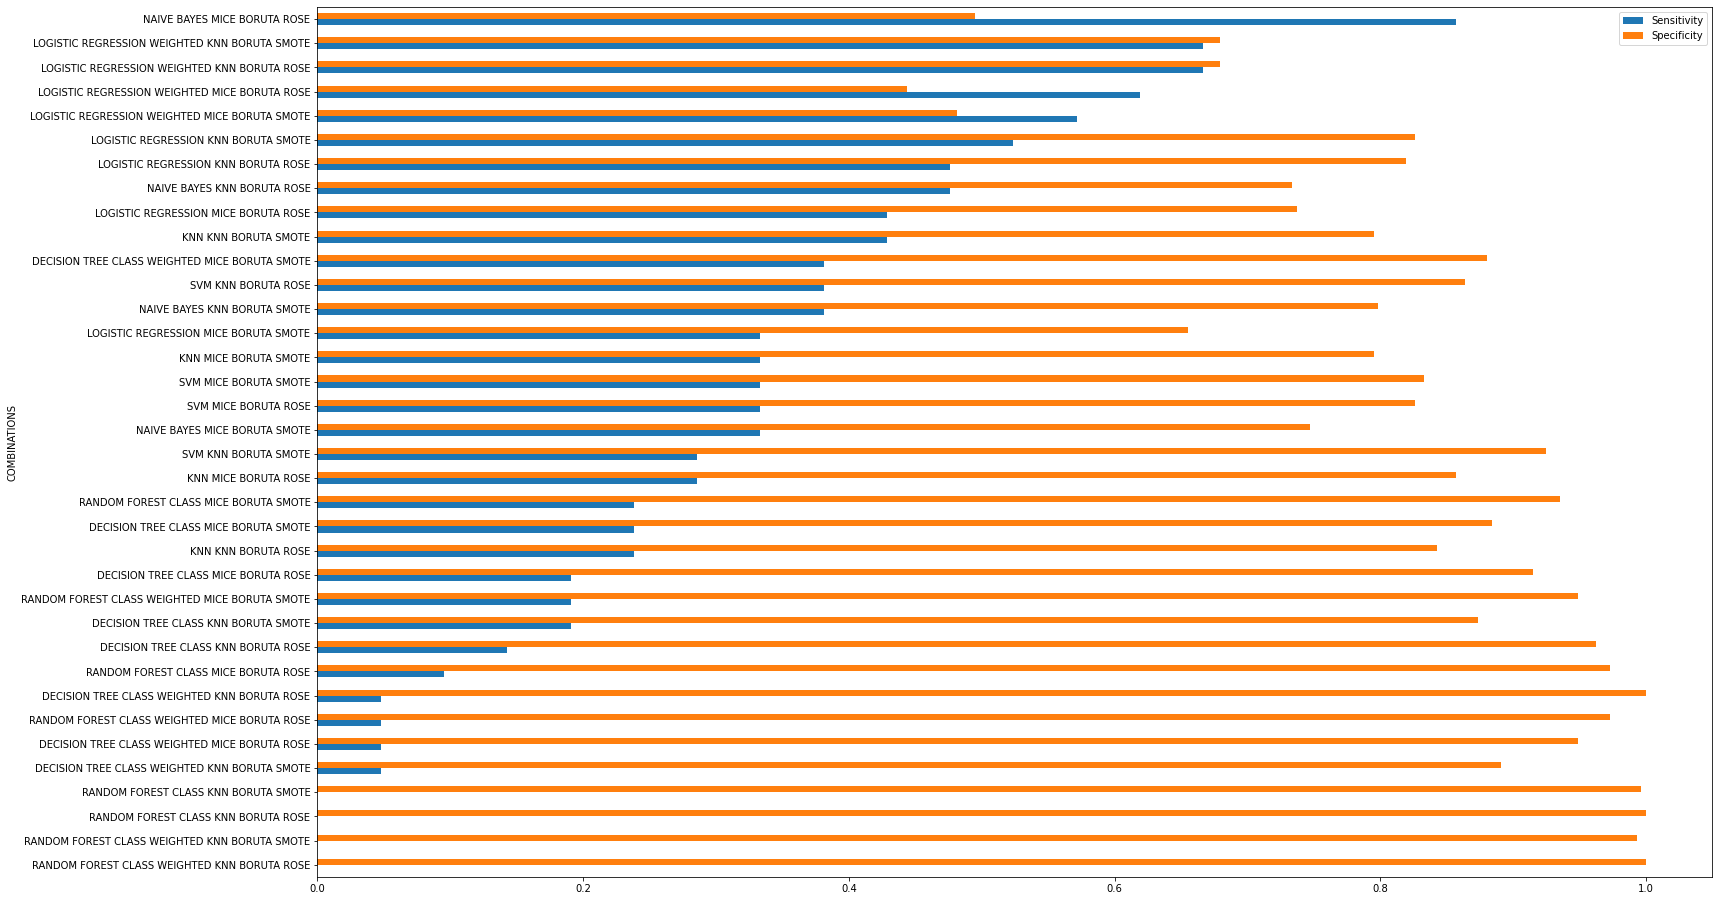

In [ ]:
models_df.sort_values(by="Sensitivity", ascending = True).plot(x="COMBINATIONS", y=['Sensitivity', 'Specificity'], kind="barh")

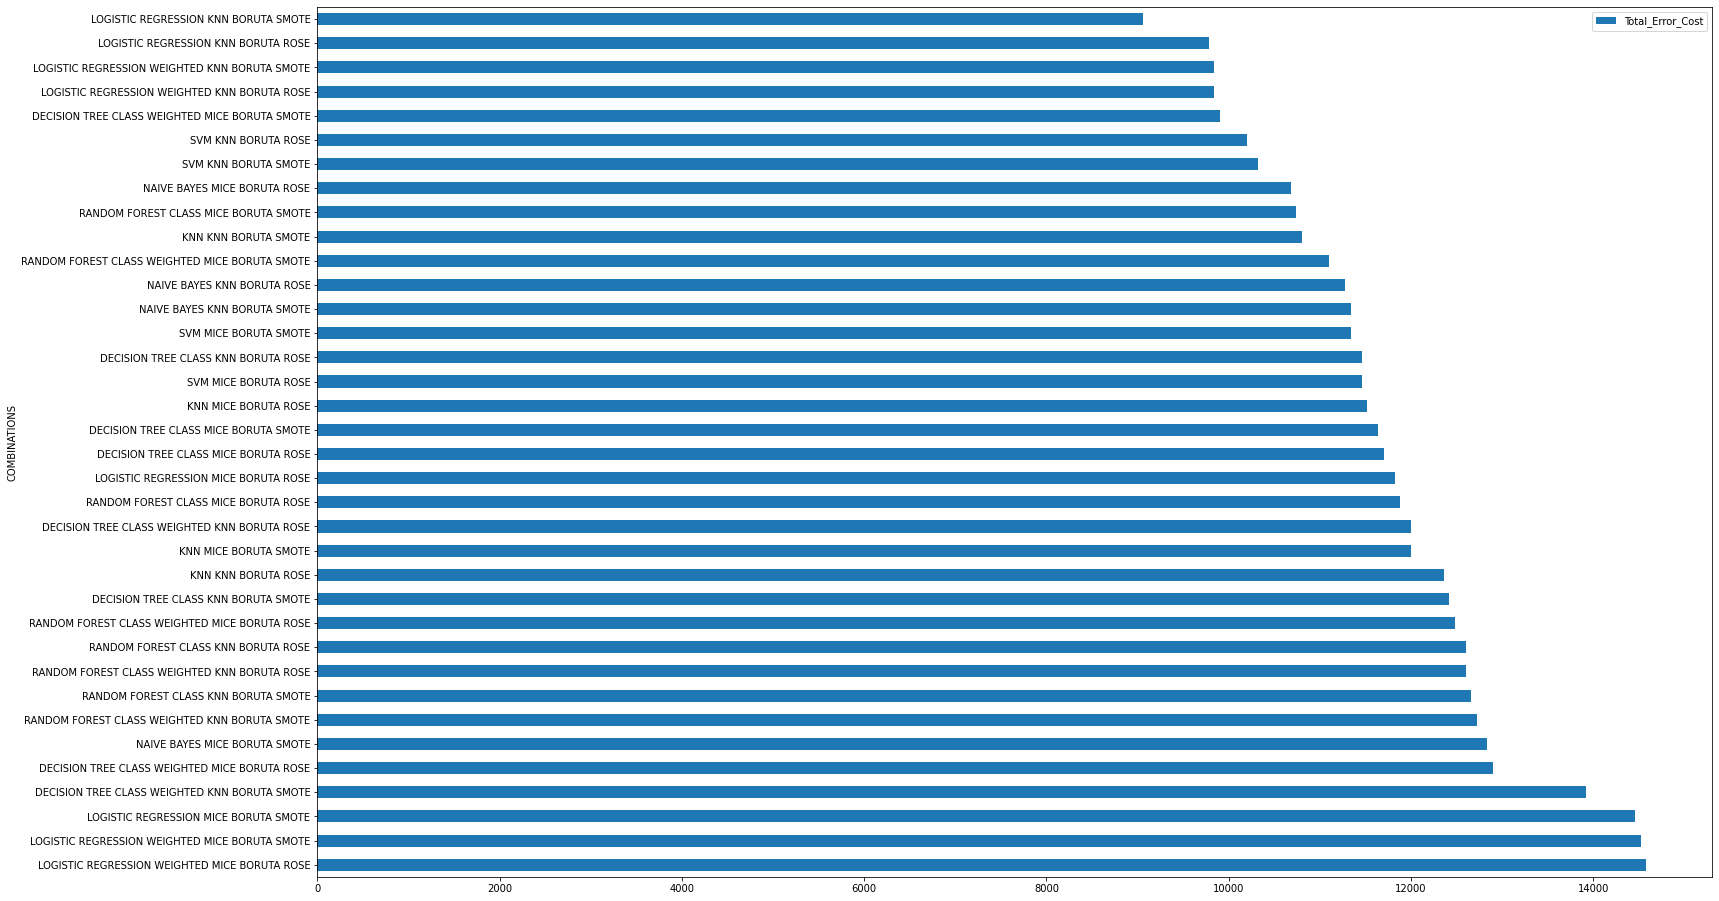

In [ ]:
models_df.sort_values(by="Total_Error_Cost", ascending = False).plot(x="COMBINATIONS", y=['Total_Error_Cost'], kind="barh")

#GRID SEARCH

In [ ]:
print("n---------------LOGISTIC REGRESSION GRID SEARCH----------------\n")
for train in train_test_dict:
  print("\n>>>>>>>>>>>LOGISTIC REGRESSION", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
  logistic_regression_w_gridsearch(train_test_dict[train][1], train_test_dict[train][2], target_var = "STATUS", train_test_name = train_test_dict[train][0])

print("n---------------LOGISTIC REGRESSION WEIGHTED GRID SEARCH----------------\n")
for train in train_test_dict:
  print("\n>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED ", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
  logistic_regression_w_gridsearch(train_test_dict[train][1], train_test_dict[train][2], target_var = "STATUS", train_test_name = train_test_dict[train][0])

print("n---------------SVM GRID SEARCH----------------\n")
for train in train_test_dict:
  print("\n>>>>>>>>>>>SVM ", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
  svm_model_w_gridsearch(train_test_dict[train][1], train_test_dict[train][2], target_var = "STATUS", train_test_name = train_test_dict[train][0])

print("n---------------NAIVE BAYES GRID SEARCH----------------\n")
for train in train_test_dict:
  print("\n>>>>>>>>>>>NAIVE BAYES ", train_test_dict[train][0],"<<<<<<<<<<<<<\n")
  naive_bayes_w_gridsearch(train_test_dict[train][1], train_test_dict[train][2], target_var = "STATUS", train_test_name = train_test_dict[train][0])

n---------------LOGISTIC REGRESSION GRID SEARCH----------------


>>>>>>>>>>>LOGISTIC REGRESSION KNN BORUTA SMOTE <<<<<<<<<<<<<

+----+-------------------------+-----------------+-------------------+-------------------+--------------------------------------+
|    | params                  |   mean_fit_time |   mean_test_score |   rank_test_score | MODEL                                |
|----+-------------------------+-----------------+-------------------+-------------------+--------------------------------------|
| 13 | {'C': 10}               |       0.0595969 |          0.75812  |                 1 | LOGISTIC REGRESSION KNN BORUTA SMOTE |
|  2 | {'solver': 'liblinear'} |       0.0132422 |          0.755556 |                 2 | LOGISTIC REGRESSION KNN BORUTA SMOTE |
|  0 | {'solver': 'newton-cg'} |       0.0360249 |          0.755128 |                 3 | LOGISTIC REGRESSION KNN BORUTA SMOTE |
|  1 | {'solver': 'lbfgs'}     |       0.0368054 |          0.755128 |                 3 | 

#Modelling with Hyperparameters


--------------------MODELLING--------------------

n---------------LOGISTIC REGRESSION----------------


>>>>>>>>>>>LOGISTIC REGRESSION KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.732484076433121
Recall Score:  [0.74744027 0.52380952]
Precision Score:  [0.95633188 0.12941176]
Specificity Score:  [0.74744027 0.52380952]
F1 Score:  [0.83908046 0.20754717]
ROC AUC:  0.6356248984235332
Test of confusion Matrix Scores
True Positives: 11
True Negatives: 219
False Positives: 74
False Negatives: 10
--------------------------------------------------
Accuracy: 0.73
Mis-Classification: 0.27
Sensitivity: 0.52
Specificity: 0.75
Precision: 0.13
Negative Predictive Value: 0.96
f_1 Score: 0.21
              precision    recall  f1-score   support

          -1       0.96      0.75      0.84       293
           1       0.13      0.52      0.21        21

    accuracy                           0.73       314
   macro avg       0.54      0.64      0.52       314
weighted avg       0.90      0.73

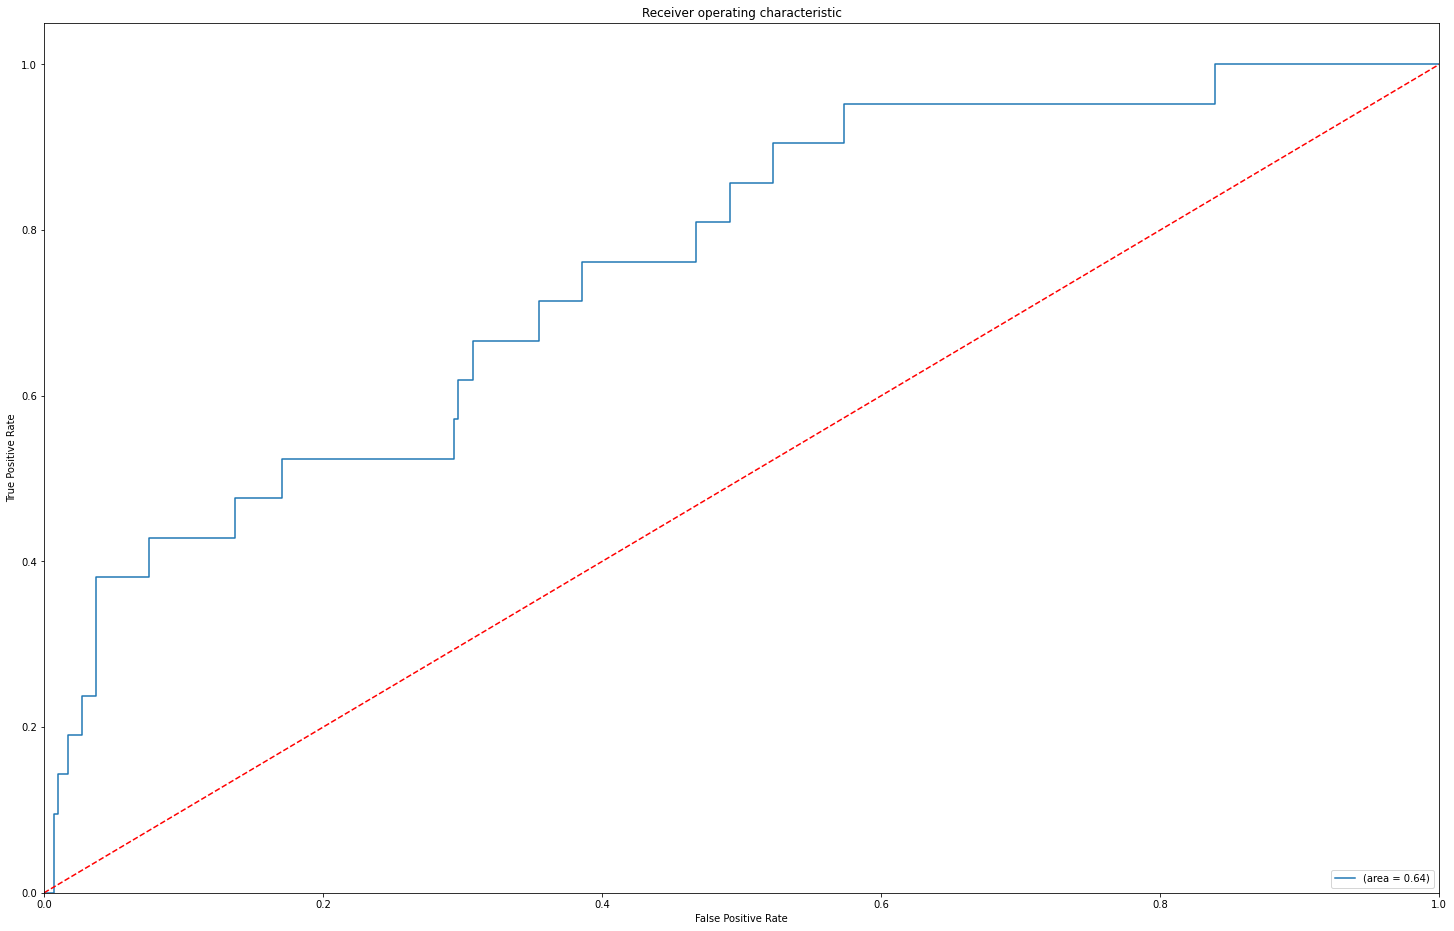


>>>>>>>>>>>LOGISTIC REGRESSION MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.6369426751592356
Recall Score:  [0.6552901  0.38095238]
Precision Score:  [0.93658537 0.0733945 ]
Specificity Score:  [0.6552901  0.38095238]
F1 Score:  [0.77108434 0.12307692]
ROC AUC:  0.5181212416707297
Test of confusion Matrix Scores
True Positives: 8
True Negatives: 192
False Positives: 101
False Negatives: 13
--------------------------------------------------
Accuracy: 0.64
Mis-Classification: 0.36
Sensitivity: 0.38
Specificity: 0.66
Precision: 0.07
Negative Predictive Value: 0.94
f_1 Score: 0.12
              precision    recall  f1-score   support

          -1       0.94      0.66      0.77       293
           1       0.07      0.38      0.12        21

    accuracy                           0.64       314
   macro avg       0.50      0.52      0.45       314
weighted avg       0.88      0.64      0.73       314



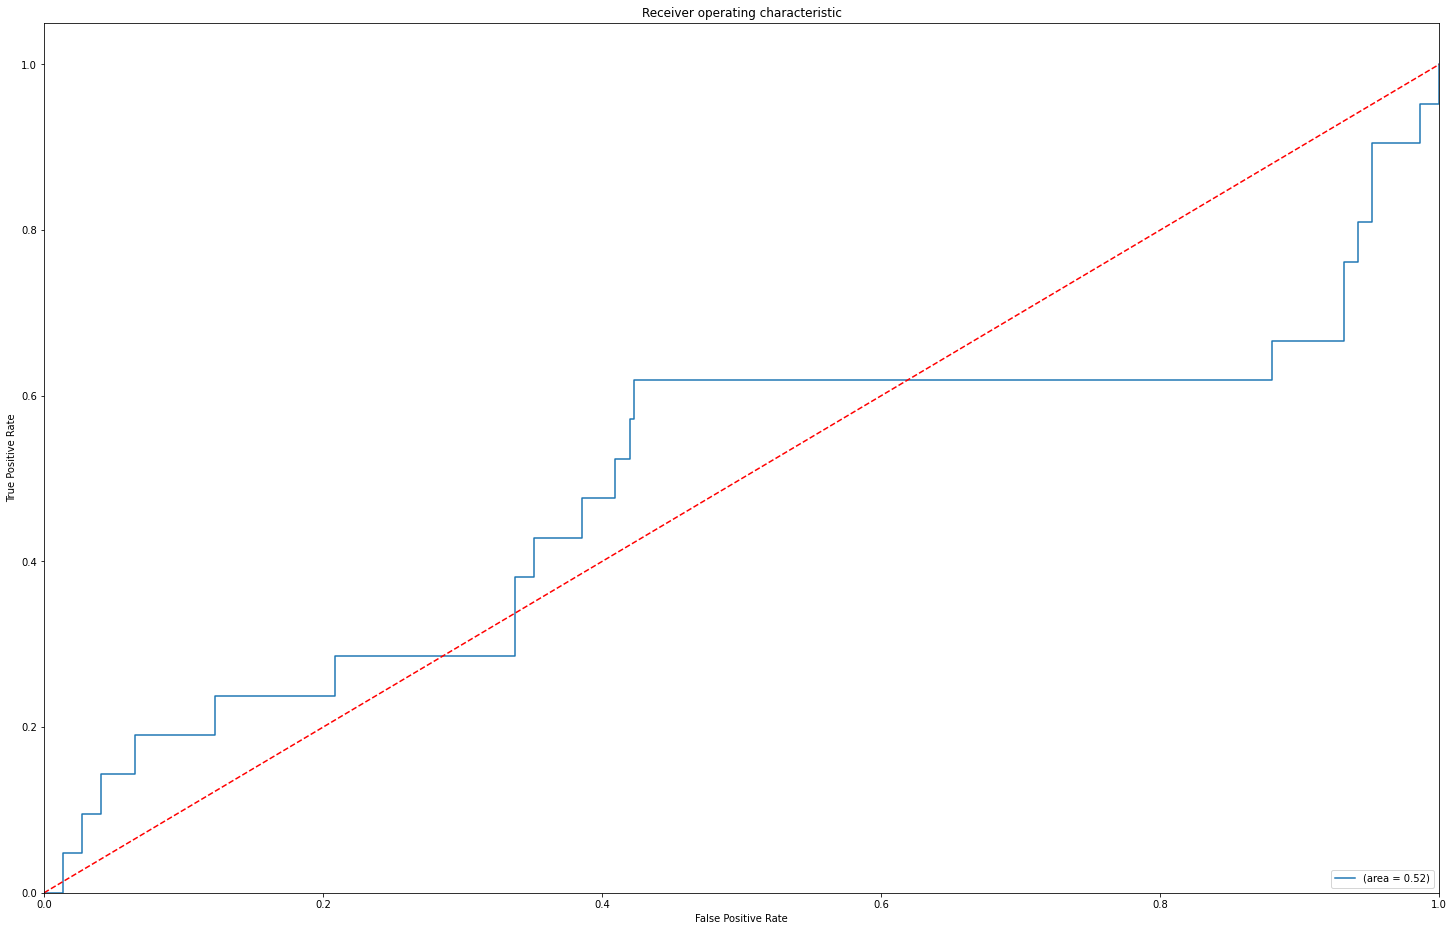


>>>>>>>>>>>LOGISTIC REGRESSION KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.732484076433121
Recall Score:  [0.74744027 0.52380952]
Precision Score:  [0.95633188 0.12941176]
Specificity Score:  [0.74744027 0.52380952]
F1 Score:  [0.83908046 0.20754717]
ROC AUC:  0.6356248984235332
Test of confusion Matrix Scores
True Positives: 11
True Negatives: 219
False Positives: 74
False Negatives: 10
--------------------------------------------------
Accuracy: 0.73
Mis-Classification: 0.27
Sensitivity: 0.52
Specificity: 0.75
Precision: 0.13
Negative Predictive Value: 0.96
f_1 Score: 0.21
              precision    recall  f1-score   support

          -1       0.96      0.75      0.84       293
           1       0.13      0.52      0.21        21

    accuracy                           0.73       314
   macro avg       0.54      0.64      0.52       314
weighted avg       0.90      0.73      0.80       314



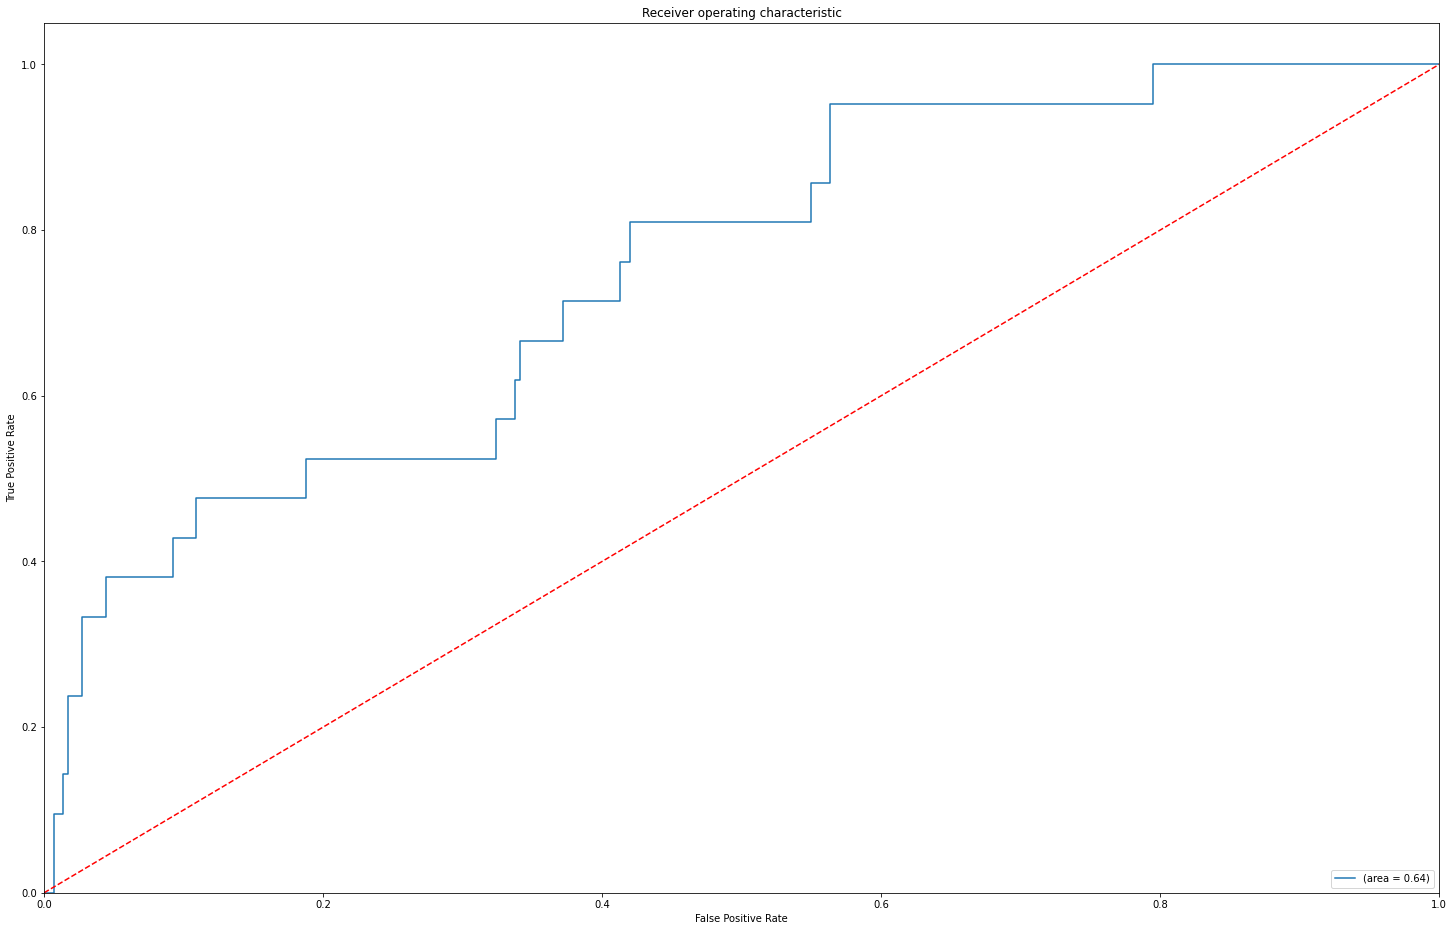


>>>>>>>>>>>LOGISTIC REGRESSION MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.7165605095541401
Recall Score:  [0.74061433 0.38095238]
Precision Score:  [0.94347826 0.0952381 ]
Specificity Score:  [0.74061433 0.38095238]
F1 Score:  [0.82982792 0.15238095]
ROC AUC:  0.5607833577116853
Test of confusion Matrix Scores
True Positives: 8
True Negatives: 217
False Positives: 76
False Negatives: 13
--------------------------------------------------
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.38
Specificity: 0.74
Precision: 0.1
Negative Predictive Value: 0.94
f_1 Score: 0.15
              precision    recall  f1-score   support

          -1       0.94      0.74      0.83       293
           1       0.10      0.38      0.15        21

    accuracy                           0.72       314
   macro avg       0.52      0.56      0.49       314
weighted avg       0.89      0.72      0.78       314



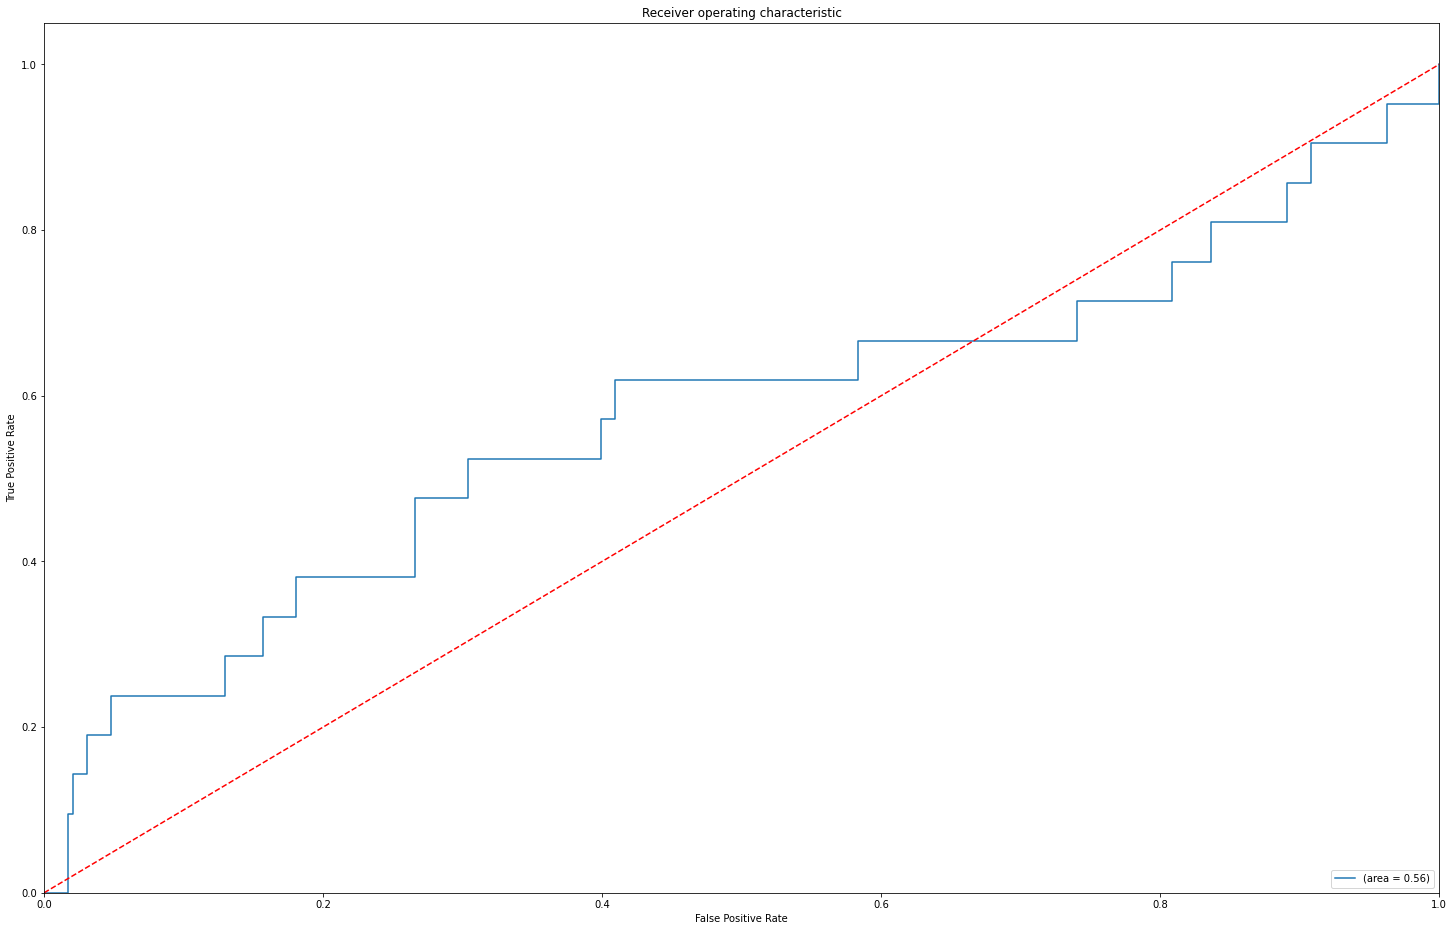

n---------------LOGISTIC REGRESSION WEIGHTED----------------


>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.6242038216560509
Recall Score:  [0.61774744 0.71428571]
Precision Score:  [0.96791444 0.11811024]
Specificity Score:  [0.61774744 0.71428571]
F1 Score:  [0.75416667 0.2027027 ]
ROC AUC:  0.6660165772793759
Test of confusion Matrix Scores
True Positives: 15
True Negatives: 181
False Positives: 112
False Negatives: 6
--------------------------------------------------
Accuracy: 0.62
Mis-Classification: 0.38
Sensitivity: 0.71
Specificity: 0.62
Precision: 0.12
Negative Predictive Value: 0.97
f_1 Score: 0.2
              precision    recall  f1-score   support

          -1       0.97      0.62      0.75       293
           1       0.12      0.71      0.20        21

    accuracy                           0.62       314
   macro avg       0.54      0.67      0.48       314
weighted avg       0.91      0.62      0.72       314



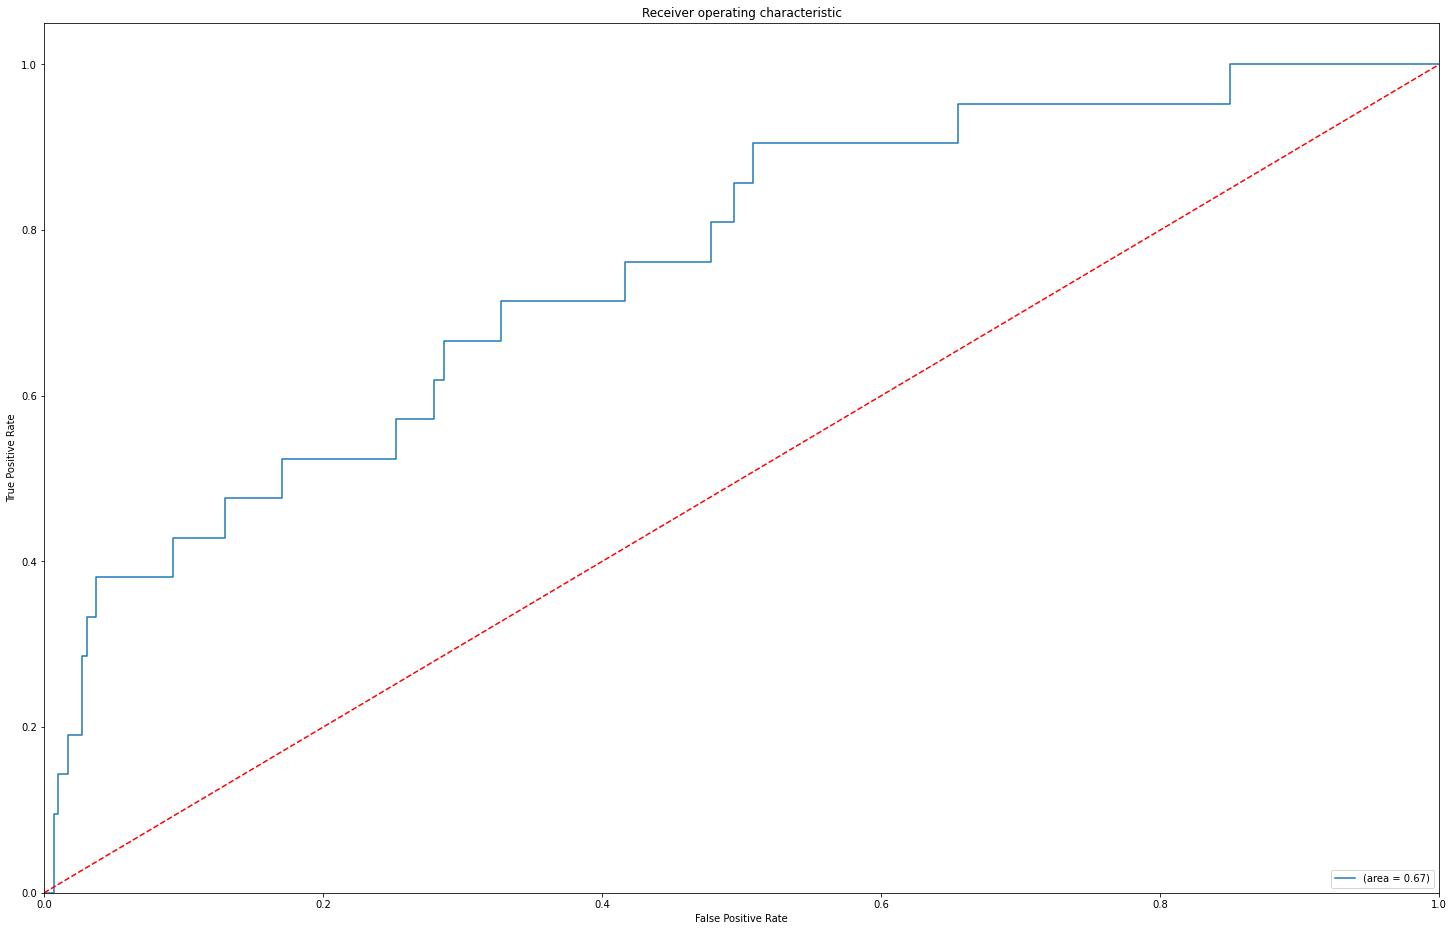


>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.49044585987261147
Recall Score:  [0.48122867 0.61904762]
Precision Score:  [0.94630872 0.07878788]
Specificity Score:  [0.48122867 0.61904762]
F1 Score:  [0.63800905 0.13978495]
ROC AUC:  0.5501381439947993
Test of confusion Matrix Scores
True Positives: 13
True Negatives: 141
False Positives: 152
False Negatives: 8
--------------------------------------------------
Accuracy: 0.49
Mis-Classification: 0.51
Sensitivity: 0.62
Specificity: 0.48
Precision: 0.08
Negative Predictive Value: 0.95
f_1 Score: 0.14
              precision    recall  f1-score   support

          -1       0.95      0.48      0.64       293
           1       0.08      0.62      0.14        21

    accuracy                           0.49       314
   macro avg       0.51      0.55      0.39       314
weighted avg       0.89      0.49      0.60       314



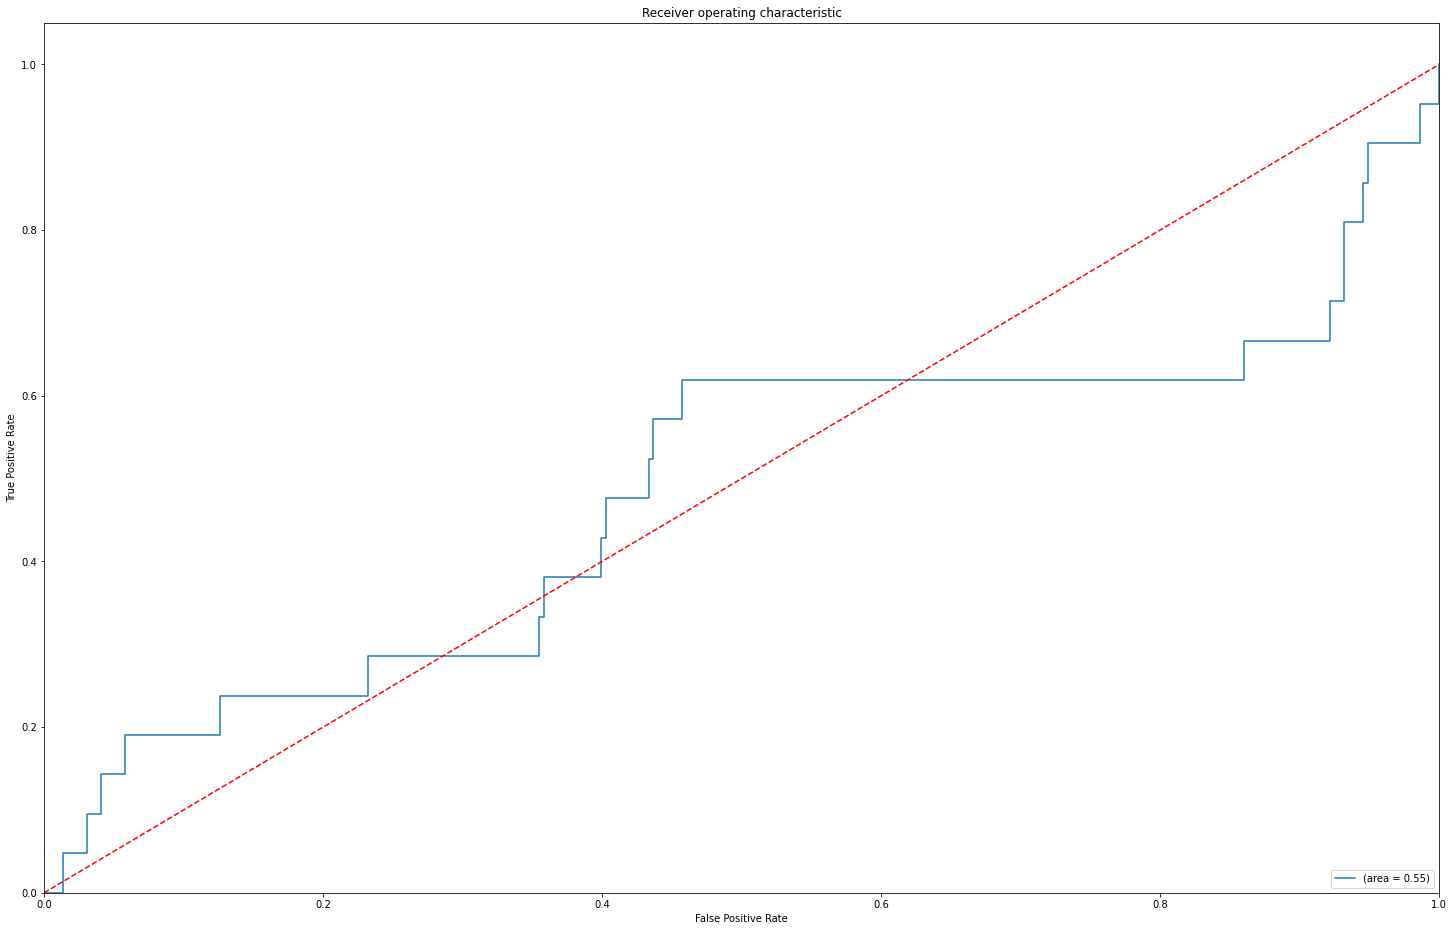


>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.60828025477707
Recall Score:  [0.59726962 0.76190476]
Precision Score:  [0.97222222 0.11940299]
Specificity Score:  [0.59726962 0.76190476]
F1 Score:  [0.73995772 0.20645161]
ROC AUC:  0.6795871932390704
Test of confusion Matrix Scores
True Positives: 16
True Negatives: 175
False Positives: 118
False Negatives: 5
--------------------------------------------------
Accuracy: 0.61
Mis-Classification: 0.39
Sensitivity: 0.76
Specificity: 0.6
Precision: 0.12
Negative Predictive Value: 0.97
f_1 Score: 0.21
              precision    recall  f1-score   support

          -1       0.97      0.60      0.74       293
           1       0.12      0.76      0.21        21

    accuracy                           0.61       314
   macro avg       0.55      0.68      0.47       314
weighted avg       0.92      0.61      0.70       314



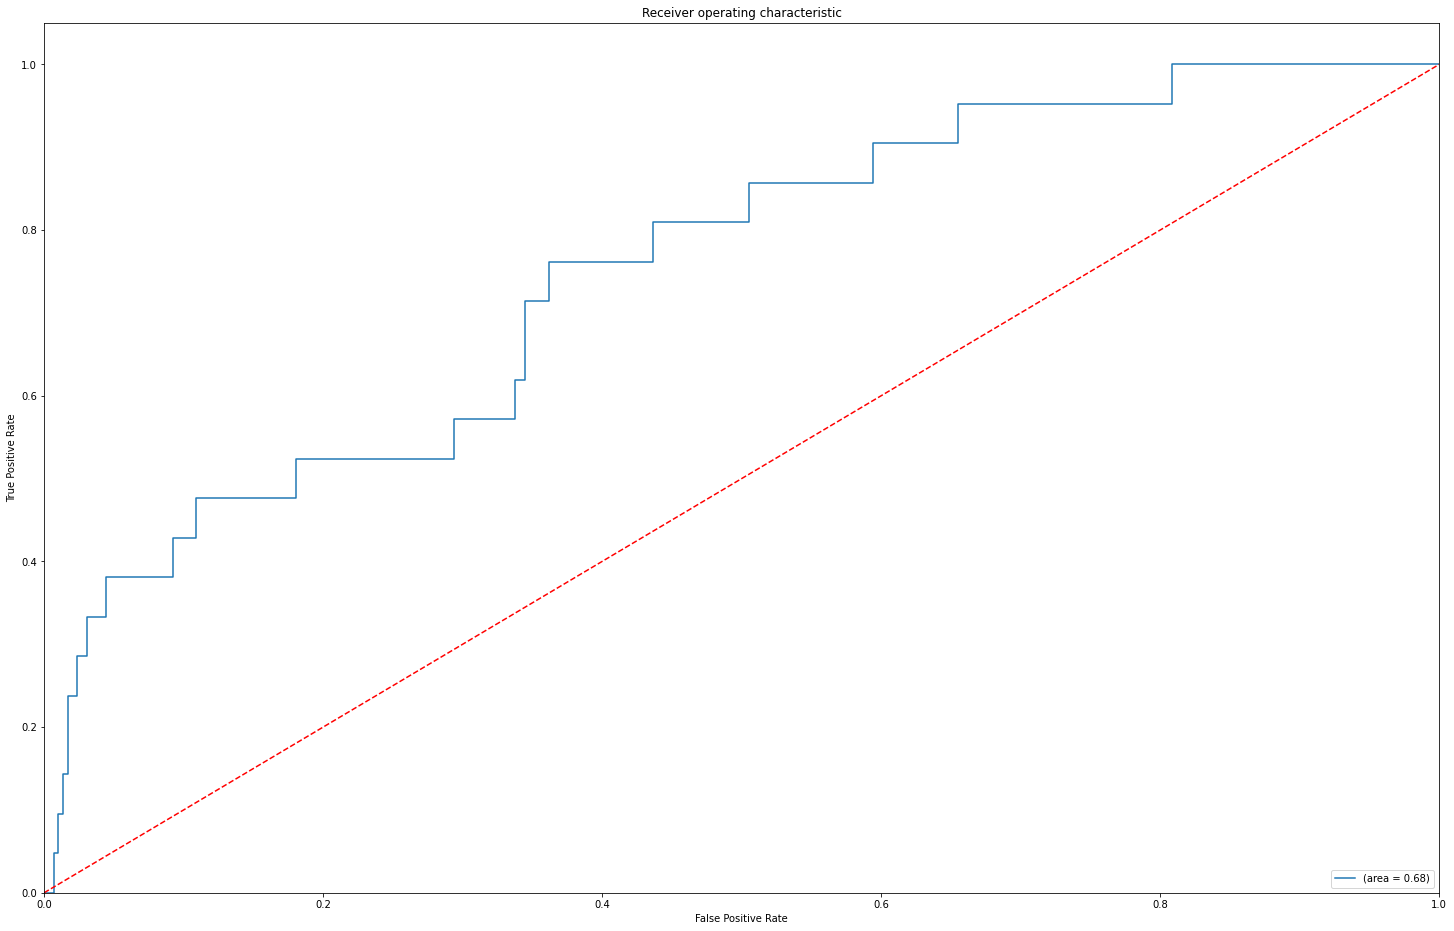


>>>>>>>>>>>LOGISTIC REGRESSION WEIGHTED MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.4713375796178344
Recall Score:  [0.46075085 0.61904762]
Precision Score:  [0.94405594 0.07602339]
Specificity Score:  [0.46075085 0.61904762]
F1 Score:  [0.61926606 0.13541667]
ROC AUC:  0.5398992361449699
Test of confusion Matrix Scores
True Positives: 13
True Negatives: 135
False Positives: 158
False Negatives: 8
--------------------------------------------------
Accuracy: 0.47
Mis-Classification: 0.53
Sensitivity: 0.62
Specificity: 0.46
Precision: 0.08
Negative Predictive Value: 0.94
f_1 Score: 0.14
              precision    recall  f1-score   support

          -1       0.94      0.46      0.62       293
           1       0.08      0.62      0.14        21

    accuracy                           0.47       314
   macro avg       0.51      0.54      0.38       314
weighted avg       0.89      0.47      0.59       314



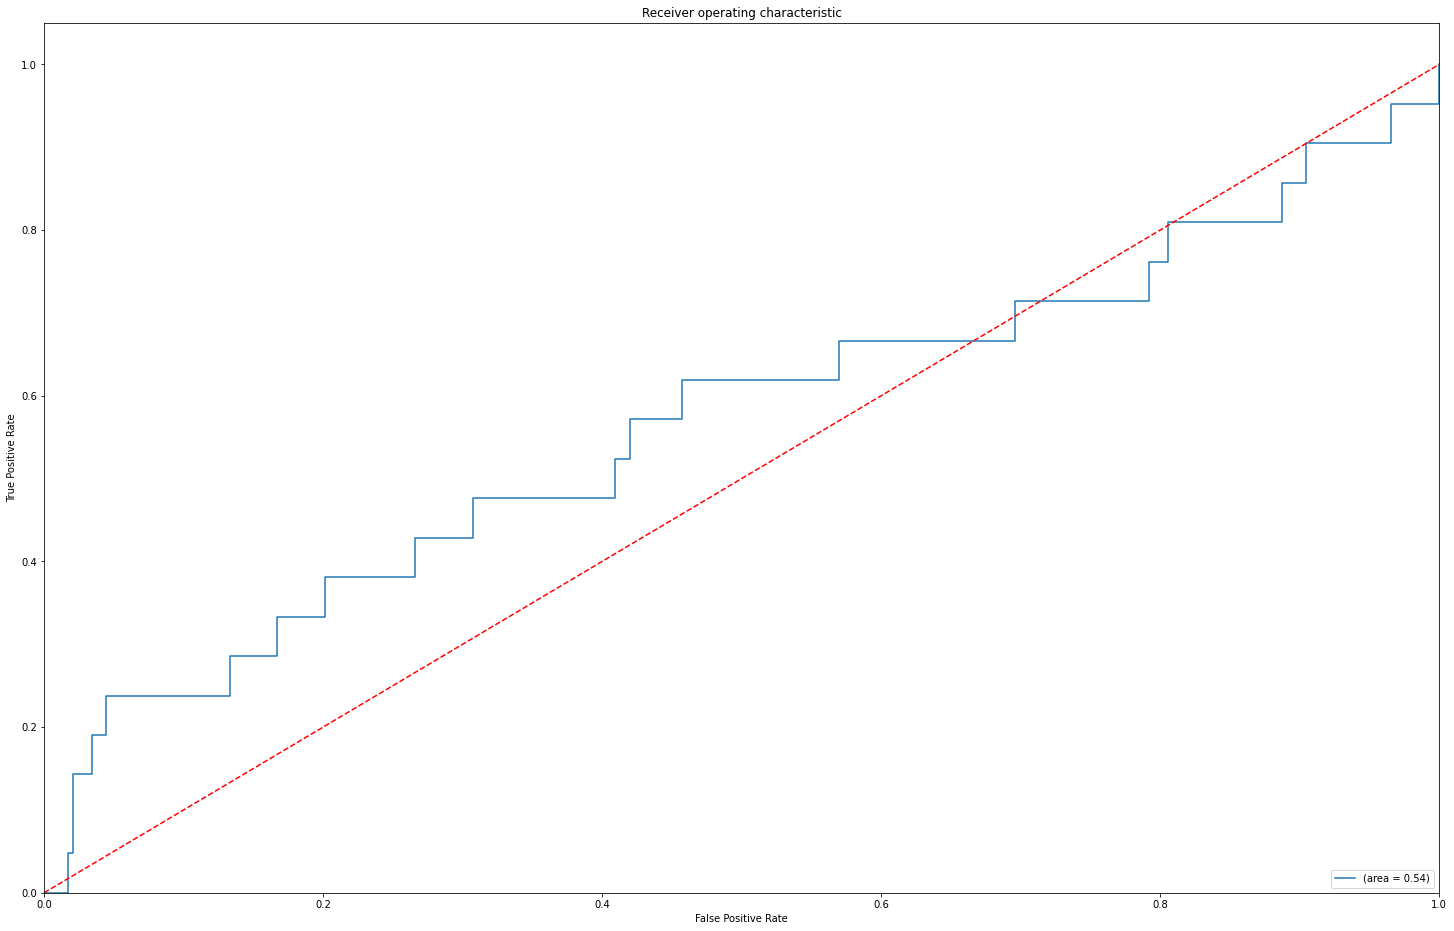

n------------SUPPORT VECTOR MACHINE----------------


>>>>>>>>>>>SVM  KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.8821656050955414
Recall Score:  [0.92491468 0.28571429]
Precision Score:  [0.94755245 0.21428571]
Specificity Score:  [0.92491468 0.28571429]
F1 Score:  [0.93609672 0.24489796]
ROC AUC:  0.6053144807411018
Test of confusion Matrix Scores
True Positives: 6
True Negatives: 271
False Positives: 22
False Negatives: 15
--------------------------------------------------
Accuracy: 0.88
Mis-Classification: 0.12
Sensitivity: 0.29
Specificity: 0.92
Precision: 0.21
Negative Predictive Value: 0.95
f_1 Score: 0.24
              precision    recall  f1-score   support

          -1       0.95      0.92      0.94       293
           1       0.21      0.29      0.24        21

    accuracy                           0.88       314
   macro avg       0.58      0.61      0.59       314
weighted avg       0.90      0.88      0.89       314



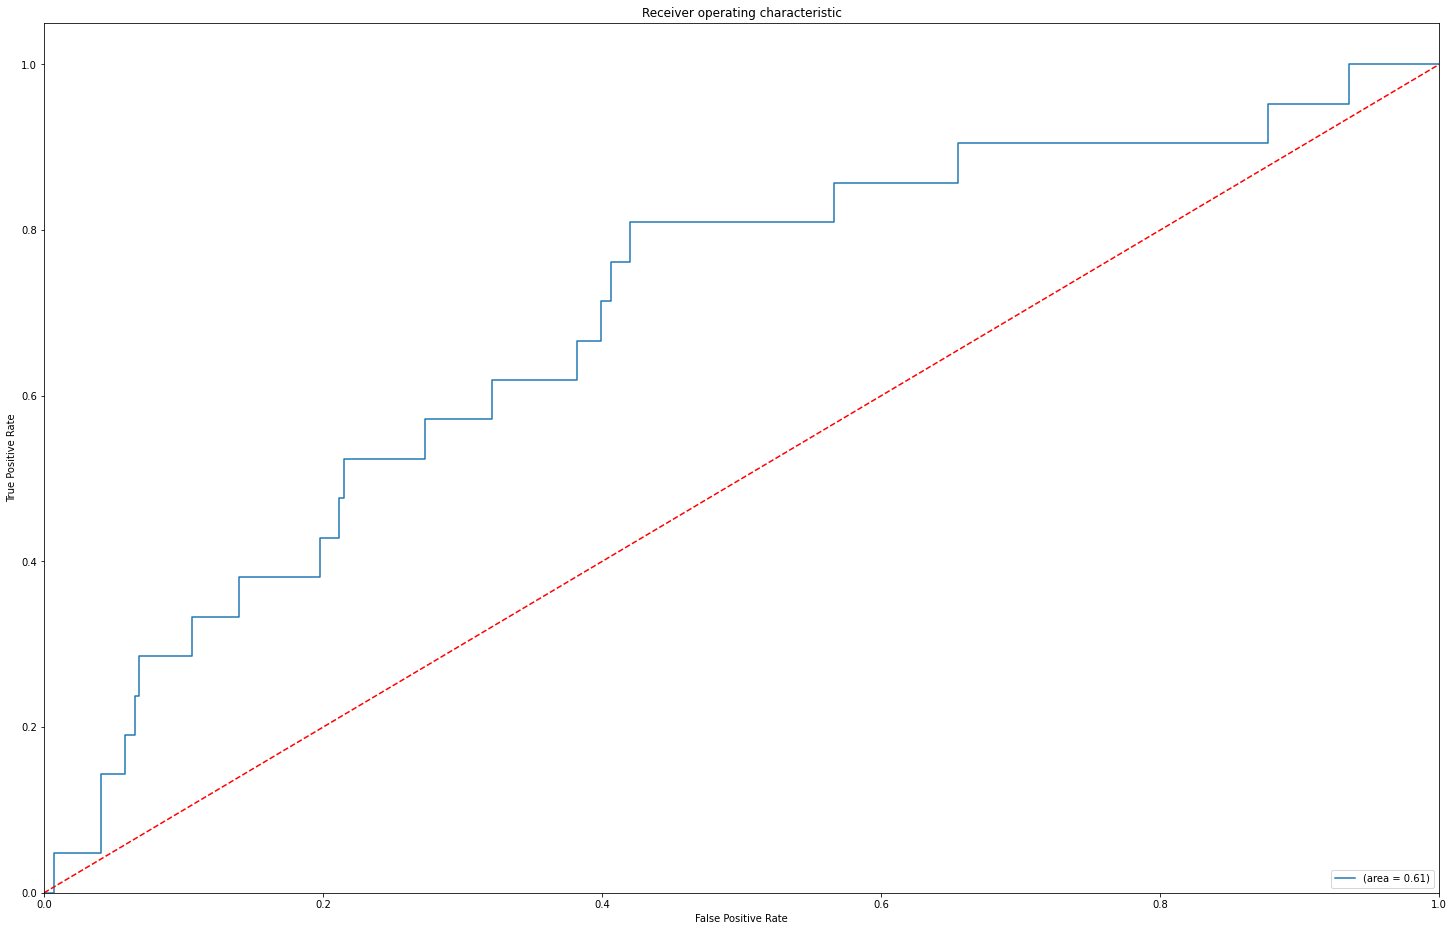


>>>>>>>>>>>SVM  MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.7993630573248408
Recall Score:  [0.83276451 0.33333333]
Precision Score:  [0.94573643 0.125     ]
Specificity Score:  [0.83276451 0.33333333]
F1 Score:  [0.88566243 0.18181818]
ROC AUC:  0.5830489192263936
Test of confusion Matrix Scores
True Positives: 7
True Negatives: 244
False Positives: 49
False Negatives: 14
--------------------------------------------------
Accuracy: 0.8
Mis-Classification: 0.2
Sensitivity: 0.33
Specificity: 0.83
Precision: 0.12
Negative Predictive Value: 0.95
f_1 Score: 0.18
              precision    recall  f1-score   support

          -1       0.95      0.83      0.89       293
           1       0.12      0.33      0.18        21

    accuracy                           0.80       314
   macro avg       0.54      0.58      0.53       314
weighted avg       0.89      0.80      0.84       314



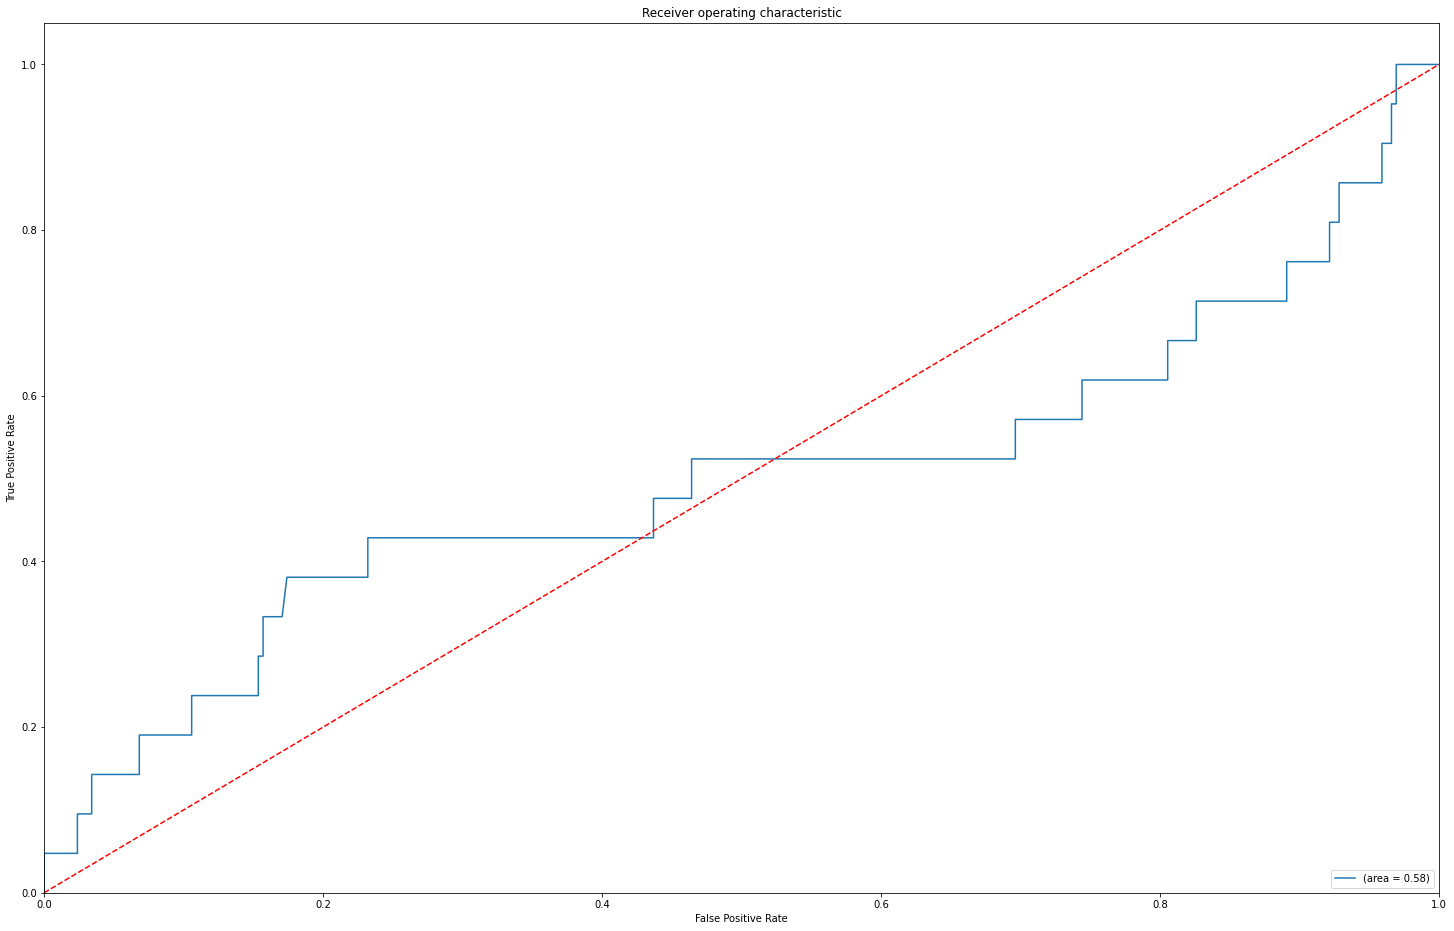


>>>>>>>>>>>SVM  KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.8312101910828026
Recall Score:  [0.86348123 0.38095238]
Precision Score:  [0.95112782 0.16666667]
Specificity Score:  [0.86348123 0.38095238]
F1 Score:  [0.90518784 0.23188406]
ROC AUC:  0.6222168048106614
Test of confusion Matrix Scores
True Positives: 8
True Negatives: 253
False Positives: 40
False Negatives: 13
--------------------------------------------------
Accuracy: 0.83
Mis-Classification: 0.17
Sensitivity: 0.38
Specificity: 0.86
Precision: 0.17
Negative Predictive Value: 0.95
f_1 Score: 0.23
              precision    recall  f1-score   support

          -1       0.95      0.86      0.91       293
           1       0.17      0.38      0.23        21

    accuracy                           0.83       314
   macro avg       0.56      0.62      0.57       314
weighted avg       0.90      0.83      0.86       314



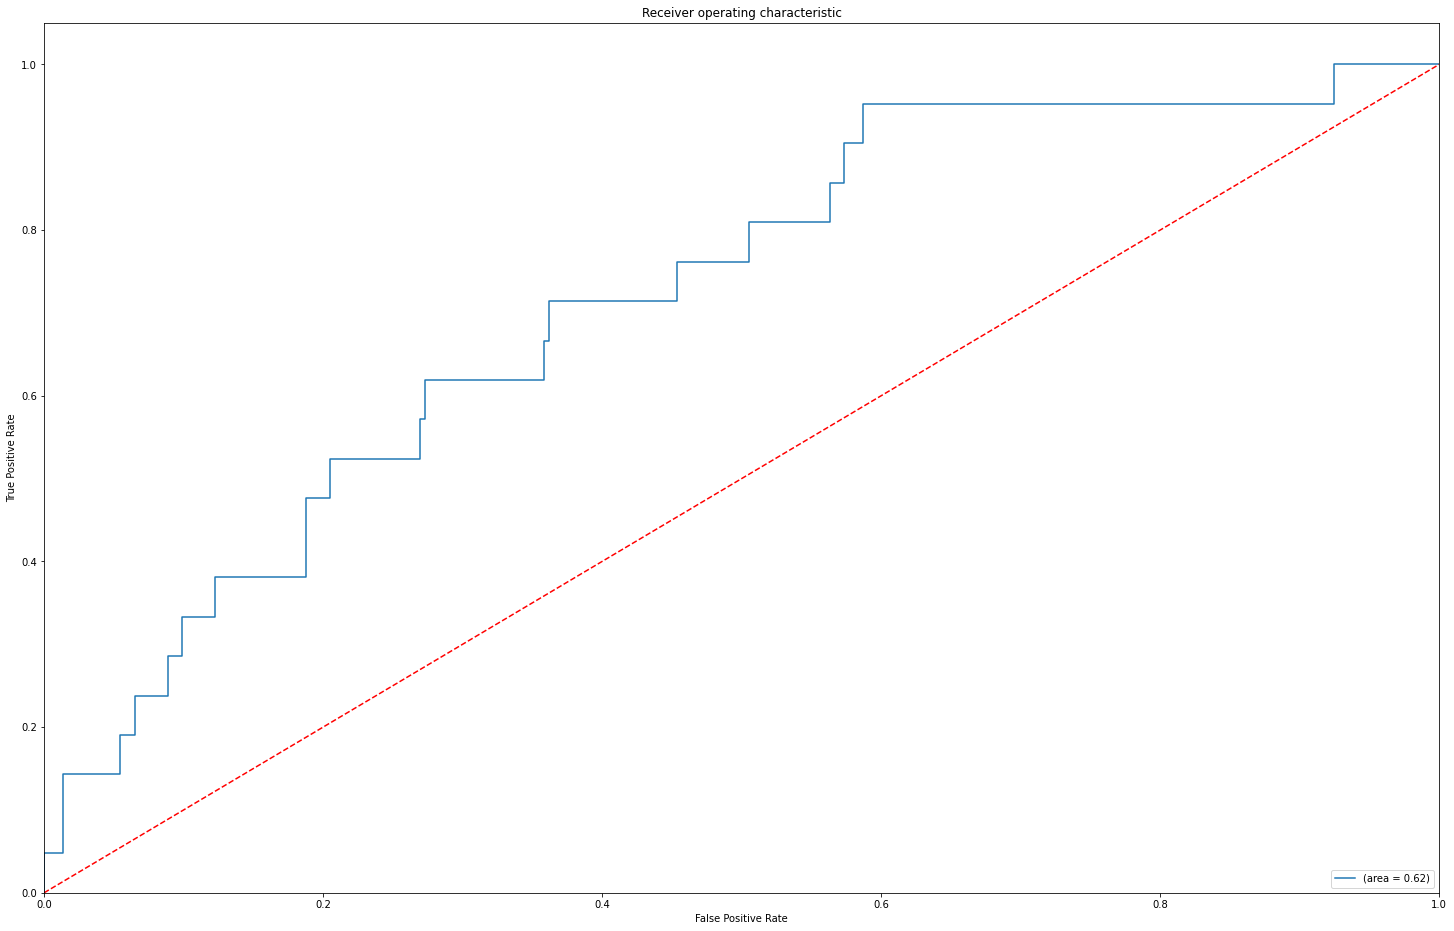


>>>>>>>>>>>SVM  MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.7929936305732485
Recall Score:  [0.82593857 0.33333333]
Precision Score:  [0.9453125  0.12068966]
Specificity Score:  [0.82593857 0.33333333]
F1 Score:  [0.88160291 0.17721519]
ROC AUC:  0.5796359499431171
Test of confusion Matrix Scores
True Positives: 7
True Negatives: 242
False Positives: 51
False Negatives: 14
--------------------------------------------------
Accuracy: 0.79
Mis-Classification: 0.21
Sensitivity: 0.33
Specificity: 0.83
Precision: 0.12
Negative Predictive Value: 0.95
f_1 Score: 0.18
              precision    recall  f1-score   support

          -1       0.95      0.83      0.88       293
           1       0.12      0.33      0.18        21

    accuracy                           0.79       314
   macro avg       0.53      0.58      0.53       314
weighted avg       0.89      0.79      0.83       314



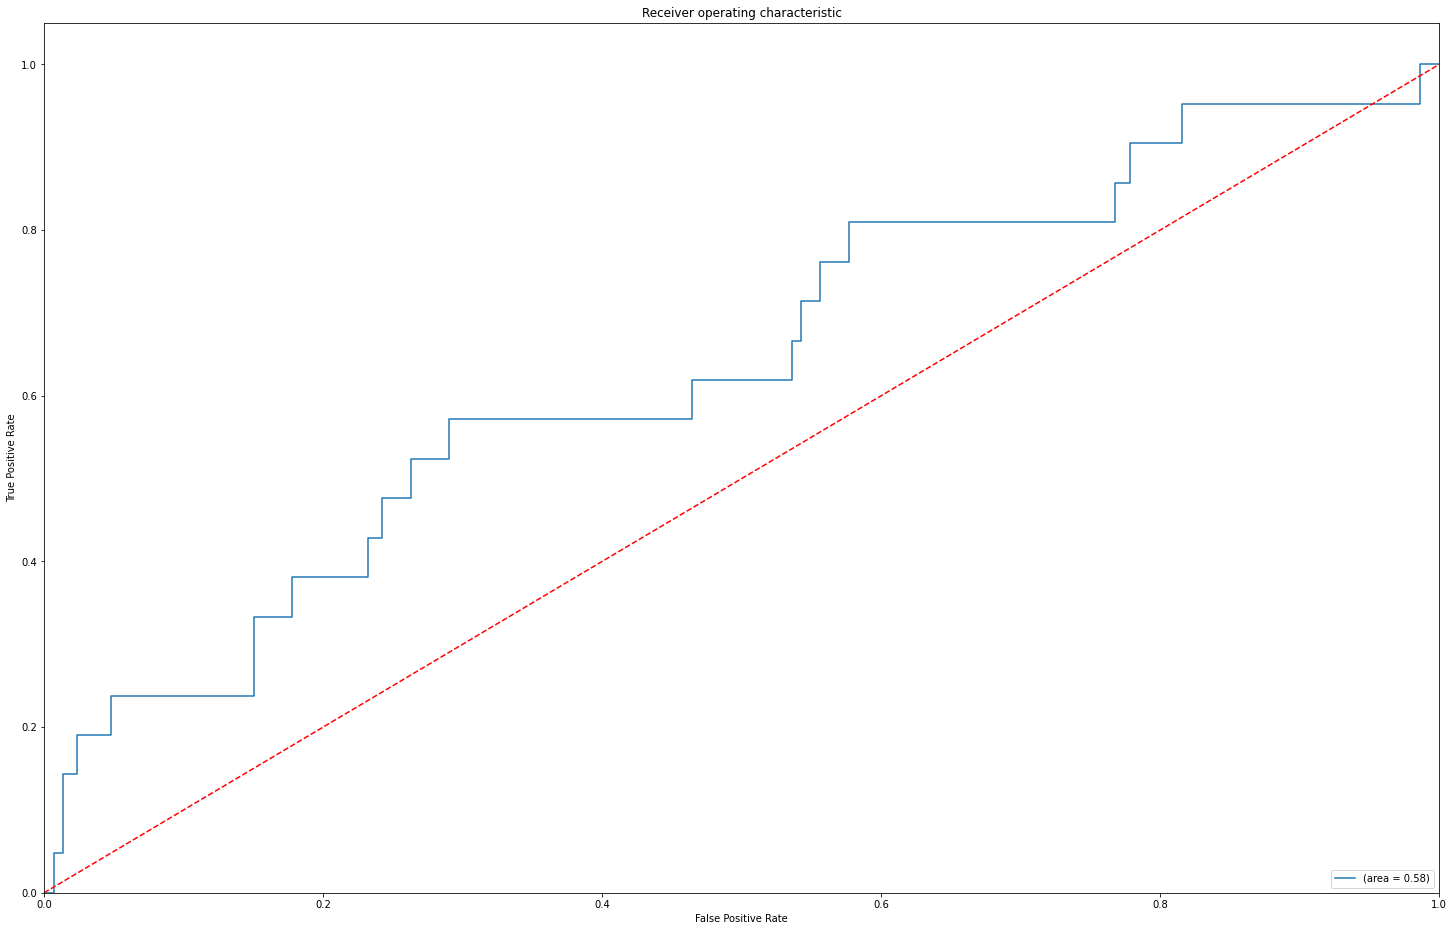

n-----------------NAIVE BAYES----------------------


>>>>>>>>>>>NAIVE BAYES  KNN BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.7707006369426752
Recall Score:  [0.79863481 0.38095238]
Precision Score:  [0.94736842 0.11940299]
Specificity Score:  [0.79863481 0.38095238]
F1 Score:  [0.86666667 0.18181818]
ROC AUC:  0.5897935966195351
Test of confusion Matrix Scores
True Positives: 8
True Negatives: 234
False Positives: 59
False Negatives: 13
--------------------------------------------------
Accuracy: 0.77
Mis-Classification: 0.23
Sensitivity: 0.38
Specificity: 0.8
Precision: 0.12
Negative Predictive Value: 0.95
f_1 Score: 0.18
              precision    recall  f1-score   support

          -1       0.95      0.80      0.87       293
           1       0.12      0.38      0.18        21

    accuracy                           0.77       314
   macro avg       0.53      0.59      0.52       314
weighted avg       0.89      0.77      0.82       314



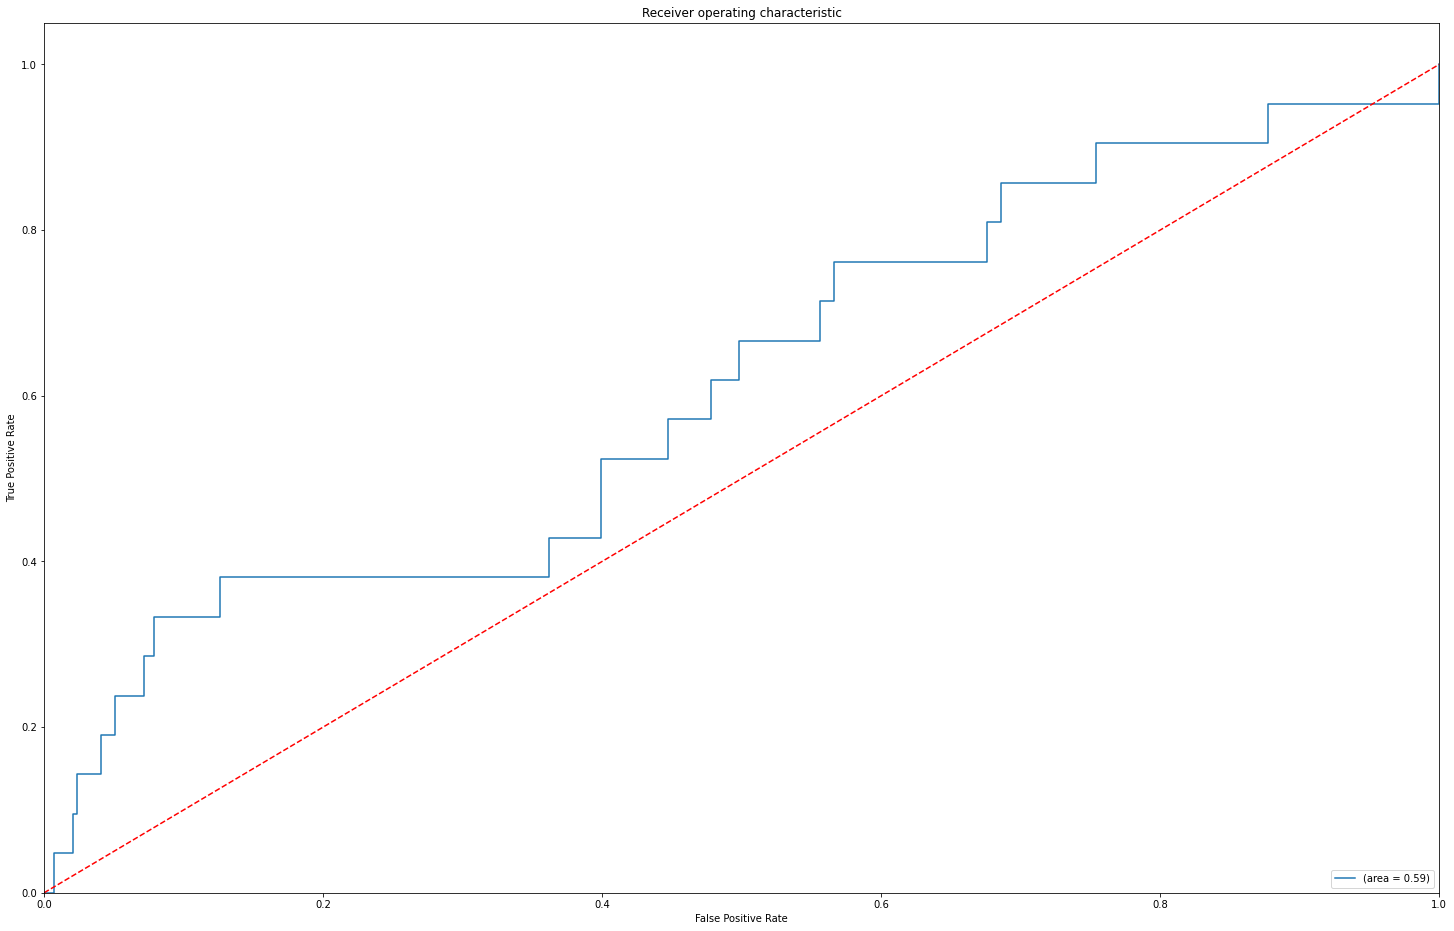


>>>>>>>>>>>NAIVE BAYES  MICE BORUTA SMOTE <<<<<<<<<<<<<

Accuracy Score:  0.7101910828025477
Recall Score:  [0.73720137 0.33333333]
Precision Score:  [0.93913043 0.08333333]
Specificity Score:  [0.73720137 0.33333333]
F1 Score:  [0.82600382 0.13333333]
ROC AUC:  0.5352673492605233
Test of confusion Matrix Scores
True Positives: 7
True Negatives: 216
False Positives: 77
False Negatives: 14
--------------------------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity: 0.33
Specificity: 0.74
Precision: 0.08
Negative Predictive Value: 0.94
f_1 Score: 0.13
              precision    recall  f1-score   support

          -1       0.94      0.74      0.83       293
           1       0.08      0.33      0.13        21

    accuracy                           0.71       314
   macro avg       0.51      0.54      0.48       314
weighted avg       0.88      0.71      0.78       314



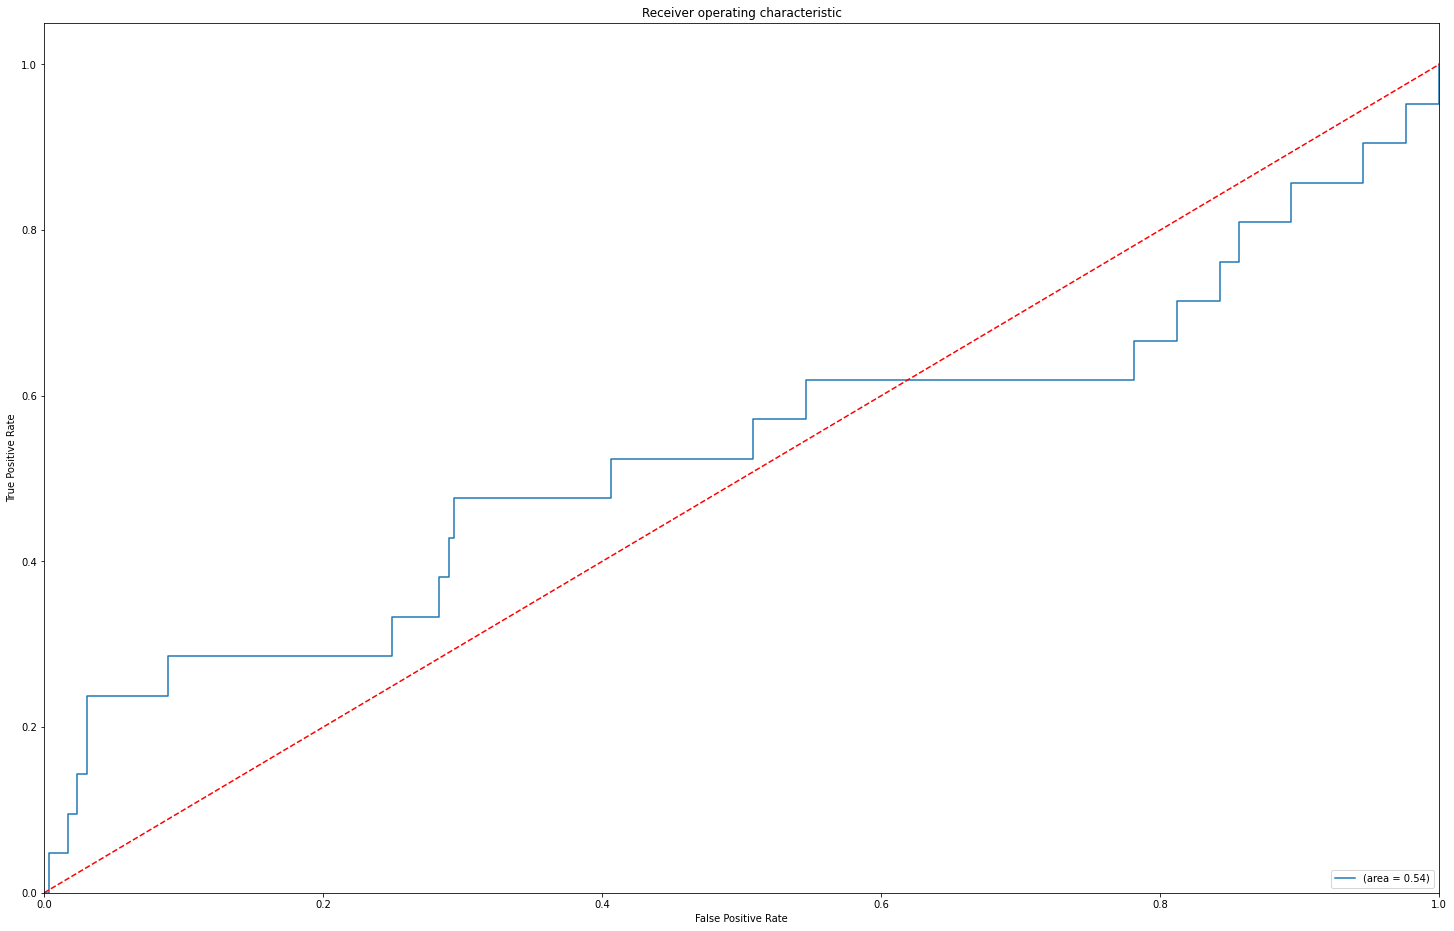


>>>>>>>>>>>NAIVE BAYES  KNN BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.7165605095541401
Recall Score:  [0.7337884  0.47619048]
Precision Score:  [0.95132743 0.11363636]
Specificity Score:  [0.7337884  0.47619048]
F1 Score:  [0.82851638 0.18348624]
ROC AUC:  0.6049894360474566
Test of confusion Matrix Scores
True Positives: 10
True Negatives: 215
False Positives: 78
False Negatives: 11
--------------------------------------------------
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.48
Specificity: 0.73
Precision: 0.11
Negative Predictive Value: 0.95
f_1 Score: 0.18
              precision    recall  f1-score   support

          -1       0.95      0.73      0.83       293
           1       0.11      0.48      0.18        21

    accuracy                           0.72       314
   macro avg       0.53      0.60      0.51       314
weighted avg       0.90      0.72      0.79       314



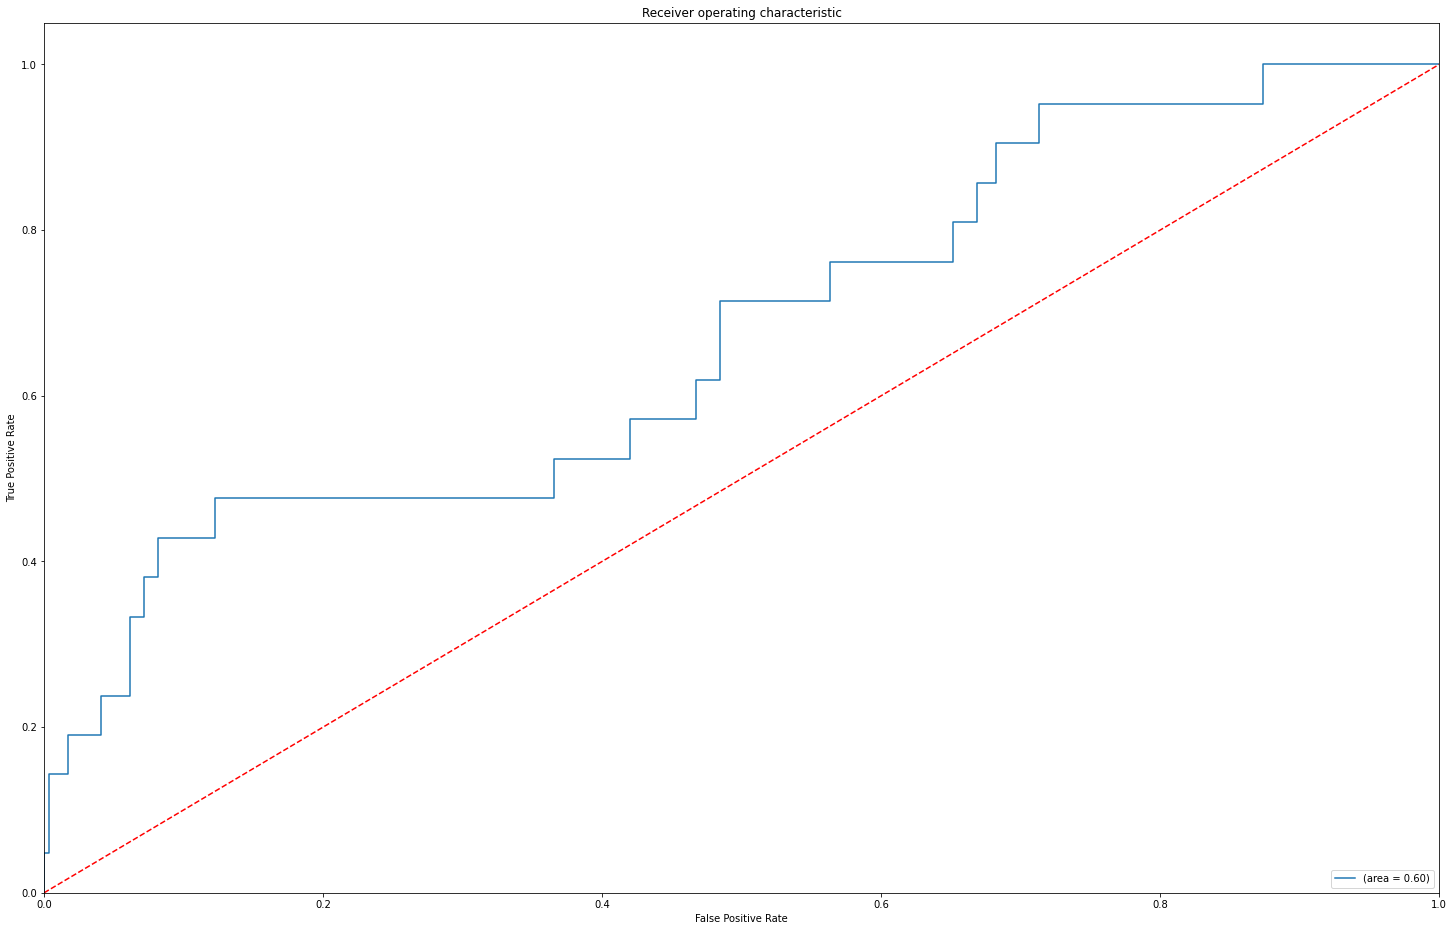


>>>>>>>>>>>NAIVE BAYES  MICE BORUTA ROSE <<<<<<<<<<<<<

Accuracy Score:  0.535031847133758
Recall Score:  [0.51194539 0.85714286]
Precision Score:  [0.98039216 0.11180124]
Specificity Score:  [0.51194539 0.85714286]
F1 Score:  [0.67264574 0.1978022 ]
ROC AUC:  0.6845441248171624
Test of confusion Matrix Scores
True Positives: 18
True Negatives: 150
False Positives: 143
False Negatives: 3
--------------------------------------------------
Accuracy: 0.54
Mis-Classification: 0.46
Sensitivity: 0.86
Specificity: 0.51
Precision: 0.11
Negative Predictive Value: 0.98
f_1 Score: 0.2
              precision    recall  f1-score   support

          -1       0.98      0.51      0.67       293
           1       0.11      0.86      0.20        21

    accuracy                           0.54       314
   macro avg       0.55      0.68      0.44       314
weighted avg       0.92      0.54      0.64       314



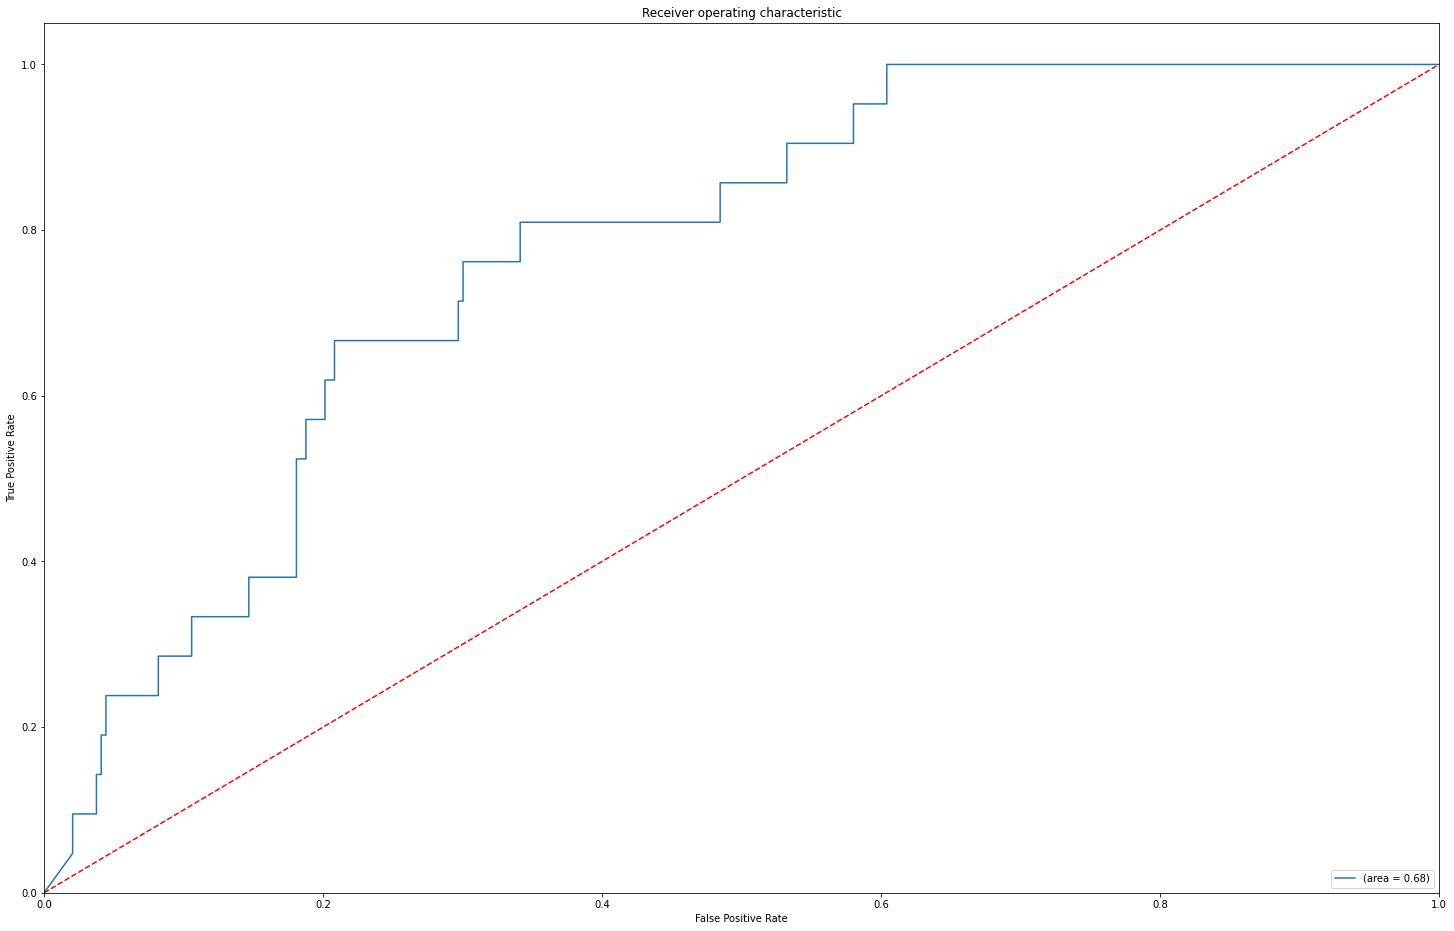

In [ ]:
models_mod_df = modelling_mod(train_test_dict, target_var = "STATUS")

In [ ]:
models_mod_df.head()

,COMBINATIONS,TruePositives,TrueNegatives,FalsePositives,FalseNegatives,Accuracy,MisClassification,Sensitivity,Specificity,Precision,...,RecallScore,PrecisionScore,SpecificityScore,F1Score,ROCAUC,Cost_per_Error_I,Cost_per_Error_II,Total_Error_Cost,Conservative_Cost_per_Error_II,ConservativeTotal_Error_Cost
0,LOGISTIC REGRESSION KNN BORUTA SMOTE,11,219,74,10,0.732484,0.267516,0.523810,0.747440,0.129412,...,"[0.7474402730375427, 0.5238095238095238]","[0.9563318777292577, 0.12941176470588237]","[0.7474402730375427, 0.5238095238095238]","[0.839080459770115, 0.2075471698113208]",0.635625,4440,6000,10440,1800,6240
1,LOGISTIC REGRESSION MICE BORUTA SMOTE,8,192,101,13,0.636943,0.363057,0.380952,0.655290,0.073394,...,"[0.6552901023890785, 0.38095238095238093]","[0.9365853658536586, 0.07339449541284404]","[0.6552901023890785, 0.38095238095238093]","[0.7710843373493976, 0.12307692307692308]",0.518121,6060,7800,13860,2340,8400
2,LOGISTIC REGRESSION KNN BORUTA ROSE,11,219,74,10,0.732484,0.267516,0.523810,0.747440,0.129412,...,"[0.7474402730375427, 0.5238095238095238]","[0.9563318777292577, 0.12941176470588237]","[0.7474402730375427, 0.5238095238095238]","[0.839080459770115, 0.2075471698113208]",0.635625,4440,6000,10440,1800,6240
3,LOGISTIC REGRESSION MICE BORUTA ROSE,8,217,76,13,0.716561,0.283439,0.380952,0.740614,0.095238,...,"[0.7406143344709898, 0.38095238095238093]","[0.9434782608695652, 0.09523809523809523]","[0.7406143344709898, 0.38095238095238093]","[0.829827915869981, 0.15238095238095237]",0.560783,4560,7800,12360,2340,6900
4,LOGISTIC REGRESSION WEIGHTED KNN BORUTA SMOTE,15,181,112,6,0.624204,0.375796,0.714286,0.617747,0.118110,...,"[0.6177474402730375, 0.7142857142857143]","[0.9679144385026738, 0.11811023622047244]","[0.6177474402730375, 0.7142857142857143]","[0.7541666666666667, 0.2027027027027027]",0.666017,6720,3600,10320,1080,7800


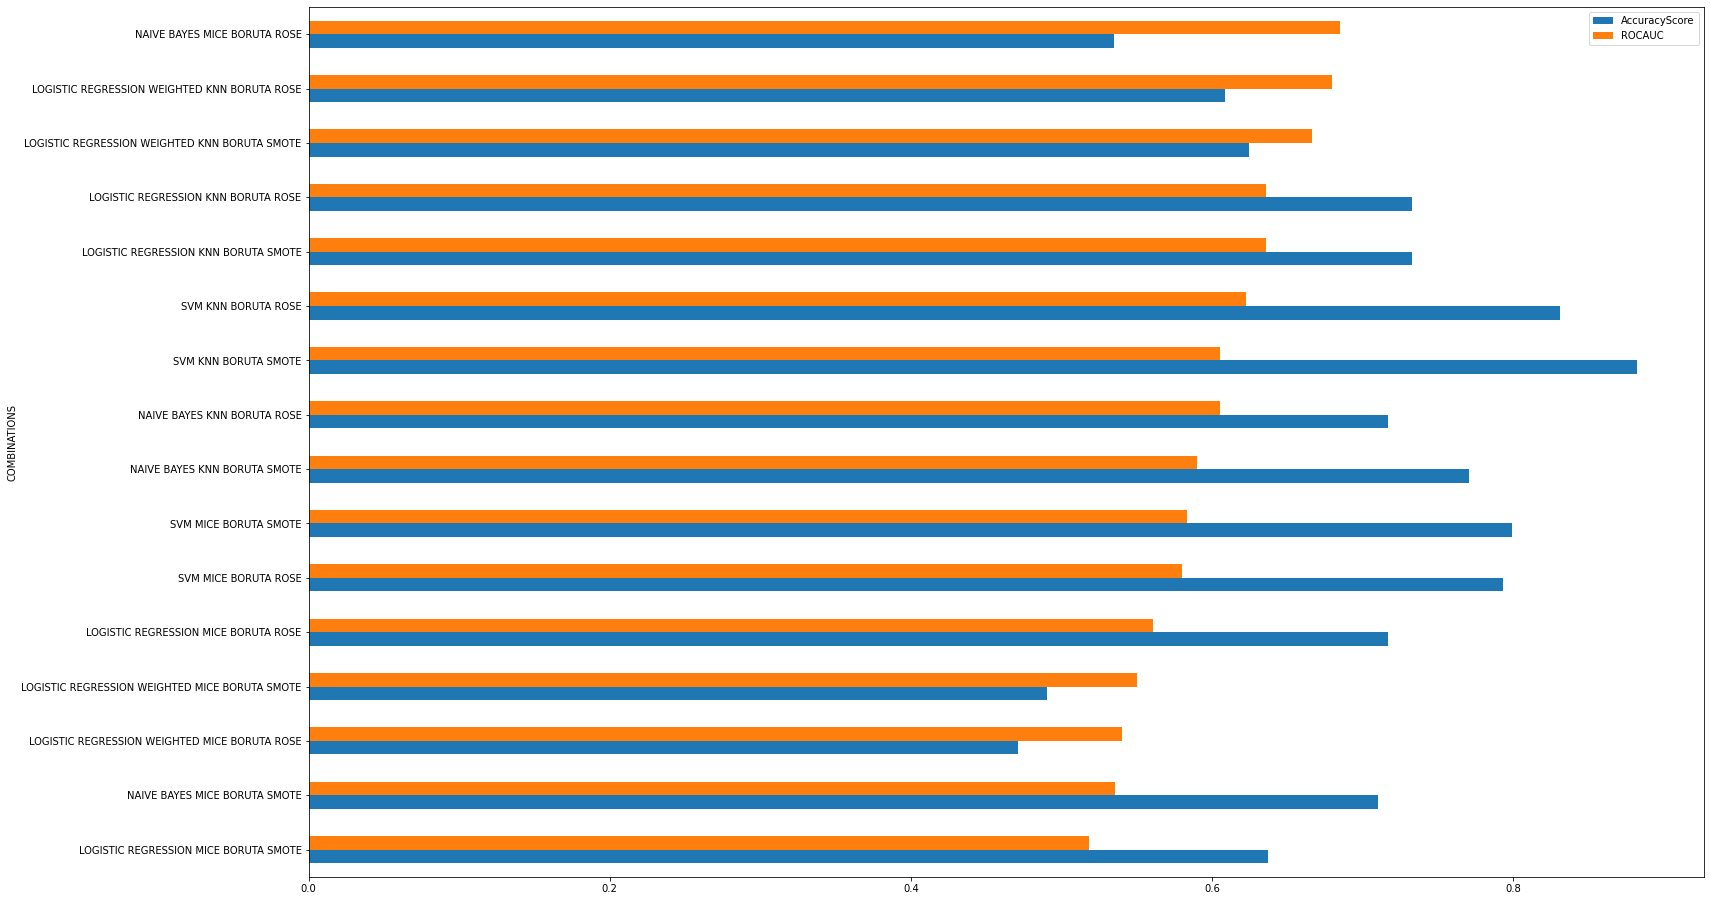

In [ ]:
models_mod_df.sort_values(by=["ROCAUC","AccuracyScore"], ascending = True).plot(x="COMBINATIONS", y=["AccuracyScore","ROCAUC"], kind="barh")